<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Siemens/Siemens_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "SIE.de"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High    Low  Close  Adj Close   Volume
Date                                                        
2009-01-02   52.58   53.78  51.97  53.78      36.64  4548970
2009-01-05   54.67   55.37  52.86  53.21      36.25  5350164
2009-01-06   53.59   55.17  53.56  54.45      37.10  5121055
2009-01-07   54.04   54.33  52.97  53.41      36.39  3885695
2009-01-08   52.42   52.72  50.79  51.32      34.97  5158570
...            ...     ...    ...    ...        ...      ...
2018-12-19  100.38  100.64  99.39  99.51      95.72  2623829
2018-12-20   98.32   98.64  97.11  98.39      94.64  3725141
2018-12-21   98.22   98.34  97.11  98.17      94.43  6667022
2018-12-27   98.00   98.06  94.97  95.82      92.17  3107490
2018-12-28   96.33   98.11  96.33  97.38      93.67  1702272

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean     87.791221    88.605707    86.958834    87.794695    74.173375  3.008274e+06
std      20.000959    20.008590    20.013986    20.007067    23.117720  1.738982e+06
min      37.500000    38.250000    36.160000    37.170000    26.300000  0.000000e+00
25%      73.225000    73.985000    72.385000    73.210000    55.410000  1.894764e+06
50%      89.750000    90.760000    89.140000    89.920000    73.870000  2.599163e+06
75%      99.825000   100.775000    99.125000    99.990000    87.995000  3.588094e+06
max     132.450000   133.500000   132.050000   133.200000   124.250000  2.062244e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama        fama      SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2009-03-13   43.30   43.56  41.87  42.14      29.81  4957991   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  40.407511   39.866510   36.806912  41.418022  40.645263  39.824814      39.965      39.860   37.172032  39.90375  42.455428  39.6705  40.743333  39.90375  42.066667   40.137152               43.886813                 39.90375               35.920687               45.878345                 39.90375               33.929155               47.869877                 39.90375               31.937623               49.861408                 39.90375               29.946092  40.645263  41.825321   39.891023               44.628326                40.645263               36.662200               46.619858                40.645263               34.670668               48.611390                40.645263               32.679136               50.602921                40.645263   
2009-03-16   43.18   43.67  42.43  42.97      30.40  5133808   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  41.688755   40.322071   37.347159  42.164712  41.161871  40.184602      40.135      39.915   37.683069  40.38500  43.150537  40.5240  41.424722  40.38500  42.555000   40.142014               44.781840                 40.38500               35.988160               46.980260                 40.38500               33.789740               49.178680                 40.38500               31.591320               51.377099                 40.38500               29.392901  41.161871  42.683990   39.956222               45.558711                41.161871               36.765031               47.757131                41.161871               34.566611               49.955551                41.161871               32.368192               52.153971                41.161871   
2009-03-17   42.88

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean     88.675139    89.487859    87.850888    88.684050    75.053572  2.942407e+06    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020    88.632705    88.459527     5.291988    88.686152    88.602532    88.535805    88.578017    88.500438    88.266162    88.603189    88.686073    88.603835    88.630920    88.603189    88.664758    88.435213               91.166176                88.603189               86.040202               92.447670                88.603189               84.758708               93.729163                88.603189               83.477215               95.010657                88.603189               82.195721    88.602532    88.667188    88.460131               91.165519                88.602532               86.039545               92.447012                88.602532               84.758051               93.728506   
std      19.183120    19.195921    19.178133    19.177491    22.486846  1.652353e+06     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    19.166355    19.192957    90.319230    19.192363    19.181278    19.297451    19.219493    19.217771    19.470668    19.205199    19.187298    19.216641    19.185480    19.205199    19.185543    19.281750               19.375388                19.205199               19.129752               19.495289                19.205199               19.127961               19.637855                19.205199               19.150164               19.802596                19.205199               19.196279    19.181278    19.173579    19.270931               19.352456                19.181278               19.104947               19.472885                19.181278               19.102759               19.615998   
min      40.520000    41.680000    40.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.030240  0.020475  0.019036  0.021071   0.014505  4957991   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.647979  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.011996  0.000000  0.000000  0.000000  0.005000  0.000000                0.003862                 0.000000                0.000000                0.019080                 0.000000                0.001437                0.033324                 0.000000                0.003510                0.046649                 0.000000                0.005514  0.000000  0.002568  0.000000                0.015530                 0.000000                0.000000                0.030108                 0.000000                0.001091                0.043748                 0.000000                0.003204                0.056538                 0.000000   
2009-03-16  0.028935  0.021673  0.025128  0.029994   0.020662  5133808   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.014190  0.005102  0.650034  0.008162  0.005684  0.003977    0.001839    0.000599  0.005305  0.005204  0.019570  0.009209  0.007447  0.005204  0.010346  0.000054                0.013456                 0.005204                0.000707                0.030523                 0.005204                0.000000                0.046484                 0.005204                0.000000                0.061405                 0.005204                0.000000  0.005684  0.011986  0.000718                0.025365                 0.005684                0.001096                0.041731                 0.005684                0.000000                0.057043                 0.005684                0.000000                0.071400                 0.005684   
2009-03-17  0.025672  0.018514  0.019471  0.031499  

140212

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 15 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_zmi1s6
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.556650   6.022955              0.500000  0.579570  0.335902
1  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.541872   8.362880              0.500000  0.612201  0.374790
2  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.541094   0.696904              0.500000  0.501874  0.251878
3  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.538501   5.284434              0.500000  0.569100  0.323875
4  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.525052  10.119699              0.500000  0.624202  0.389628
5  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.524955  13.930848              0.492481  0.728377  0.530533
6              DeepLearning_1_AutoML_20190828_144729  0.521811   9.956774              0.500000  0.672367  0.452078
7  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.519413  10.479525              0.500000  0.683382  0.467011
8  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.503921   5.009714              0.500000  0.569669  0.324522
9  DeepLearning_grid_1_AutoML_20190828_144729_mod...  0.497051  10.313498              0.481754  0.651033  0.423844

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.006167
1                 STOCHF_fastk             0.519524           0.519524    0.003204
2                          SUB             0.505733           0.505733    0.003119
3           CDLCLOSINGMARUBOZU             0.495803           0.495803    0.003058
4                  CDLLONGLINE             0.480540           0.480540    0.002963
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_30_6_3             0.130850           0.130850    0.000807
1036                    EMA_24             0.129905           0.129905    0.000801
1037            CDLHARAMICROSS             0.125571           0.125571    0.000774
1038               CDLDOJISTAR             0.125455           0.125455    0.000774
1039        CDLSEPARATINGLINES             0.117182           0.117182    0.000723

[1040 rows x 4 columns]

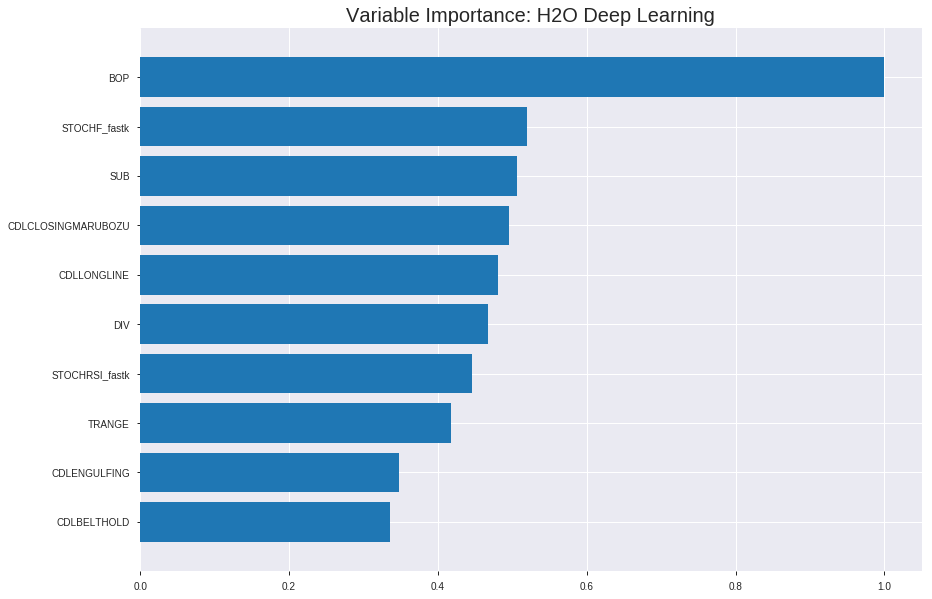

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_144729_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20822605811854913
RMSE: 0.4563179353461237
LogLoss: 0.603232731823908
Mean Per-Class Error: 0.31019157088122606
AUC: 0.7503157616594002
pr_auc: 0.7350938284914241
Gini: 0.5006315233188003
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41023064610312865: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      371  470   0.5589   (470.0/841.0)
1      92   808   0.1022   (92.0/900.0)
Total  463  1278  0.3228   (562.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410231     0.741965  244
max f2                       0.293875     0.855521  305
max f0point5                 0.524398     0.6987    164
max accuracy                 0.505526     0.690982  178
max precision                0.825728     1         0
max recall                   0.0737707    1         386
max specificity              0.825728     1         0
max absolute_mcc             0.431478     0.385543  233
max min_per_class_accuracy   0.518517     0.682521  168
max mean_per_class_accuracy  0.505526     0.689808  178

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 47.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.770849           1.93444   1.93444            1                0.791906  1                           0.791906            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.719311           1.47928   1.71337            0.764706         0.743539  0.885714                    0.768413            0.0144444       0.0344444                  47.9281   71.3365
    3        0.0304423                   0.694283           1.61204   1.67895            0.833333         0.703833  0.867925                    0.74648             0.0166667       0.0511111                  61.2037   67.8952
    4        0.0402068                   0.682462           1.47928   1.63046            0.764706         0.688783  0.842857                    0.732468            0.0144444       0.0655556                  47.9281   63.046
    5        0.0505457                   0.664856           1.50457   1.60471            0.777778         0.674591  0.829545                    0.72063             0.0155556       0.0811111                  50.4568   60.471
    6        0.100517                    0.625221           1.57868   1.59177            0.816092         0.64117   0.822857                    0.681127            0.0788889       0.16                       57.8685   59.1771
    7        0.150488                    0.603523           1.51198   1.56528            0.781609         0.61436   0.80916                     0.658956            0.0755556       0.235556                   51.198    56.5276
    8        0.20046                     0.589928           1.35633   1.51319            0.701149         0.595977  0.782235                    0.643257            0.0677778       0.303333                   35.6335   51.319
    9        0.300402                    0.569647           1.34522   1.45731            0.695402         0.578896  0.753346                    0.621844            0.134444        0.437778                   34.5217   45.7306
    10       0.400345                    0.551114           1.20069   1.39324            0.62069          0.560293  0.72023                     0.606478            0.12            0.557778                   20.069    39.3244
    11       0.500287                    0.519808           1.21181   1.357              0.626437         0.537263  0.701493                    0.592651            0.121111        0.678889                   21.1807   35.6998
    12       0.60023                     0.477905           0.922752  1.28469            0.477011         0.500152  0.664115                    0.577249            0.0922222       0.771111                   -7.72478  28.4693
    13       0.700172                    0.432353           0.989457  1.24255            0.511494         0.455829  0.64233                     0.559918            0.0988889       0.87                       -1.05428  24.2551
    14       0.800115                    0.358481           0.700402  1.17483            0.362069         0.395842  0.607322                    0.539423            0.07            0.94                       -29.9598  17.4831
    15       0.900057                    0.254404           0.40023   1.08882            0.206897         0.31084   0.562859                    0.514041            0.04            0.98                       -59.977   8.88194
    16       1                           0.00143495         0.200115  1                  0.103448         0.155433  0.516944                    0.478201            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3686834173234629
RMSE: 0.6071930642913034
LogLoss: 8.851922693678915
Mean Per-Class Error: 0.40295784426110404
AUC: 0.5755283594620341
pr_auc: 0.6284079278079681
Gini: 0.15105671892406813
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.2681496244705557e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    241  1        (241.0/241.0)
1      0    257  0        (0.0/257.0)
Total  0    498  0.4839   (241.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.26815e-48  0.680795  264
max f2                       1.26815e-48  0.842071  264
max f0point5                 0.33146      0.593395  175
max accuracy                 0.389741     0.590361  144
max precision                0.543149     0.878049  38
max recall                   1.26815e-48  1         264
max specificity              0.738455     0.995851  0
max absolute_mcc             0.529689     0.238958  46
max min_per_class_accuracy   1.43644e-07  0.522822  247
max mean_per_class_accuracy  0.389741     0.597042  144

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 18.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.594281           1.16265   1.16265            0.6              0.641033     0.6                         0.641033            0.0116732       0.0116732                  16.2646   16.2646
    2        0.0200803                   0.584805           1.93774   1.55019            1                0.590396     0.8                         0.615714            0.0194553       0.0311284                  93.7743   55.0195
    3        0.0301205                   0.570071           1.93774   1.67938            1                0.57705      0.866667                    0.602826            0.0194553       0.0505837                  93.7743   67.9377
    4        0.0401606                   0.562032           1.16265   1.55019            0.6              0.566974     0.8                         0.593863            0.0116732       0.0622568                  16.2646   55.0195
    5        0.0502008                   0.557817           1.55019   1.55019            0.8              0.560084     0.8                         0.587107            0.0155642       0.077821                   55.0195   55.0195
    6        0.100402                    0.526249           1.78272   1.66646            0.92             0.545195     0.86                        0.566151            0.0894942       0.167315                   78.2724   66.6459
    7        0.150602                    0.477888           1.08514   1.47268            0.56             0.499515     0.76                        0.543939            0.0544747       0.22179                    8.51362   47.2685
    8        0.200803                    0.447649           1.24016   1.41455            0.64             0.459529     0.73                        0.522836            0.0622568       0.284047                   24.0156   41.4553
    9        0.301205                    0.385612           1.08514   1.30475            0.56             0.415122     0.673333                    0.486931            0.108949        0.392996                   8.51362   30.4747
    10       0.399598                    0.24887            0.790916  1.17823            0.408163         0.328696     0.60804                     0.447969            0.077821        0.470817                   -20.9084  17.8226
    11       0.5                         6.28463e-07        0.503813  1.0428             0.26             0.107557     0.538153                    0.379613            0.0505837       0.521401                   -49.6187  4.28016
    12       0.600402                    1.72673e-204       1.12389   1.05636            0.58             2.92146e-09  0.545151                    0.316133            0.11284         0.634241                   12.3891   5.63617
    13       1                           0                  0.915316  1                  0.472362         2.9652e-206  0.516064                    0.189807            0.365759        1                          -8.46841  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:56:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 14:56:44  4 min 41.298 sec  339 obs/sec       0.295807  1             515        0.633042         1.77666             -0.604812      0.603707        0.572464           1.28963          0.472142                         0.683387           11.1505               -0.870002        0.484799          0.23344              0.955129           0.465863
    2019-08-28 14:57:07  5 min  4.447 sec  454 obs/sec       5.84951   20            10184      0.50773          0.71611             -0.0323455     0.582654        0.578069           1.28963          0.464675                         0.622862           9.76127               -0.553432        0.494696          0.257698             0.946684           0.471888
    2019-08-28 14:57:31  5 min 28.122 sec  487 obs/sec       12.2659   42            21355      0.488999         0.671103            0.0424186      0.641048        0.621275           1.28963          0.398621                         0.624255           9.63461               -0.560389        0.503657          0.261662             0.953733           0.437751
    2019-08-28 14:57:54  5 min 50.933 sec  489 obs/sec       18.0936   62            31501      0.477898         0.64794             0.085402       0.692832        0.69357            1.82698          0.387134                         0.618471           9.50101               -0.531605        0.50461           0.268647             0.957383           0.459839
    2019-08-28 14:58:16  6 min 13.568 sec  498 obs/sec       24.2665   83            42248      0.46016          0.611952            0.152036       0.730853        0.706185           1.50457          0.338311                         0.610393           9.21751               -0.491859        0.523815          0.278309             0.953118           0.445783
    2019-08-28 14:58:39  6 min 36.046 sec  504 obs/sec       30.4279   104           52975      0.456318         0.603233            0.166138       0.750316        0.735094           1.93444          0.322803                         0.607193           8.85192               -0.476258        0.575528          0.628408             1.16265            0.483936
    2019-08-28 14:59:02  6 min 59.613 sec  509 obs/sec       36.9299   126           64295      0.450316         0.591111            0.187931       0.765732        0.754592           1.82698          0.323952                         0.612816           9.47082               -0.503728        0.57037           0.620322             1.16265            0.483936
    2019-08-28 14:59:26  7 min 23.184 sec  512 obs/sec       43.4434   148           75635      0.446638         0.58284             0.201139       0.761768        0.754689           1.93444          0.332567                         0.624114           9.69233               -0.559684        0.576505          0.63114              1.16265            0.483936
    2019-08-28 14:59:49

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.006166970760844866
STOCHF_fastk              0.5195239186286926     0.5195239186286926   0.003203888815742695
SUB                       0.5057330131530762     0.5057330131530762   0.003118840704908993
CDLCLOSINGMARUBOZU        0.49580255150794983    0.49580255150794983  0.0030575998383018076
CDLLONGLINE               0.48054039478302       0.48054039478302     0.0029634785640317335
---                       ---                    ---                  ---
BBANDS_middleband_30_6_3  0.13084957003593445    0.13084957003593445  0.0008069454724807303
EMA_24                    0.12990523874759674    0.12990523874759674  0.0008011218090370007
CDLHARAMICROSS            0.12557125091552734    0.12557125091552734  0.0007743942327987713
CDLDOJISTAR               0.1254546046257019     0.1254546046257019   0.0007736748785400568
CDLSEPARATINGLINES        0.11718183755874634    0.11718183755874634  0.0007226569659268614


See the whole table with table.as_data_frame()


('accuracy', 0.6144578313253012)

('F1', 0.6356164383561644)

('auc', 0.5566502463054187)

('logloss', 6.022955449275047)

('mean_per_class_error', 0.406630801140783)

('rmse', 0.5795703004149432)

('mse', 0.3359017331230674)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


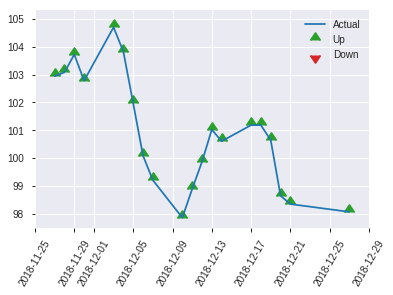


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3359017331230674
RMSE: 0.5795703004149432
LogLoss: 6.022955449275047
Mean Per-Class Error: 0.406630801140783
AUC: 0.5566502463054187
pr_auc: 0.5751689326362484
Gini: 0.11330049261083741
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.9558968492154883e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    116  0        (0.0/116.0)
Total  0    249  0.5341   (133.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.9559e-50   0.635616  184
max f2                       1.9559e-50   0.813464  184
max f0point5                 0.425385     0.55      45
max accuracy                 0.442718     0.614458  41
max precision                0.554573     1         0
max recall                   1.9559e-50   1         184
max specificity              0.554573     1         0
max absolute_mcc             0.442718     0.245823  41
max min_per_class_accuracy   0.191958     0.525862  119
max mean_per_class_accuracy  0.425385     0.593369  45

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 19.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.543623           2.14655   2.14655            1                0.549092      1                           0.549092            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.518846           2.14655   2.14655            1                0.532         1                           0.542255            0.0172414       0.0431034                  114.655   114.655
    3        0.0321285                   0.513512           2.14655   2.14655            1                0.516757      1                           0.532693            0.0258621       0.0689655                  114.655   114.655
    4        0.0401606                   0.508301           0         1.71724            0                0.512087      0.8                         0.528572            0               0.0689655                  -100      71.7241
    5        0.0522088                   0.506623           2.14655   1.81631            1                0.50759       0.846154                    0.52373             0.0258621       0.0948276                  114.655   81.6313
    6        0.100402                    0.47488            0.894397  1.37379            0.416667         0.493289      0.64                        0.509118            0.0431034       0.137931                   -10.5603  37.3793
    7        0.15261                     0.448623           1.81631   1.52518            0.846154         0.457149      0.710526                    0.491339            0.0948276       0.232759                   81.6313   52.5181
    8        0.200803                    0.417258           1.25216   1.45966            0.583333         0.431832      0.68                        0.477057            0.0603448       0.293103                   25.2155   45.9655
    9        0.301205                    0.352261           0.944483  1.28793            0.44             0.385327      0.6                         0.446481            0.0948276       0.387931                   -5.55172  28.7931
    10       0.401606                    0.274743           0.601034  1.11621            0.28             0.317819      0.52                        0.414315            0.0603448       0.448276                   -39.8966  11.6207
    11       0.502008                    0.165959           0.772759  1.04752            0.36             0.227621      0.488                       0.376976            0.0775862       0.525862                   -22.7241  4.75172
    12       0.598394                    0.0052224          0.894397  1.02285            0.416667         0.0814435     0.47651                     0.329374            0.0862069       0.612069                   -10.5603  2.28535
    13       0.698795                    2.11387e-13        0.858621  0.999257           0.4              0.00052861    0.465517                    0.282126            0.0862069       0.698276                   -14.1379  -0.0743163
    14       0.799197                    4.89694e-233       0.944483  0.992376           0.44             2.04064e-15   0.462312                    0.246683            0.0948276       0.793103                   -5.55172  -0.762433
    15       1                           0                  1.03034   1                  0.48             4.68765e-264  0.465863                    0.197148            0.206897        1                          3.03448   0

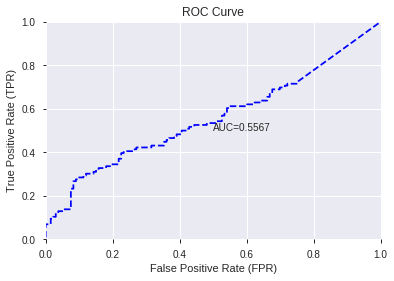

This function is available for GLM models only


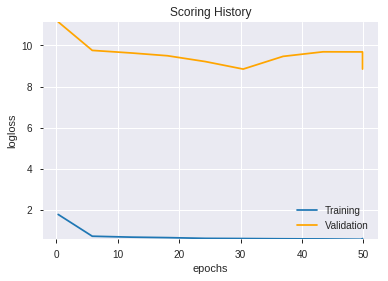

--2019-08-28 15:10:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_144729_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_144729_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_151021_model_6  0.739500  0.623477              0.318188  0.464146  0.215431
1               DeepLearning_1_AutoML_20190828_151021  0.739435  0.633594              0.325609  0.466290  0.217426
2  DeepLearning_grid_1_AutoML_20190828_151021_model_8  0.738527  0.626012              0.305808  0.466412  0.217540
3  DeepLearning_grid_1_AutoML_20190828_151021_model_7  0.738074  0.734745              0.353027  0.488707  0.238834
4  DeepLearning_grid_1_AutoML_20190828_151021_model_5  0.735611  0.628072              0.331022  0.468829  0.219801
5  DeepLearning_grid_1_AutoML_20190828_151021_model_9  0.732564  0.611169              0.308109  0.459610  0.211242
6  DeepLearning_grid_1_AutoML_20190828_151021_model_3  0.720962  0.695444              0.346059  0.472242  0.223012
7  DeepLearning_grid_1_AutoML_20190828_151021_model_2  0.686609  0.770743              0.402904  0.503846  0.253861
8  DeepLearning_grid_1_AutoML_20190828_151021_model_1  0.683238  0.891080              0.426465  0.505293  0.255321
9  DeepLearning_grid_1_AutoML_20190828_151021_model_4  0.664182  0.842716              0.397038  0.519221  0.269591

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.043708
1     CDLCLOSINGMARUBOZU             0.714143           0.714143    0.031214
2                    SUB             0.626628           0.626628    0.027389
3              CORREL_14             0.557205           0.557205    0.024354
4            CDLLONGLINE             0.550614           0.550614    0.024066
5           CDLENGULFING             0.545316           0.545316    0.023835
6            CDLMARUBOZU             0.537604           0.537604    0.023498
7           STOCHF_fastk             0.527590           0.527590    0.023060
8         STOCHRSI_fastk             0.508953           0.508953    0.022245
9                 TRANGE             0.493759           0.493759    0.021581
10                   DIV             0.474736           0.474736    0.020750
11            aroonup_14             0.467918           0.467918    0.020452
12                   SIN             0.460141           0.460141    0.020112
13        CDLRICKSHAWMAN             0.458959           0.458959    0.020060
14             dayofweek             0.448439           0.448439    0.019600
15           CDLBELTHOLD             0.445967           0.445967    0.019492
16          weekday_name             0.444405           0.444405    0.019424
17               WILLR_8             0.437796           0.437796    0.019135
18                SAREXT             0.437008           0.437008    0.019101
19                Volume             0.436938           0.436938    0.019098
20         days_in_month             0.435693           0.435693    0.019043
21               weekday             0.435396           0.435396    0.019030
22                   day             0.432711           0.432711    0.018913
23          CDLSHORTLINE             0.429651           0.429651    0.018779
24           STOCH_slowd             0.426899           0.426899    0.018659
25               CDLDOJI             0.426366           0.426366    0.018636
26              WILLR_12             0.422264           0.422264    0.018456
27              WILLR_20             0.421305           0.421305    0.018415
28             CDLTAKURI             0.421023           0.421023    0.018402
29             dayofyear             0.417556           0.417556    0.018251
30                 month             0.416196           0.416196    0.018191
31            AROONOSC_8             0.415711           0.415711    0.018170
32        STOCHRSI_fastd             0.414658           0.414658    0.018124
33           aroondown_8             0.410700           0.410700    0.017951
34               quarter             0.410266           0.410266    0.017932
35      CDLDRAGONFLYDOJI             0.407576           0.407576    0.017814
36            weekofyear             0.407083           0.407083    0.017793
37          MACDEXT_hist             0.406924           0.406924    0.017786
38              WILLR_30             0.405901           0.405901    0.017741
39                  week             0.405534           0.405534    0.017725
40              WILLR_24             0.404754           0.404754    0.017691
41     CDLLONGLEGGEDDOJI             0.404542           0.404542    0.017682
42              WILLR_14             0.403459           0.403459    0.017634
43                   OBV             0.401997           0.401997    0.017571
44  HT_PHASOR_quadrature             0.394029           0.394029    0.017222
45                 RSI_8             0.393077           0.393077    0.017181
46     CDLDARKCLOUDCOVER             0.390225           0.390225    0.017056
47                ULTOSC             0.386510           0.386510    0.016894
48                 ADOSC             0.380915           0.380915    0.016649
49     CDLINVERTEDHAMMER             0.375919           0.375919    0.016431

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_151021_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19587395523352974
RMSE: 0.44257649647663144
LogLoss: 0.5766526534017831
Mean Per-Class Error: 0.29454815695600467
AUC: 0.7701334390276127
pr_auc: 0.7535736089290177
Gini: 0.5402668780552253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36216073283249184: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      343  498   0.5922   (498.0/841.0)
1      57   843   0.0633   (57.0/900.0)
Total  400  1341  0.3188   (555.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362161     0.752343  277
max f2                       0.230213     0.861899  321
max f0point5                 0.585756     0.710041  188
max accuracy                 0.585756     0.707639  188
max precision                0.989239     1         0
max recall                   0.0405702    1         390
max specificity              0.989239     1         0
max absolute_mcc             0.510281     0.415275  224
max min_per_class_accuracy   0.62231      0.694411  169
max mean_per_class_accuracy  0.585756     0.705452  188

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 57.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.976424           1.82698   1.82698            0.944444         0.98199    0.944444                    0.98199             0.0188889       0.0188889                  82.6975   82.6975
    2        0.0201034                   0.970142           1.70686   1.76863            0.882353         0.973241   0.914286                    0.97774             0.0166667       0.0355556                  70.6863   76.8635
    3        0.0304423                   0.958613           1.61204   1.71545            0.833333         0.965256   0.886792                    0.9735              0.0166667       0.0522222                  61.2037   71.5451
    4        0.0402068                   0.93078            1.47928   1.6581             0.764706         0.945594   0.857143                    0.966723            0.0144444       0.0666667                  47.9281   65.8095
    5        0.0505457                   0.915035           1.82698   1.69264            0.944444         0.922392   0.875                       0.957655            0.0188889       0.0855556                  82.6975   69.2639
    6        0.100517                    0.870736           1.48974   1.59177            0.770115         0.891916   0.822857                    0.924973            0.0744444       0.16                       48.9745   59.1771
    7        0.150488                    0.837194           1.57868   1.58743            0.816092         0.852786   0.820611                    0.901003            0.0788889       0.238889                   57.8685   58.7426
    8        0.20046                     0.796607           1.44527   1.55199            0.747126         0.818246   0.802292                    0.880373            0.0722222       0.311111                   44.5275   55.199
    9        0.300402                    0.73406            1.41192   1.50539            0.729885         0.764448   0.778203                    0.841805            0.141111        0.452222                   41.1922   50.539
    10       0.400345                    0.673603           1.18957   1.42655            0.614943         0.704465   0.737446                    0.807519            0.118889        0.571111                   18.9572   42.6549
    11       0.500287                    0.62623            1.1451    1.37032            0.591954         0.647951   0.708381                    0.775642            0.114444        0.685556                   14.5102   37.0324
    12       0.60023                     0.565401           1.06728   1.31986            0.551724         0.596109   0.682297                    0.745749            0.106667        0.792222                   6.72797   31.9865
    13       0.700172                    0.477541           0.878282  1.25683            0.454023         0.524907   0.649713                    0.714226            0.0877778       0.88                       -12.1718  25.6833
    14       0.800115                    0.301397           0.689285  1.18594            0.356322         0.39719    0.613065                    0.674625            0.0688889       0.948889                   -31.0715  18.5941
    15       0.900057                    0.161735           0.389112  1.09746            0.201149         0.229195   0.567326                    0.625164            0.0388889       0.987778                   -61.0888  9.74608
    16       1                           0.00509227         0.122292  1                  0.0632184        0.0986151  0.516944                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20664499676768786
RMSE: 0.454582222230135
LogLoss: 0.6106114645929087
Mean Per-Class Error: 0.2867349080517301
AUC: 0.7515782165749068
pr_auc: 0.7219075095990477
Gini: 0.5031564331498135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46606052239352797: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  129  0.5353   (129.0/241.0)
1      31   226  0.1206   (31.0/257.0)
Total  143  355  0.3213   (160.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466061     0.738562  270
max f2                       0.147475     0.852921  366
max f0point5                 0.636079     0.726016  173
max accuracy                 0.609288     0.712851  188
max precision                0.983238     1         0
max recall                   0.0357728    1         395
max specificity              0.983238     1         0
max absolute_mcc             0.609288     0.426341  188
max min_per_class_accuracy   0.605642     0.70428   190
max mean_per_class_accuracy  0.609288     0.713265  188

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 56.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.975797           1.93774   1.93774            1                0.978224  1                           0.978224            0.0194553       0.0194553                  93.7743   93.7743
    2        0.0200803                   0.962925           0.775097  1.35642            0.4              0.970894  0.7                         0.974559            0.0077821       0.0272374                  -22.4903  35.642
    3        0.0301205                   0.933211           1.93774   1.55019            1                0.951067  0.8                         0.966729            0.0194553       0.0466926                  93.7743   55.0195
    4        0.0401606                   0.911451           1.55019   1.55019            0.8              0.92469   0.8                         0.956219            0.0155642       0.0622568                  55.0195   55.0195
    5        0.0502008                   0.905879           1.16265   1.47268            0.6              0.909155  0.76                        0.946806            0.0116732       0.07393                    16.2646   47.2685
    6        0.100402                    0.855092           1.47268   1.47268            0.76             0.877487  0.76                        0.912146            0.07393         0.14786                    47.2685   47.2685
    7        0.150602                    0.804754           1.39518   1.44685            0.72             0.829121  0.746667                    0.884471            0.0700389       0.217899                   39.5175   44.6848
    8        0.200803                    0.769058           1.39518   1.43393            0.72             0.78141   0.74                        0.858706            0.0700389       0.287938                   39.5175   43.393
    9        0.301205                    0.720735           1.58895   1.4856             0.82             0.741927  0.766667                    0.81978             0.159533        0.447471                   58.8949   48.5603
    10       0.399598                    0.661711           1.30501   1.44114            0.673469         0.688658  0.743719                    0.787494            0.128405        0.575875                   30.5011   44.1136
    11       0.5                         0.605642           1.27891   1.40856            0.66             0.636712  0.726908                    0.757216            0.128405        0.70428                    27.8911   40.856
    12       0.600402                    0.558865           0.775097  1.30263            0.4              0.581422  0.672241                    0.727819            0.077821        0.782101                   -22.4903  30.263
    13       0.698795                    0.477318           0.830461  1.23615            0.428571         0.519538  0.637931                    0.698492            0.0817121       0.863813                   -16.9539  23.6147
    14       0.799197                    0.320652           0.620078  1.15875            0.32             0.401177  0.59799                     0.661141            0.0622568       0.92607                    -37.9922  15.8751
    15       0.899598                    0.173484           0.387549  1.07268            0.2              0.246045  0.553571                    0.614813            0.0389105       0.964981                   -61.2451  7.26793
    16       1                           0.00490022         0.348794  1                  0.18             0.102673  0.516064                    0.563394            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:13:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:13:22  1 min 15.629 sec  900 obs/sec       1         1             1741       0.517944         1.02131             -0.0742977     0.72643         0.668439           1.3971           0.329696                         0.528023           1.07861               -0.116384        0.701826          0.678235             1.16265            0.335341
    2019-08-28 15:13:28  1 min 21.486 sec  1676 obs/sec      7         7             12187      0.454551         0.601566            0.172582       0.752043        0.735268           1.71951          0.329696                         0.456542           0.612365              0.165417         0.747518          0.717216             1.93774            0.301205
    2019-08-28 15:13:34  1 min 27.101 sec  2254 obs/sec      16        16            27856      0.442576         0.576653            0.215603       0.770133        0.753574           1.82698          0.318782                         0.454582           0.610611              0.172566         0.751578          0.721908             1.93774            0.321285
    2019-08-28 15:13:39  1 min 32.658 sec  2504 obs/sec      25        25            43525      0.438494         0.570108            0.230009       0.779279        0.762548           1.82698          0.313613                         0.461099           0.637213              0.148672         0.737007          0.703353             1.93774            0.313253
    2019-08-28 15:13:45  1 min 37.983 sec  2667 obs/sec      34        34            59194      0.43172          0.552305            0.253615       0.7925          0.780895           1.93444          0.286617                         0.462406           0.637317              0.143837         0.738912          0.704919             1.93774            0.309237
    2019-08-28 15:13:50  1 min 43.308 sec  2775 obs/sec      43        43            74863      0.423251         0.534631            0.282609       0.806766        0.78876            1.93444          0.27398                          0.458974           0.632501              0.1565           0.745839          0.719243             1.93774            0.303213
    2019-08-28 15:13:56  1 min 48.921 sec  2877 obs/sec      53        53            92273      0.415618         0.516595            0.308252       0.817644        0.802625           1.93444          0.265365                         0.460871           0.637651              0.149514         0.738646          0.70768              1.93774            0.315261
    2019-08-28 15:13:56  1 min 49.462 sec  2875 obs/sec      53        53            92273      0.442576         0.576653            0.215603       0.770133        0.753574           1.82698          0.318782                         0.454582           0.610611              0.172566         0.751578          0.721908             1.93774            0.321285

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.0437082839506902
CDLCLOSINGMARUBOZU  0.7141428589820862     0.7141428589820862   0.03121395886174673
SUB                 0.6266282796859741     0.6266282796859741   0.02738884678004707
CORREL_14           0.5572047829627991     0.5572047829627991   0.024354464872420725
CDLLONGLINE         0.5506141185760498     0.5506141185760498   0.024066398241980987
---                 ---                    ---                  ---
RSI_8               0.393076628446579      0.393076628446579    0.01718070489052302
CDLDARKCLOUDCOVER   0.3902246057987213     0.3902246057987213   0.01705604787479666
ULTOSC              0.3865097463130951     0.3865097463130951   0.016893677741561995
ADOSC               0.3809150755405426     0.3809150755405426   0.016649144282824643
CDLINVERTEDHAMMER   0.37591904401779175    0.37591904401779175  0.01643077631840165


See the whole table with table.as_data_frame()


('accuracy', 0.6987951807228916)

('F1', 0.7050359712230215)

('auc', 0.7394996110967073)

('logloss', 0.6234769674226331)

('mean_per_class_error', 0.29738138449572205)

('rmse', 0.4641455626059075)

('mse', 0.21543110328675438)

deeplearning prediction progress: |███████████████████████████████████████| 100%


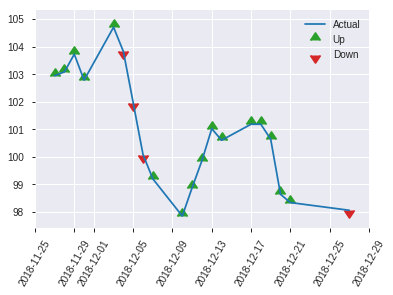


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21543110328675438
RMSE: 0.4641455626059075
LogLoss: 0.6234769674226331
Mean Per-Class Error: 0.29738138449572205
AUC: 0.7394996110967073
pr_auc: 0.6804533977942686
Gini: 0.4789992221934145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4919266611252487: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   64   0.4812   (64.0/133.0)
1      18   98   0.1552   (18.0/116.0)
Total  87   162  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491927     0.705036  161
max f2                       0.11502      0.828571  235
max f0point5                 0.563885     0.671296  132
max accuracy                 0.563885     0.698795  132
max precision                0.980298     1         0
max recall                   0.11502      1         235
max specificity              0.980298     1         0
max absolute_mcc             0.560602     0.405737  134
max min_per_class_accuracy   0.597327     0.681034  118
max mean_per_class_accuracy  0.560602     0.702619  134

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 53.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.96815            1.43103   1.43103            0.666667         0.972639  0.666667                    0.972639            0.0172414       0.0172414                  43.1034   43.1034
    2        0.0200803                   0.925552           1.07328   1.28793            0.5              0.958434  0.6                         0.966957            0.00862069      0.0258621                  7.32759   28.7931
    3        0.0321285                   0.900602           2.14655   1.60991            1                0.920787  0.75                        0.949643            0.0258621       0.0517241                  114.655   60.9914
    4        0.0401606                   0.873583           2.14655   1.71724            1                0.879262  0.8                         0.935567            0.0172414       0.0689655                  114.655   71.7241
    5        0.0522088                   0.863802           2.14655   1.81631            1                0.869174  0.846154                    0.920246            0.0258621       0.0948276                  114.655   81.6313
    6        0.100402                    0.798149           1.60991   1.71724            0.75             0.823593  0.8                         0.873852            0.0775862       0.172414                   60.9914   71.7241
    7        0.15261                     0.765336           1.48607   1.63816            0.692308         0.780425  0.763158                    0.84189             0.0775862       0.25                       48.6074   63.8158
    8        0.200803                    0.733166           1.60991   1.63138            0.75             0.750145  0.76                        0.819871            0.0775862       0.327586                   60.9914   63.1379
    9        0.301205                    0.693699           1.20207   1.48828            0.56             0.715521  0.693333                    0.785088            0.12069         0.448276                   20.2069   48.8276
    10       0.401606                    0.650437           1.37379   1.45966            0.64             0.674147  0.68                        0.757353            0.137931        0.586207                   37.3793   45.9655
    11       0.502008                    0.590177           1.11621   1.39097            0.52             0.613145  0.648                       0.728511            0.112069        0.698276                   11.6207   39.0966
    12       0.598394                    0.519102           0.894397  1.31098            0.416667         0.553718  0.610738                    0.700356            0.0862069       0.784483                   -10.5603  31.0981
    13       0.698795                    0.447986           0.686897  1.22131            0.32             0.490737  0.568966                    0.670239            0.0689655       0.853448                   -31.3103  22.1314
    14       0.799197                    0.282182           0.601034  1.14339            0.28             0.384266  0.532663                    0.634312            0.0603448       0.913793                   -39.8966  14.3389
    15       0.899598                    0.168356           0.515172  1.07328            0.24             0.223526  0.5                         0.588466            0.0517241       0.965517                   -48.4828  7.32759
    16       1                           0.0225329          0.343448  1                  0.16             0.104412  0.465863                    0.539866         

This function is available for GLM models only


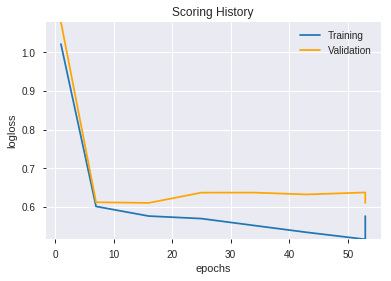

--2019-08-28 15:16:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_151021_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_151021_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CORREL_14',
 'CDLLONGLINE',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'TRANGE',
 'DIV',
 'aroonup_14',
 'SIN',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'CDLBELTHOLD',
 'weekday_name',
 'WILLR_8',
 'SAREXT',
 'Volume',
 'days_in_month',
 'weekday',
 'day',
 'CDLSHORTLINE',
 'STOCH_slowd',
 'CDLDOJI',
 'WILLR_12',
 'WILLR_20',
 'CDLTAKURI',
 'dayofyear',
 'month',
 'AROONOSC_8',
 'STOCHRSI_fastd',
 'aroondown_8',
 'quarter',
 'CDLDRAGONFLYDOJI',
 'weekofyear',
 'MACDEXT_hist',
 'WILLR_30',
 'week',
 'WILLR_24',
 'CDLLONGLEGGEDDOJI',
 'WILLR_14',
 'OBV',
 'HT_PHASOR_quadrature',
 'RSI_8',
 'CDLDARKCLOUDCOVER',
 'ULTOSC',
 'ADOSC',
 'CDLINVERTEDHAMMER']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_151704_model_1  0.747083  0.593552              0.315984  0.451463  0.203819

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.513922           1.000000    0.132654
1                    SUB             0.317473           0.617745    0.081946
2           STOCHF_fastk             0.231162           0.449799    0.059668
3                 ULTOSC             0.185391           0.360738    0.047853
4                  RSI_8             0.182708           0.355516    0.047161
5               WILLR_12             0.133039           0.258871    0.034340
6            STOCH_slowd             0.125304           0.243819    0.032344
7                quarter             0.118867           0.231293    0.030682
8                 TRANGE             0.114189           0.222190    0.029474
9     CDLCLOSINGMARUBOZU             0.108565           0.211247    0.028023
10                SAREXT             0.099241           0.193104    0.025616
11          MACDEXT_hist             0.095537           0.185898    0.024660
12          CDLENGULFING             0.095003           0.184859    0.024522
13        STOCHRSI_fastd             0.092068           0.179149    0.023765
14           CDLMARUBOZU             0.089117           0.173406    0.023003
15            aroonup_14             0.087552           0.170360    0.022599
16                Volume             0.083433           0.162345    0.021536
17     CDLINVERTEDHAMMER             0.081340           0.158272    0.020995
18                   SIN             0.078927           0.153577    0.020373
19                   OBV             0.077002           0.149832    0.019876
20                   day             0.070434           0.137052    0.018181
21              WILLR_20             0.066575           0.129542    0.017184
22     CDLDARKCLOUDCOVER             0.065508           0.127466    0.016909
23            AROONOSC_8             0.063470           0.123501    0.016383
24              WILLR_30             0.056699           0.110327    0.014635
25           CDLBELTHOLD             0.054104           0.105277    0.013965
26           aroondown_8             0.052521           0.102197    0.013557
27              WILLR_14             0.051392           0.100000    0.013265
28             CDLTAKURI             0.047490           0.092408    0.012258
29      CDLDRAGONFLYDOJI             0.047472           0.092372    0.012254
30        CDLRICKSHAWMAN             0.045502           0.088538    0.011745
31  HT_PHASOR_quadrature             0.043041           0.083749    0.011110
32          weekday_name             0.032416           0.063076    0.008367
33             dayofyear             0.025528           0.049672    0.006589
34                  week             0.024776           0.048209    0.006395
35         days_in_month             0.024717           0.048094    0.006380
36            weekofyear             0.024552           0.047774    0.006337
37               WILLR_8             0.024023           0.046745    0.006201
38             CORREL_14             0.021766           0.042353    0.005618
39          CDLSHORTLINE             0.021564           0.041961    0.005566
40     CDLLONGLEGGEDDOJI             0.020011           0.038938    0.005165
41        STOCHRSI_fastk             0.018257           0.035525    0.004712
42                 month             0.018235           0.035482    0.004707
43                   DIV             0.015926           0.030989    0.004111
44                 ADOSC             0.008917           0.017350    0.002302
45              WILLR_24             0.008631           0.016794    0.002228
46           CDLLONGLINE             0.007030           0.013679    0.001815
47               CDLDOJI             0.002942           0.005725    0.000759
48               weekday             0.000468           0.000912    0.000121
49             dayofweek             0.000354           0.000688    0.000091

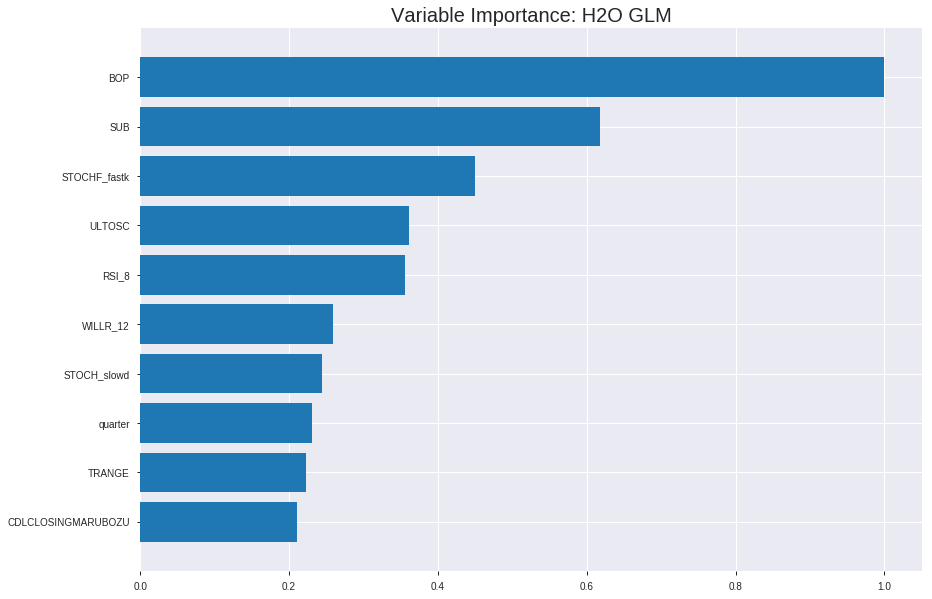

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_151704_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20049679519660216
RMSE: 0.44776868492180444
LogLoss: 0.5860745096005047
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2411.5386742145693
Residual deviance: 2040.711442428957
AIC: 2142.711442428957
AUC: 0.7529680274805126
pr_auc: 0.7286044662474307
Gini: 0.5059360549610252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3549387827614107: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      336  505   0.6005   (505.0/841.0)
1      68   832   0.0756   (68.0/900.0)
Total  404  1337  0.3291   (573.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354939     0.743853  278
max f2                       0.208607     0.858635  339
max f0point5                 0.577381     0.703125  163
max accuracy                 0.468379     0.697875  221
max precision                0.945206     1         0
max recall                   0.0884274    1         387
max specificity              0.945206     1         0
max absolute_mcc             0.468379     0.398407  221
max min_per_class_accuracy   0.537575     0.689655  186
max mean_per_class_accuracy  0.468379     0.694331  221

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.883969           1.50457   1.50457            0.777778         0.903621  0.777778                    0.903621            0.0155556       0.0155556                  50.4568   50.4568
    2        0.0201034                   0.863339           1.70686   1.60283            0.882353         0.872611  0.828571                    0.888559            0.0166667       0.0322222                  70.6863   60.2825
    3        0.0304423                   0.847555           1.71951   1.64245            0.888889         0.855919  0.849057                    0.877474            0.0177778       0.05                       71.9506   64.2453
    4        0.0402068                   0.833747           1.59307   1.63046            0.823529         0.839905  0.842857                    0.86835             0.0155556       0.0655556                  59.3072   63.046
    5        0.0505457                   0.823322           1.28963   1.56074            0.666667         0.828128  0.806818                    0.860122            0.0133333       0.0788889                  28.963    56.0745
    6        0.100517                    0.769183           1.60092   1.58072            0.827586         0.793001  0.817143                    0.826753            0.08            0.158889                   60.092    58.0717
    7        0.150488                    0.731562           1.26739   1.47668            0.655172         0.751191  0.763359                    0.801662            0.0633333       0.222222                   26.7395   47.6675
    8        0.20046                     0.700732           1.35633   1.44668            0.701149         0.716918  0.747851                    0.780537            0.0677778       0.29                       35.6335   44.6676
    9        0.300402                    0.650687           1.45639   1.44991            0.752874         0.676106  0.749522                    0.745793            0.145556        0.435556                   45.6392   44.9909
    10       0.400345                    0.601398           1.35633   1.42655            0.701149         0.625552  0.737446                    0.715776            0.135556        0.571111                   35.6335   42.6549
    11       0.500287                    0.541212           1.11175   1.36366            0.574713         0.572187  0.704937                    0.687091            0.111111        0.682222                   11.175    36.3661
    12       0.60023                     0.479569           1.01169   1.30506            0.522989         0.511839  0.674641                    0.65791             0.101111        0.783333                   1.16922   30.5056
    13       0.700172                    0.406702           0.833812  1.23779            0.431034         0.441581  0.639869                    0.627032            0.0833333       0.866667                   -16.6188  23.7791
    14       0.800115                    0.323457           0.744872  1.17622            0.385057         0.366878  0.60804                     0.594536            0.0744444       0.941111                   -25.5128  17.622
    15       0.900057                    0.210451           0.433582  1.09376            0.224138         0.268837  0.565412                    0.55837             0.0433333       0.984444                   -56.6418  9.37574
    16       1                           0.0269188          0.155645  1                  0.0804598        0.143875  0.516944                    0.516944           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2034532007613828
RMSE: 0.45105786852839935
LogLoss: 0.5936008900152406
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.8619915534578
Residual deviance: 591.2264864551797
AIC: 693.2264864551797
AUC: 0.7479374202818994
pr_auc: 0.7171266646643114
Gini: 0.4958748405637987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35290386736427604: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  132  0.5477   (132.0/241.0)
1      25   232  0.0973   (25.0/257.0)
Total  134  364  0.3153   (157.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352904     0.747182  283
max f2                       0.198456     0.85473   357
max f0point5                 0.4836       0.709434  207
max accuracy                 0.4836       0.702811  207
max precision                0.920596     1         0
max recall                   0.0805414    1         395
max specificity              0.920596     1         0
max absolute_mcc             0.4836       0.404567  207
max min_per_class_accuracy   0.502622     0.688797  196
max mean_per_class_accuracy  0.4836       0.701858  207

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 49.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.86845            1.55019   1.55019            0.8              0.892174  0.8                         0.892174            0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.844939           1.93774   1.74397            1                0.855111  0.9                         0.873643            0.0194553       0.0350195                  93.7743   74.3969
    3        0.0301205                   0.814195           1.16265   1.55019            0.6              0.830981  0.8                         0.859422            0.0116732       0.0466926                  16.2646   55.0195
    4        0.0401606                   0.802687           0.775097  1.35642            0.4              0.809273  0.7                         0.846885            0.0077821       0.0544747                  -22.4903  35.642
    5        0.0502008                   0.792947           1.16265   1.31767            0.6              0.79709   0.68                        0.836926            0.0116732       0.0661479                  16.2646   31.7665
    6        0.100402                    0.746831           1.6277    1.47268            0.84             0.771181  0.76                        0.804053            0.0817121       0.14786                    62.7704   47.2685
    7        0.150602                    0.710862           1.47268   1.47268            0.76             0.725888  0.76                        0.777998            0.07393         0.22179                    47.2685   47.2685
    8        0.200803                    0.681813           1.6277    1.51144            0.84             0.695275  0.78                        0.757317            0.0817121       0.303502                   62.7704   51.144
    9        0.301205                    0.634608           1.31767   1.44685            0.68             0.6553    0.746667                    0.723311            0.132296        0.435798                   31.7665   44.6848
    10       0.399598                    0.57341            1.30501   1.41192            0.673469         0.604719  0.728643                    0.69411             0.128405        0.564202                   30.5011   41.1923
    11       0.5                         0.505873           1.2014    1.36965            0.62             0.539609  0.706827                    0.663086            0.120623        0.684825                   20.1401   36.965
    12       0.600402                    0.452703           0.852607  1.28319            0.44             0.476744  0.662207                    0.631925            0.0856031       0.770428                   -14.7393  28.3188
    13       0.698795                    0.382627           1.06774   1.25285            0.55102          0.421032  0.646552                    0.60223             0.105058        0.875486                   6.7736    25.2851
    14       0.799197                    0.303292           0.542568  1.16362            0.28             0.338251  0.600503                    0.569067            0.0544747       0.929961                   -45.7432  16.362
    15       0.899598                    0.205075           0.503813  1.08998            0.26             0.253423  0.5625                      0.533839            0.0505837       0.980545                   -49.6187  8.99805
    16       1                           0.0230614          0.193774  1                  0.1              0.139334  0.516064                    0.49423             0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:17:05  0.000 sec   2            18        51            1.36646           1.36882
    2019-08-28 15:17:05  0.019 sec   4            11        51            1.35723           1.36055
    2019-08-28 15:17:05  0.035 sec   6            7.1       51            1.3447            1.34914
    2019-08-28 15:17:05  0.049 sec   8            4.4       51            1.32873           1.33423
    2019-08-28 15:17:05  0.062 sec   10           2.8       51            1.30959           1.31582
    2019-08-28 15:17:05  0.076 sec   12           1.7       51            1.28826           1.29459
    2019-08-28 15:17:05  0.089 sec   14           1.1       51            1.26636           1.27202
    2019-08-28 15:17:05  0.101 sec   16           0.66      51            1.24565           1.25006
    2019-08-28 15:17:05  0.114 sec   18           0.41      51            1.22754           1.23057
    2019-08-28 15:17:05  0.133 sec   20           0.25      51            1.21261           1.21473
    2019-08-28 15:17:05  0.149 sec   22           0.16      51            1.20067           1.20289
    2019-08-28 15:17:05  0.167 sec   24           0.098     51            1.19115           1.19479
    2019-08-28 15:17:05  0.200 sec   26           0.061     51            1.18349           1.1899
    2019-08-28 15:17:05  0.213 sec   28           0.038     51            1.17725           1.18761
    2019-08-28 15:17:05  0.226 sec   30           0.023     51            1.17215           1.1872
    2019-08-28 15:17:05  0.241 sec   32           0.015     51            1.16802           1.1881
    2019-08-28 15:17:05  0.254 sec   34           0.0091    51            1.16478           1.18989
    2019-08-28 15:17:05  0.273 sec   36           0.0056    51            1.16238           1.1922
    2019-08-28 15:17:05  0.294 sec   38           0.0035    51            1.16074           1.1947
    2019-08-28 15:17:05  0.308 sec   40           0.0022    51            1.1597            1.19709

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7132867132867132)

('auc', 0.7470832253046409)

('logloss', 0.5935517502206082)

('mean_per_class_error', 0.300589836660617)

('rmse', 0.451463493107194)

('mse', 0.20381928560854942)

glm prediction progress: |████████████████████████████████████████████████| 100%


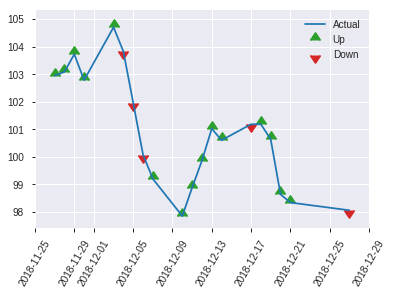


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20381928560854942
RMSE: 0.451463493107194
LogLoss: 0.5935517502206082
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 346.62607336051315
Residual deviance: 295.58877160986293
AIC: 397.58877160986293
AUC: 0.7470832253046409
pr_auc: 0.6973910690237917
Gini: 0.49416645060928177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3637126965555923: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   68   0.5113   (68.0/133.0)
1      14   102  0.1207   (14.0/116.0)
Total  79   170  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363713     0.713287  169
max f2                       0.220094     0.844347  216
max f0point5                 0.621914     0.672043  63
max accuracy                 0.471524     0.694779  133
max precision                0.878296     1         0
max recall                   0.0633763    1         247
max specificity              0.878296     1         0
max absolute_mcc             0.466321     0.40025   137
max min_per_class_accuracy   0.513078     0.663793  120
max mean_per_class_accuracy  0.466321     0.69941   137

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.826873           1.43103    1.43103            0.666667         0.86127   0.666667                    0.86127             0.0172414       0.0172414                  43.1034   43.1034
    2        0.0200803                   0.802375           2.14655    1.71724            1                0.810923  0.8                         0.841131            0.0172414       0.0344828                  114.655   71.7241
    3        0.0321285                   0.780331           1.43103    1.60991            0.666667         0.791545  0.75                        0.822537            0.0172414       0.0517241                  43.1034   60.9914
    4        0.0401606                   0.764678           2.14655    1.71724            1                0.778152  0.8                         0.81366             0.0172414       0.0689655                  114.655   71.7241
    5        0.0522088                   0.755216           2.14655    1.81631            1                0.758923  0.846154                    0.801028            0.0258621       0.0948276                  114.655   81.6313
    6        0.100402                    0.7163             2.14655    1.97483            1                0.733048  0.92                        0.768398            0.103448        0.198276                   114.655   97.4828
    7        0.15261                     0.6871             1.15584    1.69465            0.538462         0.702031  0.789474                    0.745693            0.0603448       0.258621                   15.5836   69.4646
    8        0.200803                    0.647992           1.60991    1.67431            0.75             0.664711  0.78                        0.726257            0.0775862       0.336207                   60.9914   67.431
    9        0.301205                    0.606956           1.37379    1.57414            0.64             0.62445   0.733333                    0.692322            0.137931        0.474138                   37.3793   57.4138
    10       0.401606                    0.546356           0.686897   1.35233            0.32             0.574338  0.63                        0.662826            0.0689655       0.543103                   -31.3103  35.2328
    11       0.502008                    0.491289           1.37379    1.35662            0.64             0.523035  0.632                       0.634868            0.137931        0.681034                   37.3793   35.6621
    12       0.598394                    0.440432           1.25216    1.33979            0.583333         0.467419  0.624161                    0.607896            0.12069         0.801724                   25.2155   33.9794
    13       0.698795                    0.353421           0.772759   1.25832            0.36             0.395411  0.586207                    0.577367            0.0775862       0.87931                    -22.7241  25.8323
    14       0.799197                    0.271967           0.42931    1.15418            0.2              0.313892  0.537688                    0.544267            0.0431034       0.922414                   -57.069   15.4176
    15       0.899598                    0.196252           0.686897   1.10202            0.32             0.231334  0.513393                    0.509341            0.0689655       0.991379                   -31.3103  10.2024
    16       1                           0.0301156          0.0858621  1                  0.04             0.136613  0.465863                    

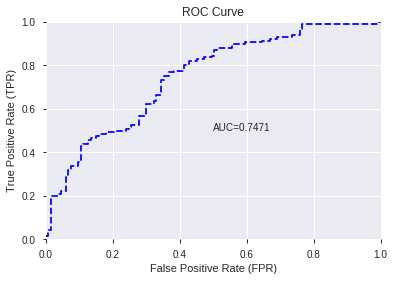

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


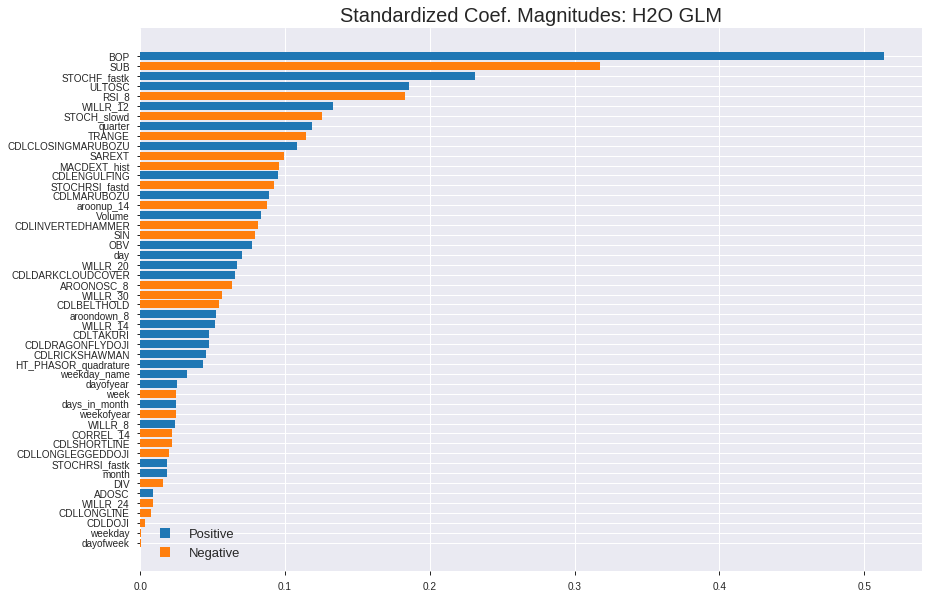

'log_likelihood'
--2019-08-28 15:17:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_151704_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_151704_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SUB',
 'STOCHF_fastk',
 'ULTOSC',
 'RSI_8',
 'WILLR_12',
 'STOCH_slowd',
 'quarter',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'SAREXT',
 'MACDEXT_hist',
 'CDLENGULFING',
 'STOCHRSI_fastd',
 'CDLMARUBOZU',
 'aroonup_14',
 'Volume',
 'CDLINVERTEDHAMMER',
 'SIN',
 'OBV',
 'day',
 'WILLR_20',
 'CDLDARKCLOUDCOVER',
 'AROONOSC_8',
 'WILLR_30',
 'CDLBELTHOLD',
 'aroondown_8',
 'WILLR_14',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'HT_PHASOR_quadrature',
 'weekday_name',
 'dayofyear',
 'week',
 'days_in_month',
 'weekofyear',
 'WILLR_8',
 'CORREL_14',
 'CDLSHORTLINE',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastk',
 'month',
 'DIV',
 'ADOSC',
 'WILLR_24',
 'CDLLONGLINE',
 'CDLDOJI',
 'weekday',
 'dayofweek']

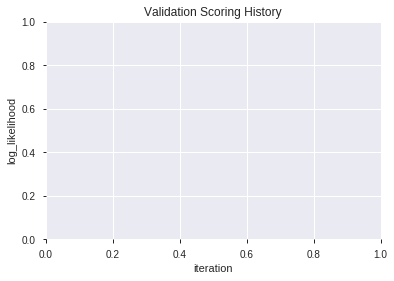

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_151721_model_7  0.752982  0.589322              0.319290  0.449940  0.202446
1  XGBoost_grid_1_AutoML_20190828_151721_model_4  0.746305  0.598030              0.306359  0.453966  0.206086
2  XGBoost_grid_1_AutoML_20190828_151721_model_3  0.745333  0.592729              0.327262  0.452268  0.204547
3               XGBoost_2_AutoML_20190828_151721  0.742611  0.599905              0.312873  0.454777  0.206823
4  XGBoost_grid_1_AutoML_20190828_151721_model_1  0.740213  0.612811              0.322498  0.458818  0.210514
5  XGBoost_grid_1_AutoML_20190828_151721_model_5  0.734768  0.611616              0.300136  0.458562  0.210279
6  XGBoost_grid_1_AutoML_20190828_151721_model_6  0.731073  0.606235              0.320294  0.457625  0.209420
7               XGBoost_3_AutoML_20190828_151721  0.728934  0.610881              0.323600  0.459549  0.211186
8  XGBoost_grid_1_AutoML_20190828_151721_model_2  0.726082  0.608560              0.326257  0.459359  0.211011
9               XGBoost_1_AutoML_20190828_151721  0.717786  0.616898              0.347712  0.463378  0.214719

variable  relative_importance  scaled_importance  percentage
0                    BOP          1605.671875           1.000000    0.158245
1           STOCHF_fastk           693.176331           0.431705    0.068315
2                    SUB           581.843750           0.362368    0.057343
3                 TRANGE           473.770813           0.295061    0.046692
4                    OBV           428.270844           0.266724    0.042208
5                 ULTOSC           342.309814           0.213188    0.033736
6                 Volume           335.655823           0.209044    0.033080
7              CORREL_14           334.496399           0.208322    0.032966
8                    SIN           321.309479           0.200109    0.031666
9                 SAREXT           320.318848           0.199492    0.031569
10                   DIV           317.072052           0.197470    0.031249
11        STOCHRSI_fastd           304.865540           0.189868    0.030046
12           STOCH_slowd           281.074310           0.175051    0.027701
13             dayofyear           262.278534           0.163345    0.025848
14          MACDEXT_hist           257.930237           0.160637    0.025420
15                 ADOSC           256.051086           0.159467    0.025235
16              WILLR_12           255.552551           0.159156    0.025186
17        STOCHRSI_fastk           243.158279           0.151437    0.023964
18                 RSI_8           225.701385           0.140565    0.022244
19               WILLR_8           221.962616           0.138237    0.021875
20                   day           206.293304           0.128478    0.020331
21            aroonup_14           184.307419           0.114785    0.018164
22              WILLR_20           182.040466           0.113373    0.017941
23              WILLR_30           179.285370           0.111658    0.017669
24            AROONOSC_8           176.563828           0.109963    0.017401
25              WILLR_14           176.449188           0.109891    0.017390
26  HT_PHASOR_quadrature           174.523315           0.108692    0.017200
27              WILLR_24           149.877701           0.093343    0.014771
28           aroondown_8           140.611404           0.087572    0.013858
29                  week           117.906906           0.073432    0.011620
30          weekday_name            86.527054           0.053888    0.008528
31    CDLCLOSINGMARUBOZU            77.388863           0.048197    0.007627
32             dayofweek            76.920837           0.047906    0.007581
33            weekofyear            37.980431           0.023654    0.003743
34               weekday            30.065159           0.018724    0.002963
35           CDLLONGLINE            22.126644           0.013780    0.002181
36                 month            20.588993           0.012823    0.002029
37               CDLDOJI            13.570419           0.008452    0.001337
38          CDLENGULFING            12.644997           0.007875    0.001246
39         days_in_month            10.081151           0.006278    0.000994
40     CDLLONGLEGGEDDOJI             3.534816           0.002201    0.000348
41               quarter             3.471595           0.002162    0.000342
42           CDLBELTHOLD             1.542978           0.000961    0.000152

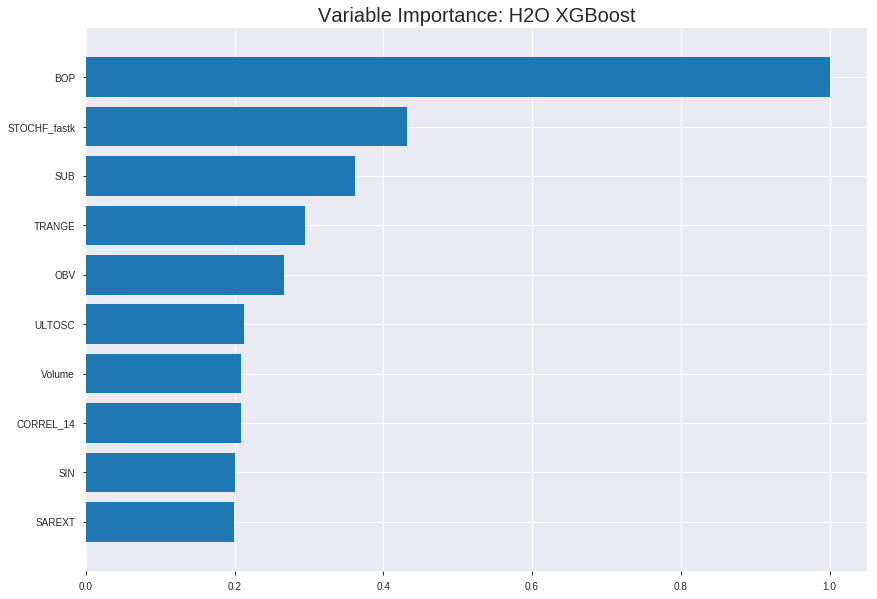

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_151721_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11575678018100534
RMSE: 0.3402304809698939
LogLoss: 0.392088509986573
Mean Per-Class Error: 0.10737746069493992
AUC: 0.9589992072929052
pr_auc: 0.964226184855123
Gini: 0.9179984145858104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5299190580844879: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      746  95   0.113    (95.0/841.0)
1      96   804  0.1067   (96.0/900.0)
Total  842  899  0.1097   (191.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529919     0.89383   188
max f2                       0.414097     0.918043  238
max f0point5                 0.625878     0.923626  143
max accuracy                 0.560866     0.891442  172
max precision                0.907248     1         0
max recall                   0.172024     1         342
max specificity              0.907248     1         0
max absolute_mcc             0.560866     0.785523  172
max min_per_class_accuracy   0.532032     0.888228  187
max mean_per_class_accuracy  0.560866     0.892623  172

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.882282           1.93444   1.93444            1                0.893767   1                           0.893767            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.870988           1.93444   1.93444            1                0.877192   1                           0.885716            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.860898           1.93444   1.93444            1                0.866141   1                           0.879068            0.02            0.0588889                  93.4444   93.4444
    4        0.0402068                   0.852743           1.93444   1.93444            1                0.856734   1                           0.873644            0.0188889       0.0777778                  93.4444   93.4444
    5        0.0505457                   0.847492           1.93444   1.93444            1                0.849793   1                           0.868765            0.02            0.0977778                  93.4444   93.4444
    6        0.100517                    0.816124           1.93444   1.93444            1                0.831808   1                           0.850392            0.0966667       0.194444                   93.4444   93.4444
    7        0.150488                    0.788188           1.93444   1.93444            1                0.800331   1                           0.833769            0.0966667       0.291111                   93.4444   93.4444
    8        0.20046                     0.762295           1.91221   1.9289             0.988506         0.773725   0.997135                    0.818801            0.0955556       0.386667                   91.2209   92.8902
    9        0.300402                    0.706775           1.91221   1.92335            0.988506         0.735424   0.994264                    0.791062            0.191111        0.577778                   91.2209   92.3348
    10       0.400345                    0.634204           1.7788    1.88726            0.91954          0.67033    0.97561                     0.760922            0.177778        0.755556                   77.8799   88.7263
    11       0.500287                    0.544989           1.21181   1.75233            0.626437         0.591089   0.905855                    0.726995            0.121111        0.876667                   21.1807   75.2327
    12       0.60023                     0.452496           0.633697  1.56607            0.327586         0.501038   0.809569                    0.689371            0.0633333       0.94                       -36.6303  56.6067
    13       0.700172                    0.366205           0.411347  1.40124            0.212644         0.408574   0.724364                    0.64929             0.0411111       0.981111                   -58.8653  40.1242
    14       0.800115                    0.259794           0.166762  1.24704            0.0862069        0.311931   0.644652                    0.60715             0.0166667       0.997778                   -83.3238  24.7043
    15       0.900057                    0.148705           0.022235  1.11104            0.0114943        0.203483   0.574346                    0.562327            0.00222222      1                          -97.7765  11.104
    16       1                           0.0412307          0         1                  0                0.0981992  0.516944                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20202903255600801
RMSE: 0.4494763982190923
LogLoss: 0.5908531884792569
Mean Per-Class Error: 0.2950175178003456
AUC: 0.7577780648077885
pr_auc: 0.7361701489710079
Gini: 0.5155561296155771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3912355303764343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      137  104  0.4315   (104.0/241.0)
1      41   216  0.1595   (41.0/257.0)
Total  178  320  0.2912   (145.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391236     0.7487    252
max f2                       0.125186     0.852273  373
max f0point5                 0.440622     0.704626  227
max accuracy                 0.407689     0.708835  245
max precision                0.876542     1         0
max recall                   0.0701836    1         392
max specificity              0.876542     1         0
max absolute_mcc             0.391236     0.426423  252
max min_per_class_accuracy   0.493289     0.680498  197
max mean_per_class_accuracy  0.407689     0.704982  245

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.84007            1.55019   1.55019            0.8              0.854857  0.8                         0.854857            0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.817613           1.55019   1.55019            0.8              0.829154  0.8                         0.842005            0.0155642       0.0311284                  55.0195   55.0195
    3        0.0301205                   0.802567           1.55019   1.55019            0.8              0.811165  0.8                         0.831725            0.0155642       0.0466926                  55.0195   55.0195
    4        0.0401606                   0.787653           1.55019   1.55019            0.8              0.797674  0.8                         0.823213            0.0155642       0.0622568                  55.0195   55.0195
    5        0.0502008                   0.772328           1.16265   1.47268            0.6              0.780852  0.76                        0.81474             0.0116732       0.07393                    16.2646   47.2685
    6        0.100402                    0.741146           1.70521   1.58895            0.88             0.757004  0.82                        0.785872            0.0856031       0.159533                   70.5214   58.8949
    7        0.150602                    0.700422           1.6277    1.60187            0.84             0.719068  0.826667                    0.763604            0.0817121       0.241245                   62.7704   60.1868
    8        0.200803                    0.679615           1.78272   1.64708            0.92             0.690301  0.85                        0.745278            0.0894942       0.330739                   78.2724   64.7082
    9        0.301205                    0.614207           1.24016   1.51144            0.64             0.646379  0.78                        0.712312            0.124514        0.455253                   24.0156   51.144
    10       0.399598                    0.559995           1.10728   1.41192            0.571429         0.588414  0.728643                    0.681804            0.108949        0.564202                   10.7282   41.1923
    11       0.5                         0.495019           1.04638   1.33852            0.54             0.527434  0.690763                    0.650806            0.105058        0.669261                   4.63813   33.8521
    12       0.600402                    0.431215           1.2014    1.31559            0.62             0.460363  0.67893                     0.61896             0.120623        0.789883                   20.1401   31.5592
    13       0.698795                    0.330988           0.830461  1.24728            0.428571         0.385072  0.643678                    0.586027            0.0817121       0.871595                   -16.9539  24.7283
    14       0.799197                    0.248513           0.542568  1.15875            0.28             0.293333  0.59799                     0.549256            0.0544747       0.92607                    -45.7432  15.8751
    15       0.899598                    0.15495            0.465058  1.08133            0.24             0.203066  0.558036                    0.510619            0.0466926       0.972763                   -53.4942  8.13299
    16       1                           0.0455539          0.271284  1                  0.14             0.109289  0.516064                    0.470325          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:17:37  10.499 sec  0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-28 15:17:37  10.647 sec  5                  0.470735         0.635955            0.862595        0.863614           1.93444          0.225158                         0.483972           0.661421              0.727328          0.709858             1.55019            0.331325
    2019-08-28 15:17:37  10.746 sec  10                 0.447438         0.591583            0.882829        0.89014            1.93444          0.210798                         0.47093            0.635791              0.760095          0.74694              1.93774            0.335341
    2019-08-28 15:17:37  10.845 sec  15                 0.428917         0.556445            0.894015        0.89963            1.93444          0.20046                          0.46298            0.619898              0.755744          0.739516             1.93774            0.327309
    2019-08-28 15:17:37  10.952 sec  20                 0.413365         0.526842            0.903126        0.911656           1.93444          0.194716                         0.457609           0.608892              0.758335          0.747549             1.93774            0.307229
    2019-08-28 15:17:37  11.048 sec  25                 0.401814         0.504712            0.909071        0.917867           1.93444          0.189546                         0.45484            0.603077              0.758844          0.749811             1.93774            0.317269
    2019-08-28 15:17:37  11.143 sec  30                 0.39269          0.486968            0.913283        0.922581           1.93444          0.178059                         0.451208           0.595694              0.76288           0.745847             1.55019            0.291165
    2019-08-28 15:17:37  11.242 sec  35                 0.382354         0.467572            0.922769        0.932359           1.93444          0.168868                         0.448364           0.589775              0.766271          0.758756             1.93774            0.301205
    2019-08-28 15:17:37  11.344 sec  40                 0.372744         0.449872            0.932258        0.941204           1.93444          0.148191                         0.448467           0.589647              0.763655          0.749966             1.55019            0.303213
    2019-08-28 15:17:38  11.444 sec  45                 0.363198         0.432742            0.941276        0.947521           1.93444          0.130959                         0.448522           0.589427              0.760773          0.749417             1.93774            0.293173
    2019-08-28 15:17:38  11.541 sec  50                 0.355512         0.418864            0.947917        0.954737           1.93444          0.122918                         0.448914           0.58971               0.759385          0.745901             1.93774            0.295181
    2019-08-28 15:17:38  11.646 sec  55                 0.347942         0.405342            0.95379         0.96002            1.93444          0.118897                         0.449369           0.590847              0.758254          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
BOP                1605.671875            1.0                    0.1582445779571743
STOCHF_fastk       693.1763305664062      0.4317048466495723     0.06831495126012822
SUB                581.84375              0.36236777828595895    0.05734273614014048
TRANGE             473.77081298828125     0.2950607906663877     0.04669177029071268
OBV                428.2708435058594      0.2667237622916322     0.04220758919498902
---                ---                    ---                    ---
CDLENGULFING       12.644996643066406     0.007875205912208187   0.0012462086359032285
days_in_month      10.081151008605957     0.006278462720539312   0.0009935326834315957
CDLLONGLEGGEDDOJI  3.534815549850464      0.0022014557300821277  0.0003483684328982493
quarter            3.471595287322998      0.002162082640528905   0.0003421378549590296
CDLBELTHOLD        1.542978286743164      0.000960954919100868   0.00015206590560898743


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7068273092369478)

('F1', 0.7007299270072993)

('auc', 0.7529815919108116)

('logloss', 0.5893216698623683)

('mean_per_class_error', 0.3047381384495722)

('rmse', 0.44994048312115814)

('mse', 0.2024464383513012)

xgboost prediction progress: |████████████████████████████████████████████| 100%


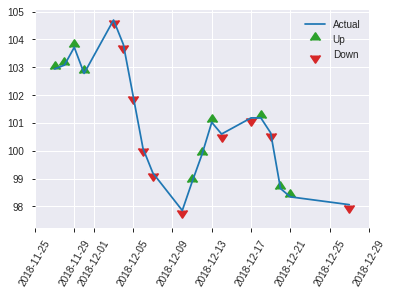


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2024464383513012
RMSE: 0.44994048312115814
LogLoss: 0.5893216698623683
Mean Per-Class Error: 0.3047381384495722
AUC: 0.7529815919108116
pr_auc: 0.7057658967717163
Gini: 0.5059631838216232
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3676694631576538: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   62   0.4662   (62.0/133.0)
1      20   96   0.1724   (20.0/116.0)
Total  91   158  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367669     0.70073   157
max f2                       0.0998091    0.835735  229
max f0point5                 0.5858       0.707547  76
max accuracy                 0.5858       0.706827  76
max precision                0.871968     1         0
max recall                   0.0998091    1         229
max specificity              0.871968     1         0
max absolute_mcc             0.5858       0.420306  76
max min_per_class_accuracy   0.465099     0.684211  121
max mean_per_class_accuracy  0.575662     0.695262  78

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 44.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.821111           2.14655   2.14655            1                0.841383   1                           0.841383            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.799681           2.14655   2.14655            1                0.813714   1                           0.830315            0.0172414       0.0431034                  114.655   114.655
    3        0.0321285                   0.787776           0.715517  1.60991            0.333333         0.793681   0.75                        0.816578            0.00862069      0.0517241                  -28.4483  60.9914
    4        0.0401606                   0.772251           1.07328   1.50259            0.5              0.780845   0.7                         0.809431            0.00862069      0.0603448                  7.32759   50.2586
    5        0.0522088                   0.759              2.14655   1.65119            1                0.766987   0.769231                    0.799636            0.0258621       0.0862069                  114.655   65.1194
    6        0.100402                    0.717611           1.78879   1.71724            0.833333         0.73317    0.8                         0.767732            0.0862069       0.172414                   78.8793   71.7241
    7        0.15261                     0.689726           1.65119   1.69465            0.769231         0.707473   0.789474                    0.747117            0.0862069       0.258621                   65.1194   69.4646
    8        0.200803                    0.649418           1.43103   1.63138            0.666667         0.665376   0.76                        0.727499            0.0689655       0.327586                   43.1034   63.1379
    9        0.301205                    0.589536           1.71724   1.66               0.8              0.624011   0.773333                    0.693003            0.172414        0.5                        71.7241   66
    10       0.401606                    0.533399           0.858621  1.45966            0.4              0.561502   0.68                        0.660128            0.0862069       0.586207                   -14.1379  45.9655
    11       0.502008                    0.463345           1.11621   1.39097            0.52             0.495378   0.648                       0.627178            0.112069        0.698276                   11.6207   39.0966
    12       0.598394                    0.400573           0.804957  1.29657            0.375            0.432163   0.604027                    0.595766            0.0775862       0.775862                   -19.5043  29.6575
    13       0.698795                    0.316577           0.858621  1.23365            0.4              0.352802   0.574713                    0.560857            0.0862069       0.862069                   -14.1379  23.365
    14       0.799197                    0.223851           0.772759  1.17575            0.36             0.281076   0.547739                    0.525709            0.0775862       0.939655                   -22.7241  17.5749
    15       0.899598                    0.12071            0.42931   1.09244            0.2              0.165937   0.508929                    0.485556            0.0431034       0.982759                   -57.069   9.24415
    16       1                           0.0471771          0.171724  1                  0.08             0.0806301  0.465863                    0.444

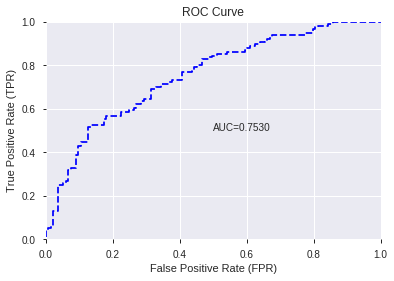

This function is available for GLM models only


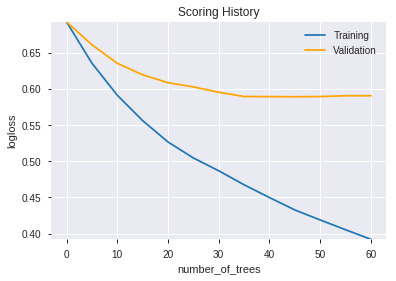

--2019-08-28 15:17:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_151721_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_151721_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'OBV',
 'ULTOSC',
 'Volume',
 'CORREL_14',
 'SIN',
 'SAREXT',
 'DIV',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'dayofyear',
 'MACDEXT_hist',
 'ADOSC',
 'WILLR_12',
 'STOCHRSI_fastk',
 'RSI_8',
 'WILLR_8',
 'day',
 'aroonup_14',
 'WILLR_20',
 'WILLR_30',
 'AROONOSC_8',
 'WILLR_14',
 'HT_PHASOR_quadrature',
 'WILLR_24',
 'aroondown_8',
 'week',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'weekofyear',
 'weekday',
 'CDLLONGLINE',
 'month',
 'CDLDOJI',
 'CDLENGULFING',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'quarter',
 'CDLBELTHOLD']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_151754_model_1  0.518343  7.207996                   0.5  0.604076  0.364908

variable  relative_importance  scaled_importance    percentage
0                         BOP         9.198176e-03           1.000000  2.431430e-02
1                STOCHF_fastk         6.350371e-03           0.690395  1.678646e-02
2          CDLCLOSINGMARUBOZU         5.971760e-03           0.649233  1.578565e-02
3                 CDLLONGLINE         5.865773e-03           0.637710  1.550548e-02
4              STOCHRSI_fastk         5.813447e-03           0.632022  1.536716e-02
...                       ...                  ...                ...           ...
1035  BBANDS_upperband_20_5_5         3.876796e-06           0.000421  1.024786e-05
1036  BBANDS_upperband_30_0_4         3.012592e-06           0.000328  7.963432e-06
1037  BBANDS_upperband_30_0_5         2.117692e-06           0.000230  5.597870e-06
1038             aroondown_24         4.783917e-07           0.000052  1.264572e-06
1039   BBANDS_lowerband_8_4_3         3.323323e-07           0.000036  8.784813e-07

[1040 rows x 4 columns]

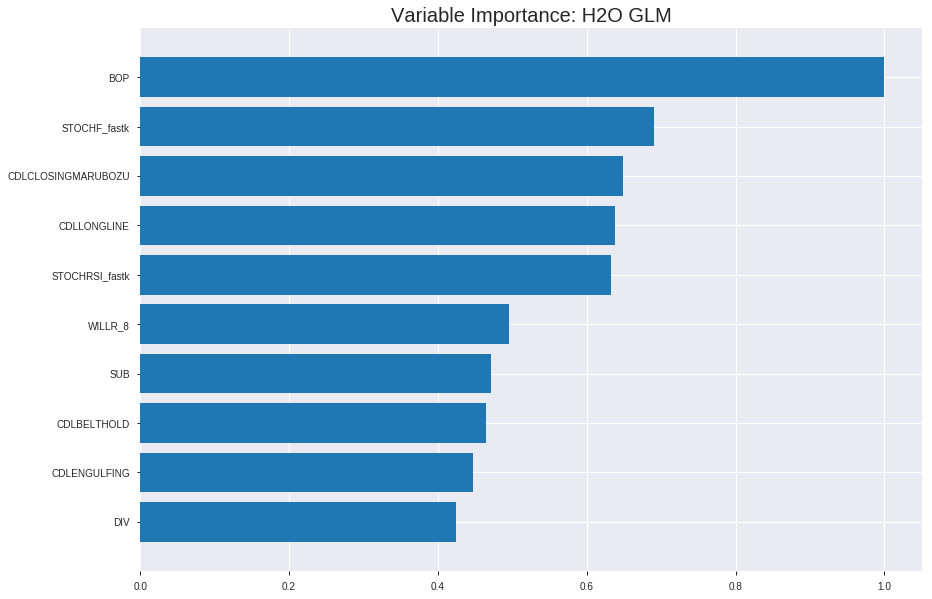

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_151754_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24294364348665873
RMSE: 0.4928931359703224
LogLoss: 0.6789766120706475
Null degrees of freedom: 1740
Residual degrees of freedom: 700
Null deviance: 2411.5386742145693
Residual deviance: 2364.196563229995
AIC: 4446.196563229994
AUC: 0.6322750693618708
pr_auc: 0.6234757143676282
Gini: 0.26455013872374167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4667470582357698: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      99   742   0.8823   (742.0/841.0)
1      22   878   0.0244   (22.0/900.0)
Total  121  1620  0.4388   (764.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466747     0.696825  348
max f2                       0.456003     0.84611   371
max f0point5                 0.500058     0.621904  256
max accuracy                 0.500058     0.608271  256
max precision                0.609126     1         0
max recall                   0.43526      1         398
max specificity              0.609126     1         0
max absolute_mcc             0.500058     0.219414  256
max min_per_class_accuracy   0.516182     0.587778  201
max mean_per_class_accuracy  0.500058     0.602208  256

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.596409           1.50457   1.50457            0.777778         0.601008  0.777778                    0.601008            0.0155556       0.0155556                  50.4568   50.4568
    2        0.0201034                   0.587653           1.2517    1.38175            0.647059         0.59131   0.714286                    0.596297            0.0122222       0.0277778                  25.1699   38.1746
    3        0.0304423                   0.580256           1.07469   1.27746            0.555556         0.58434   0.660377                    0.592236            0.0111111       0.0388889                  7.46914   27.7463
    4        0.0402068                   0.576385           1.36549   1.29884            0.705882         0.578152  0.671429                    0.588816            0.0133333       0.0522222                  36.549    29.8841
    5        0.0505457                   0.572662           1.50457   1.34092            0.777778         0.574334  0.693182                    0.585854            0.0155556       0.0677778                  50.4568   34.0922
    6        0.100517                    0.561267           1.28963   1.31542            0.666667         0.56674   0.68                        0.576352            0.0644444       0.132222                   28.963    31.5422
    7        0.150488                    0.552845           1.24516   1.29209            0.643678         0.556675  0.667939                    0.569818            0.0622222       0.194444                   24.516    29.2091
    8        0.20046                     0.546017           1.28963   1.29148            0.666667         0.548987  0.667622                    0.564625            0.0644444       0.258889                   28.963    29.1477
    9        0.300402                    0.535097           1.16734   1.25018            0.603448         0.540466  0.646272                    0.556588            0.116667        0.375556                   16.7337   25.0176
    10       0.400345                    0.525235           1.05616   1.20174            0.545977         0.530149  0.621234                    0.549987            0.105556        0.481111                   5.61622   20.1742
    11       0.500287                    0.516403           1.03393   1.16822            0.534483         0.520759  0.603904                    0.544148            0.103333        0.584444                   3.39272   16.8218
    12       0.60023                     0.507964           1.02281   1.14401            0.528736         0.512345  0.591388                    0.538853            0.102222        0.686667                   2.28097   14.4006
    13       0.700172                    0.498164           1.08951   1.13623            0.563218         0.503223  0.587367                    0.533767            0.108889        0.795556                   8.95147   13.6228
    14       0.800115                    0.487414           0.733755  1.08596            0.37931          0.492841  0.561378                    0.528655            0.0733333       0.868889                   -26.6245  8.59552
    15       0.900057                    0.472497           0.811577  1.05549            0.41954          0.480293  0.545629                    0.523285            0.0811111       0.95                       -18.8423  5.54882
    16       1                           0.433301           0.500287  1                  0.258621         0.459842  0.516944                    0.516944         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38235212929002055
RMSE: 0.6183462859029887
LogLoss: 9.246251816219294
Null degrees of freedom: 497
Residual degrees of freedom: -543
Null deviance: 689.8619915534578
Residual deviance: 168000.85047995194
AIC: 170082.85047995194
AUC: 0.5577925957020844
pr_auc: 0.598351589711756
Gini: 0.11558519140416879
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.4826863530894699e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    241  1        (241.0/241.0)
1      0    257  0        (0.0/257.0)
Total  0    498  0.4839   (241.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.48269e-49  0.680795  250
max f2                       1.48269e-49  0.842071  250
max f0point5                 1.48269e-49  0.571365  250
max accuracy                 0.48704      0.570281  100
max precision                0.527708     0.833333  5
max recall                   1.48269e-49  1         250
max specificity              0.546305     0.995851  0
max absolute_mcc             0.48704      0.198637  100
max min_per_class_accuracy   6.65873e-37  0.522822  249
max mean_per_class_accuracy  0.48704      0.579912  100

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 20.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.527774           1.55019   1.55019            0.8              0.534699     0.8                         0.534699            0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.524512           1.16265   1.35642            0.6              0.526315     0.7                         0.530507            0.0116732       0.0272374                  16.2646   35.642
    3        0.0301205                   0.522385           1.16265   1.29183            0.6              0.523715     0.666667                    0.528243            0.0116732       0.0389105                  16.2646   29.1829
    4        0.0401606                   0.518531           1.93774   1.45331            1                0.520688     0.75                        0.526354            0.0194553       0.0583658                  93.7743   45.3307
    5        0.0502008                   0.517204           1.55019   1.47268            0.8              0.51804      0.76                        0.524691            0.0155642       0.07393                    55.0195   47.2685
    6        0.100402                    0.509861           1.55019   1.51144            0.8              0.514567     0.78                        0.519629            0.077821        0.151751                   55.0195   51.144
    7        0.150602                    0.499364           1.24016   1.42101            0.64             0.505188     0.733333                    0.514815            0.0622568       0.214008                   24.0156   42.1012
    8        0.200803                    0.487157           1.24016   1.3758             0.64             0.492696     0.71                        0.509285            0.0622568       0.276265                   24.0156   37.5798
    9        0.301205                    0.461296           0.813852  1.18848            0.42             0.473651     0.613333                    0.497407            0.0817121       0.357977                   -18.6148  18.8482
    10       0.399598                    0.394697           0.790916  1.09059            0.408163         0.440101     0.562814                    0.483297            0.077821        0.435798                   -20.9084  9.05891
    11       0.5                         2.83486e-32        0.852607  1.0428             0.44             0.145017     0.538153                    0.415369            0.0856031       0.521401                   -14.7393  4.28016
    12       1                           0                  0.957198  1                  0.493976         2.67419e-39  0.516064                    0.207685            0.478599        1                          -4.28016  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:17:58  0.000 sec   2            18        1041          1.35795           337.351
    2019-08-28 15:18:00  2.276 sec   4            13        1041          1.3509            342.232
    2019-08-28 15:18:02  4.517 sec   6            9.8       1041          1.34206           345.685
    2019-08-28 15:18:04  6.733 sec   8            7.1       1041          1.33142           348.283
    2019-08-28 15:18:07  8.939 sec   10           5.2       1041          1.31886           350.364

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.570281124497992)

('F1', 0.6356164383561644)

('auc', 0.5183432719730361)

('logloss', 7.207995739401522)

('mean_per_class_error', 0.44247472128597354)

('rmse', 0.6040759031117017)

('mse', 0.364907696720218)

glm prediction progress: |████████████████████████████████████████████████| 100%


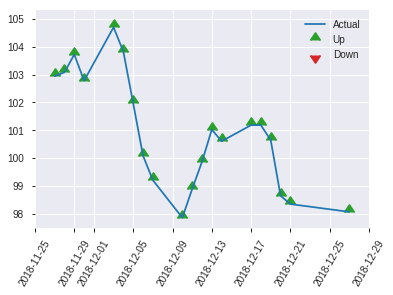


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.364907696720218
RMSE: 0.6040759031117017
LogLoss: 7.207995739401522
Null degrees of freedom: 248
Residual degrees of freedom: -792
Null deviance: 346.62607336051315
Residual deviance: 49211.893100777015
AIC: 51293.893100777015
AUC: 0.5183432719730361
pr_auc: 0.47907688425851763
Gini: 0.03668654394607218
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.612336464621328e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    116  0        (0.0/116.0)
Total  0    249  0.5341   (133.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.61234e-49  0.635616  164
max f2                       3.61234e-49  0.813464  164
max f0point5                 3.61234e-49  0.521583  164
max accuracy                 0.443659     0.570281  74
max precision                0.498019     1         0
max recall                   3.61234e-49  1         164
max specificity              0.498019     1         0
max absolute_mcc             0.440776     0.124175  76
max min_per_class_accuracy   0.00224601   0.508621  123
max mean_per_class_accuracy  0.440776     0.557525  76

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 19.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.491861           0.715517  0.715517           0.333333         0.49543      0.333333                    0.49543             0.00862069      0.00862069                 -28.4483  -28.4483
    2        0.0200803                   0.489731           2.14655   1.28793            1                0.490981     0.6                         0.49365             0.0172414       0.0258621                  114.655   28.7931
    3        0.0321285                   0.487628           0         0.804957           0                0.48879      0.375                       0.491828            0               0.0258621                  -100      -19.5043
    4        0.0401606                   0.486113           1.07328   0.858621           0.5              0.486533     0.4                         0.490769            0.00862069      0.0344828                  7.32759   -14.1379
    5        0.0522088                   0.485435           1.43103   0.990716           0.666667         0.485774     0.461538                    0.489616            0.0172414       0.0517241                  43.1034   -0.928382
    6        0.100402                    0.47684            1.43103   1.20207            0.666667         0.481025     0.56                        0.485493            0.0689655       0.12069                    43.1034   20.2069
    7        0.15261                     0.468195           0.495358  0.960299           0.230769         0.472338     0.447368                    0.480992            0.0258621       0.146552                   -50.4642  -3.97005
    8        0.200803                    0.45693            1.60991   1.11621            0.75             0.463251     0.52                        0.476734            0.0775862       0.224138                   60.9914   11.6207
    9        0.301205                    0.442929           1.37379   1.20207            0.64             0.449575     0.56                        0.467681            0.137931        0.362069                   37.3793   20.2069
    10       0.401606                    0.315984           0.515172  1.03034            0.24             0.409452     0.48                        0.453124            0.0517241       0.413793                   -48.4828  3.03448
    11       0.502008                    0.00186041         0.944483  1.01317            0.44             0.10866      0.472                       0.384231            0.0948276       0.508621                   -5.55172  1.31724
    12       0.598394                    2.77572e-12        1.07328   1.02285            0.5              0.000246958  0.47651                     0.322381            0.103448        0.612069                   7.32759   2.28535
    13       0.698795                    2.10912e-66        0.858621  0.999257           0.4              1.21305e-13  0.465517                    0.276062            0.0862069       0.698276                   -14.1379  -0.0743163
    14       1                           0                  1.00172   1                  0.466667         2.98808e-73  0.465863                    0.192911            0.301724        1                          0.172414  0

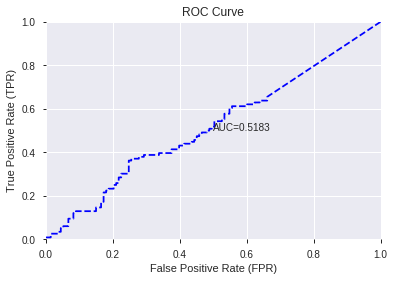

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


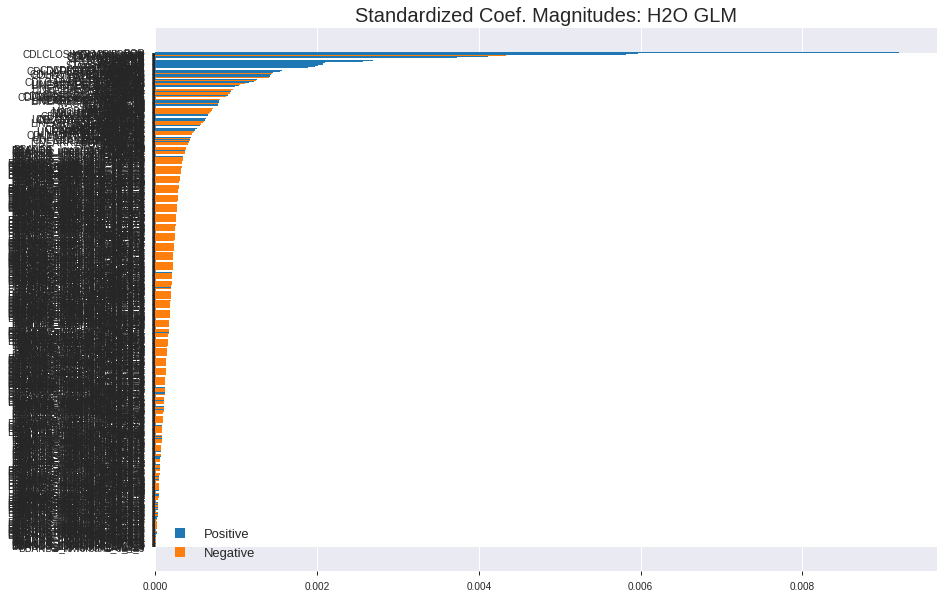

'log_likelihood'
--2019-08-28 15:18:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_151754_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_151754_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

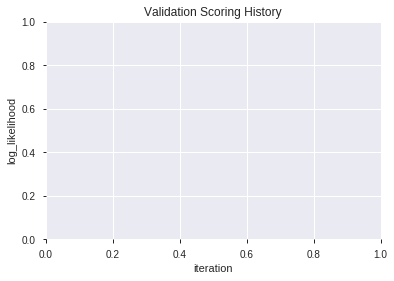

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190828_151842  0.754213  0.592612              0.325609  0.451869  0.204186
1  XGBoost_grid_1_AutoML_20190828_151842_model_4  0.749935  0.602037              0.360999  0.455864  0.207812
2  XGBoost_grid_1_AutoML_20190828_151842_model_7  0.745528  0.613247              0.311220  0.460876  0.212406
3               XGBoost_1_AutoML_20190828_151842  0.743065  0.610642              0.367416  0.460300  0.211876
4  XGBoost_grid_1_AutoML_20190828_151842_model_1  0.741509  0.605229              0.290316  0.456151  0.208074
5               XGBoost_3_AutoML_20190828_151842  0.735870  0.605881              0.327813  0.457722  0.209510
6  XGBoost_grid_1_AutoML_20190828_151842_model_6  0.733407  0.610344              0.301595  0.459509  0.211148
7  XGBoost_grid_1_AutoML_20190828_151842_model_2  0.726601  0.612843              0.303798  0.460973  0.212496
8  XGBoost_grid_1_AutoML_20190828_151842_model_3  0.718888  0.621432              0.346059  0.466019  0.217174
9  XGBoost_grid_1_AutoML_20190828_151842_model_5  0.700674  0.650985              0.358439  0.479482  0.229903

variable  relative_importance  scaled_importance  percentage
0                        BOP          1455.671753           1.000000    0.168823
1               STOCHF_fastk           456.548553           0.313634    0.052949
2                        SUB           295.580505           0.203054    0.034280
3                     TRANGE           235.988953           0.162117    0.027369
4                        DIV           217.771759           0.149602    0.025256
..                       ...                  ...                ...         ...
291               aroonup_12             1.718860           0.001181    0.000199
292                    ADX_8             1.677153           0.001152    0.000195
293                MACDFIX_8             1.490524           0.001024    0.000173
294  BBANDS_upperband_20_5_5             1.262457           0.000867    0.000146
295                   VAR_24             1.083607           0.000744    0.000126

[296 rows x 4 columns]

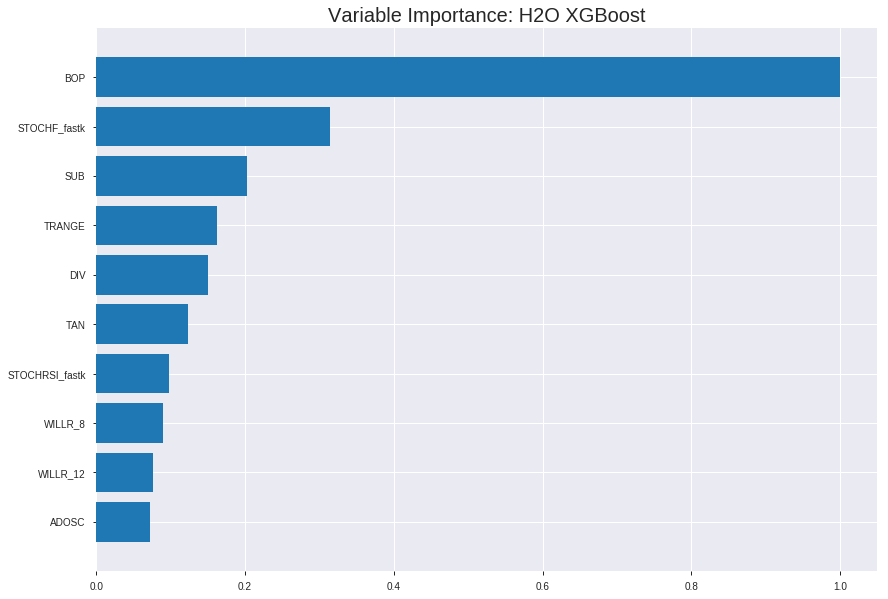

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190828_151842


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13039637643293978
RMSE: 0.361104384400051
LogLoss: 0.4286422937401206
Mean Per-Class Error: 0.1268998546703659
AUC: 0.9398308891531246
pr_auc: 0.9467192428345095
Gini: 0.8796617783062493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5777895549933115: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      769  72   0.0856   (72.0/841.0)
1      152  748  0.1689   (152.0/900.0)
Total  921  820  0.1287   (224.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.57779      0.869767  162
max f2                       0.397197     0.907283  253
max f0point5                 0.615577     0.900678  143
max accuracy                 0.584081     0.871338  158
max precision                0.922822     1         0
max recall                   0.180406     1         349
max specificity              0.922822     1         0
max absolute_mcc             0.584081     0.748091  158
max min_per_class_accuracy   0.543529     0.861111  179
max mean_per_class_accuracy  0.584081     0.8731    158

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.62 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0103389                   0.868739           1.93444  1.93444            1                0.882658  1                           0.882658            0.02            0.02                       93.4444  93.4444
    2        0.0201034                   0.852172           1.93444  1.93444            1                0.858729  1                           0.871035            0.0188889       0.0388889                  93.4444  93.4444
    3        0.0304423                   0.839897           1.93444  1.93444            1                0.84689   1                           0.862835            0.02            0.0588889                  93.4444  93.4444
    4        0.0402068                   0.828148           1.93444  1.93444            1                0.834356  1                           0.855919            0.0188889       0.0777778                  93.4444  93.4444
    5        0.0505457                   0.819674           1.93444  1.93444            1                0.823599  1                           0.849308            0.02            0.0977778                  93.4444  93.4444
    6        0.100517                    0.788528           1.93444  1.93444            1                0.803725  1                           0.826646            0.0966667       0.194444                   93.4444  93.4444
    7        0.150488                    0.760735           1.93444  1.93444            1                0.774433  1                           0.809308            0.0966667       0.291111                   93.4444  93.4444
    8        0.20046                     0.733937           1.86774  1.91782            0.965517         0.74831   0.991404                    0.794102            0.0933333       0.384444                   86.7739  91.7816
    9        0.300402                    0.685122           1.81215  1.88266            0.936782         0.707622  0.973231                    0.765331            0.181111        0.565556                   81.2152  88.2662
    10       0.400345                    0.631873           1.66762  1.82898            0.862069         0.659081  0.945481                    0.738807            0.166667        0.732222                   66.7625  82.898
    11       0.500287                    0.55323            1.21181  1.70569            0.626437         0.592116  0.881745                    0.709502            0.121111        0.853333                   21.1807  70.5687
    12       0.60023                     0.47021            0.66705  1.53275            0.344828         0.511031  0.792344                    0.676455            0.0666667       0.92                       -33.295  53.2746
    13       0.700172                    0.376439           0.48917  1.38379            0.252874         0.423723  0.71534                     0.64038             0.0488889       0.968889                   -51.083  38.3786
    14       0.800115                    0.276338           0.22235  1.23871            0.114943         0.326557  0.640345                    0.601181            0.0222222       0.991111                   -77.765  23.8711
    15       0.900057                    0.171668           0.08894  1.11104            0.045977         0.225315  0.574346                    0.559444            0.00888889      1                          -91.106  11.104
    16       1                           0.0624658          0        1                  0                0.1264    0.516944                    0.516165            0               1                 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2045543532776133
RMSE: 0.45227685467820844
LogLoss: 0.5962238656090301
Mean Per-Class Error: 0.2952839175291022
AUC: 0.7584077368939406
pr_auc: 0.750486934983902
Gini: 0.5168154737878812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36767125129699707: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  115  0.4772   (115.0/241.0)
1      37   220  0.144    (37.0/257.0)
Total  163  335  0.3052   (152.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367671     0.743243  266
max f2                       0.217411     0.854496  340
max f0point5                 0.436226     0.708661  225
max accuracy                 0.436226     0.706827  225
max precision                0.832892     1         0
max recall                   0.0790825    1         398
max specificity              0.832892     1         0
max absolute_mcc             0.421945     0.415884  235
max min_per_class_accuracy   0.472491     0.692946  198
max mean_per_class_accuracy  0.436226     0.704716  225

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 45.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.786128           1.93774   1.93774            1                0.804929  1                           0.804929            0.0194553       0.0194553                  93.7743   93.7743
    2        0.0200803                   0.775637           1.55019   1.74397            0.8              0.780872  0.9                         0.7929              0.0155642       0.0350195                  55.0195   74.3969
    3        0.0301205                   0.753536           1.55019   1.67938            0.8              0.766404  0.866667                    0.784068            0.0155642       0.0505837                  55.0195   67.9377
    4        0.0401606                   0.724738           1.93774   1.74397            1                0.747948  0.9                         0.775038            0.0194553       0.0700389                  93.7743   74.3969
    5        0.0502008                   0.714407           1.55019   1.70521            0.8              0.720635  0.88                        0.764158            0.0155642       0.0856031                  55.0195   70.5214
    6        0.100402                    0.681767           1.6277    1.66646            0.84             0.698115  0.86                        0.731137            0.0817121       0.167315                   62.7704   66.6459
    7        0.150602                    0.660231           1.55019   1.6277             0.8              0.670803  0.84                        0.711025            0.077821        0.245136                   55.0195   62.7704
    8        0.200803                    0.630151           1.24016   1.53082            0.64             0.647095  0.79                        0.695043            0.0622568       0.307393                   24.0156   53.0817
    9        0.301205                    0.582264           1.35642   1.47268            0.7              0.605257  0.76                        0.665114            0.136187        0.44358                    35.642    47.2685
    10       0.399598                    0.522321           1.34456   1.44114            0.693878         0.552623  0.743719                    0.637415            0.132296        0.575875                   34.4556   44.1136
    11       0.5                         0.474894           1.08514   1.36965            0.56             0.500473  0.706827                    0.609917            0.108949        0.684825                   8.51362   36.965
    12       0.600402                    0.421537           1.12389   1.32855            0.58             0.447814  0.685619                    0.582809            0.11284         0.797665                   12.3891   32.8553
    13       0.698795                    0.345894           0.711824  1.24171            0.367347         0.387398  0.640805                    0.555295            0.0700389       0.867704                   -28.8176  24.1715
    14       0.799197                    0.272489           0.581323  1.15875            0.3              0.310093  0.59799                     0.52449             0.0583658       0.92607                    -41.8677  15.8751
    15       0.899598                    0.177731           0.465058  1.08133            0.24             0.228769  0.558036                    0.491486            0.0466926       0.972763                   -53.4942  8.13299
    16       1                           0.0697647          0.271284  1                  0.14             0.129758  0.516064                    0.455168          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:18:49  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-28 15:18:49  0.863 sec   5                  0.476022         0.646073            0.820275        0.820827           1.82698          0.283745                         0.489292           0.671827              0.708599          0.685963             1.93774            0.337349
    2019-08-28 15:18:50  1.490 sec   10                 0.457484         0.610395            0.847639        0.855198           1.93444          0.248133                         0.477722           0.648958              0.737063          0.710809             1.93774            0.311245
    2019-08-28 15:18:51  2.119 sec   15                 0.441496         0.579782            0.865114        0.873942           1.93444          0.225732                         0.46923            0.632073              0.750747          0.725977             1.93774            0.299197
    2019-08-28 15:18:51  2.718 sec   20                 0.428714         0.555095            0.875001        0.888974           1.93444          0.236071                         0.464334           0.622062              0.751393          0.728291             1.93774            0.283133
    2019-08-28 15:18:52  3.335 sec   25                 0.417937         0.534388            0.884452        0.896804           1.93444          0.196439                         0.459446           0.612144              0.755033          0.740616             1.93774            0.295181
    2019-08-28 15:18:53  3.980 sec   30                 0.408201         0.515807            0.895307        0.907085           1.93444          0.184377                         0.457062           0.606937              0.754936          0.74549              1.93774            0.309237
    2019-08-28 15:18:53  4.654 sec   35                 0.400023         0.500051            0.901226        0.913005           1.93444          0.178059                         0.455118           0.602612              0.758044          0.749283             1.93774            0.307229
    2019-08-28 15:18:54  5.285 sec   40                 0.39286          0.486498            0.909515        0.920467           1.93444          0.164273                         0.452855           0.597982              0.759401          0.751566             1.93774            0.333333
    2019-08-28 15:18:55  5.924 sec   45                 0.38581          0.473277            0.916611        0.927004           1.93444          0.151637                         0.45333            0.598627              0.758214          0.754112             1.93774            0.305221
    2019-08-28 15:18:55  6.572 sec   50                 0.378854         0.460751            0.923802        0.933332           1.93444          0.146468                         0.453223           0.598452              0.757019          0.750663             1.93774            0.311245
    2019-08-28 15:18:56  7.195 sec   55                 0.373188         0.450074            0.927573        0.936393           1.93444          0.141872                         0.451995           0.595855              0.760482          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1455.6717529296875     1.0                    0.1688228023392225
STOCHF_fastk             456.5485534667969      0.3136342740373621     0.052948617052615124
SUB                      295.58050537109375     0.20305436632689197    0.03428020715052096
TRANGE                   235.98895263671875     0.16211687295694718    0.02736902479906354
DIV                      217.77175903320312     0.14960224280983353    0.025256269867388898
---                      ---                    ---                    ---
aroonup_12               1.7188596725463867     0.0011808016945351908  0.0001993462510783335
ADX_8                    1.6771526336669922     0.0011521502909509318  0.00019450924083428683
MACDFIX_8                1.4905242919921875     0.0010239425811432803  0.00017286485598306528
BBANDS_upperband_20_5_5  1.2624568939208984     0.0008672675631577486  0.00014641454039019975
VAR_24                   1.0836067199707031     0.0007444032061416554  0.0001256722353311362


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7068273092369478)

('F1', 0.7118644067796609)

('auc', 0.7542131190044076)

('logloss', 0.5926120172056197)

('mean_per_class_error', 0.29482110448535126)

('rmse', 0.4518693003974543)

('mse', 0.2041858646416848)

xgboost prediction progress: |████████████████████████████████████████████| 100%


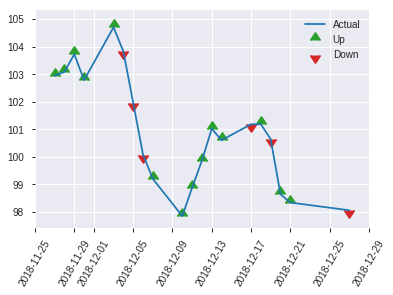


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2041858646416848
RMSE: 0.4518693003974543
LogLoss: 0.5926120172056197
Mean Per-Class Error: 0.29482110448535126
AUC: 0.7542131190044076
pr_auc: 0.7012458653010173
Gini: 0.5084262380088151
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33759257197380066: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   74   0.5564   (74.0/133.0)
1      11   105  0.0948   (11.0/116.0)
Total  70   179  0.3414   (85.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337593     0.711864  178
max f2                       0.212516     0.834575  206
max f0point5                 0.467016     0.68662   112
max accuracy                 0.467016     0.706827  112
max precision                0.751238     1         0
max recall                   0.116264     1         233
max specificity              0.751238     1         0
max absolute_mcc             0.463589     0.410597  114
max min_per_class_accuracy   0.463589     0.681034  114
max mean_per_class_accuracy  0.463589     0.705179  114

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 42.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.710876           2.14655   2.14655            1                0.726046  1                           0.726046            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.699596           2.14655   2.14655            1                0.70689   1                           0.718383            0.0172414       0.0431034                  114.655   114.655
    3        0.0321285                   0.691308           1.43103   1.87823            0.666667         0.697193  0.875                       0.710437            0.0172414       0.0603448                  43.1034   87.8233
    4        0.0401606                   0.67996            1.07328   1.71724            0.5              0.684411  0.8                         0.705232            0.00862069      0.0689655                  7.32759   71.7241
    5        0.0522088                   0.674466           1.43103   1.65119            0.666667         0.677788  0.769231                    0.698899            0.0172414       0.0862069                  43.1034   65.1194
    6        0.100402                    0.635755           1.43103   1.54552            0.666667         0.650744  0.72                        0.675785            0.0689655       0.155172                   43.1034   54.5517
    7        0.15261                     0.608723           1.98143   1.69465            0.923077         0.621113  0.789474                    0.657081            0.103448        0.258621                   98.1432   69.4646
    8        0.200803                    0.583015           1.60991   1.67431            0.75             0.596331  0.78                        0.642501            0.0775862       0.336207                   60.9914   67.431
    9        0.301205                    0.54056            1.37379   1.57414            0.64             0.559777  0.733333                    0.614926            0.137931        0.474138                   37.3793   57.4138
    10       0.401606                    0.502663           1.20207   1.48112            0.56             0.520467  0.69                        0.591312            0.12069         0.594828                   20.2069   48.1121
    11       0.502008                    0.449593           1.03034   1.39097            0.48             0.469333  0.648                       0.566916            0.103448        0.698276                   3.03448   39.0966
    12       0.598394                    0.411513           0.626078  1.26776            0.291667         0.434539  0.590604                    0.545593            0.0603448       0.758621                   -37.3922  26.7762
    13       0.698795                    0.346497           1.28793   1.27066            0.6              0.383251  0.591954                    0.522268            0.12931         0.887931                   28.7931   27.066
    14       0.799197                    0.25317            0.42931   1.16496            0.2              0.297766  0.542714                    0.494065            0.0431034       0.931034                   -57.069   16.4963
    15       0.899598                    0.1396             0.42931   1.08286            0.2              0.191253  0.504464                    0.460269            0.0431034       0.974138                   -57.069   8.28587
    16       1                           0.0676544          0.257586  1                  0.12             0.106097  0.465863                    0.424709           

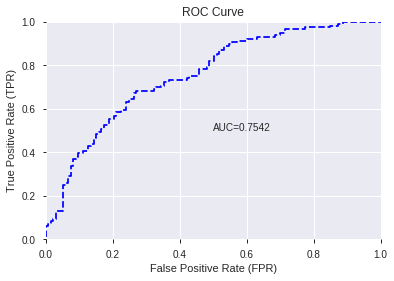

This function is available for GLM models only


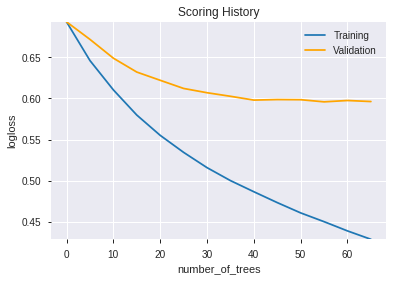

--2019-08-28 15:19:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


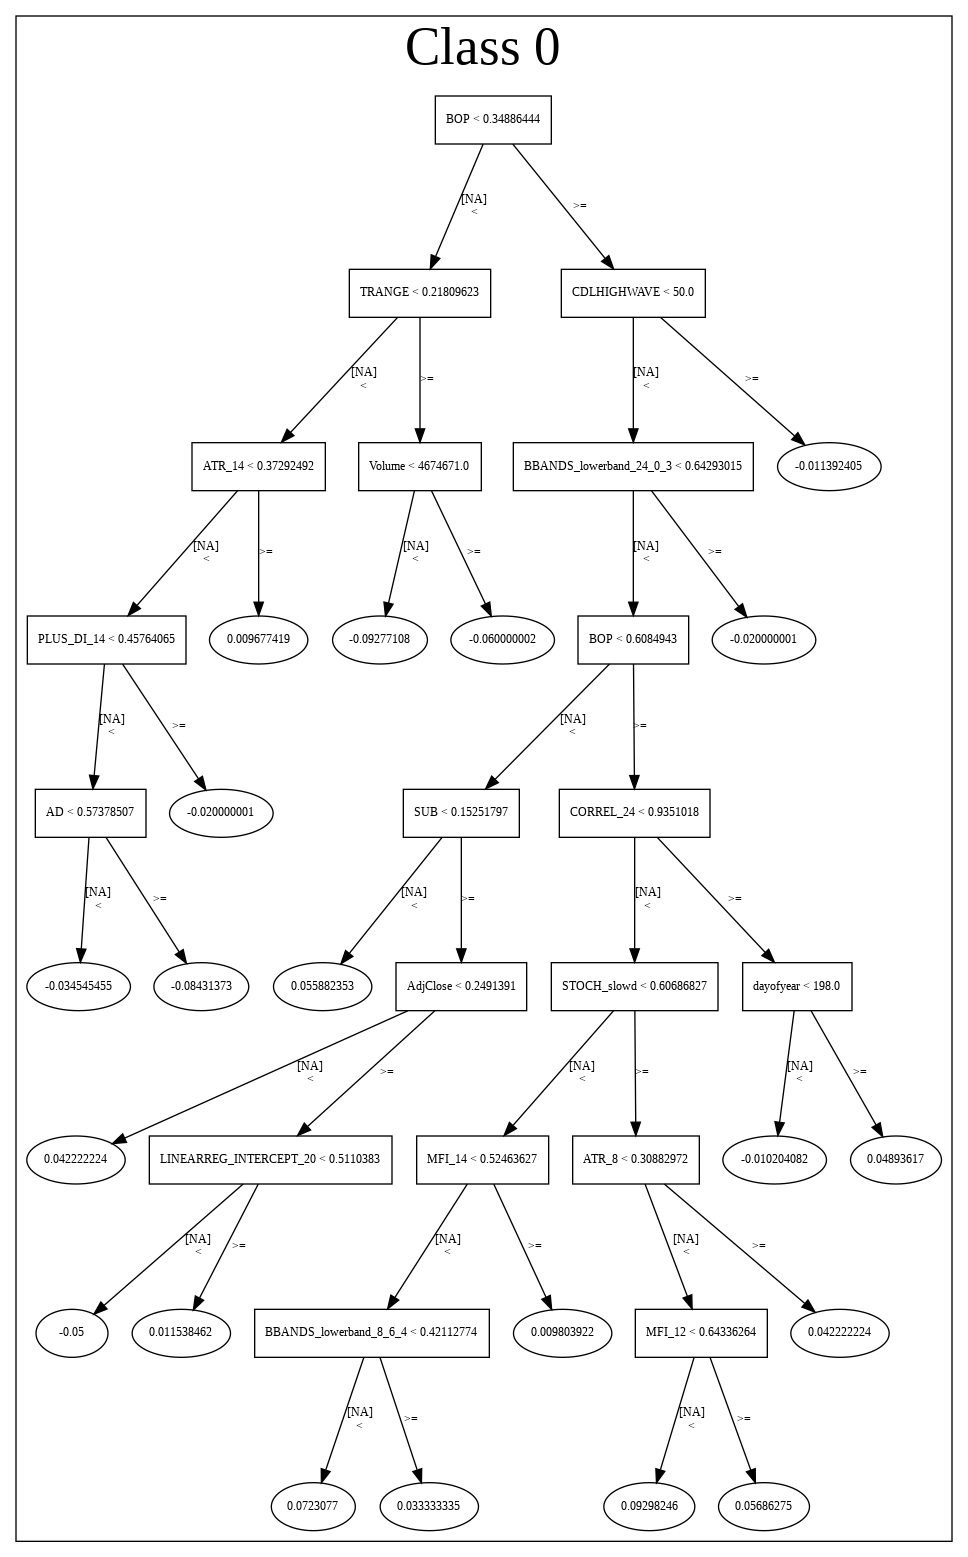

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190828_151842',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190828_151842',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_9cf3',
   'type

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_152004_model_5  0.745074  0.630923              0.334781  0.463157  0.214514
1  DeepLearning_grid_1_AutoML_20190828_152004_model_6  0.741768  0.626438              0.341749  0.465468  0.216660
2  DeepLearning_grid_1_AutoML_20190828_152004_model_9  0.737944  0.613650              0.291969  0.460961  0.212485
3  DeepLearning_grid_1_AutoML_20190828_152004_model_8  0.737814  0.608531              0.296182  0.458813  0.210510
4  DeepLearning_grid_1_AutoML_20190828_152004_model_7  0.736129  0.780927              0.344957  0.512622  0.262782
5               DeepLearning_1_AutoML_20190828_152004  0.725175  0.663731              0.310669  0.477834  0.228326
6  DeepLearning_grid_1_AutoML_20190828_152004_model_3  0.697174  0.755825              0.346156  0.488978  0.239100
7  DeepLearning_grid_1_AutoML_20190828_152004_model_4  0.691729  0.813261              0.350467  0.507967  0.258030
8  DeepLearning_grid_1_AutoML_20190828_152004_model_1  0.652515  1.049730              0.401802  0.534978  0.286202
9  DeepLearning_grid_1_AutoML_20190828_152004_model_2  0.648172  0.882412              0.414085  0.534150  0.285316

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.041021
1                    SUB             0.709900           0.709900    0.029121
2                    day             0.620996           0.620996    0.025474
3              CORREL_14             0.601980           0.601980    0.024694
4                    SIN             0.596800           0.596800    0.024481
5     CDLCLOSINGMARUBOZU             0.582428           0.582428    0.023892
6           weekday_name             0.571530           0.571530    0.023445
7                    OBV             0.564299           0.564299    0.023148
8             aroonup_14             0.559010           0.559010    0.022931
9                 SAREXT             0.557158           0.557158    0.022855
10         days_in_month             0.548438           0.548438    0.022497
11           CDLMARUBOZU             0.547554           0.547554    0.022461
12             dayofweek             0.533956           0.533956    0.021903
13          CDLENGULFING             0.533247           0.533247    0.021874
14        STOCHRSI_fastk             0.527804           0.527804    0.021651
15          STOCHF_fastk             0.525747           0.525747    0.021567
16                TRANGE             0.523670           0.523670    0.021481
17               weekday             0.512454           0.512454    0.021021
18          MACDEXT_hist             0.505877           0.505877    0.020752
19        CDLRICKSHAWMAN             0.482082           0.482082    0.019775
20            AROONOSC_8             0.479586           0.479586    0.019673
21        STOCHRSI_fastd             0.476541           0.476541    0.019548
22           aroondown_8             0.464500           0.464500    0.019054
23                   DIV             0.461054           0.461054    0.018913
24           CDLLONGLINE             0.459124           0.459124    0.018834
25           CDLBELTHOLD             0.456423           0.456423    0.018723
26              WILLR_30             0.452674           0.452674    0.018569
27           STOCH_slowd             0.449745           0.449745    0.018449
28  HT_PHASOR_quadrature             0.447110           0.447110    0.018341
29               quarter             0.446455           0.446455    0.018314
30                ULTOSC             0.442762           0.442762    0.018162
31                 RSI_8             0.437868           0.437868    0.017962
32                Volume             0.437106           0.437106    0.017930
33          CDLSHORTLINE             0.435552           0.435552    0.017867
34               CDLDOJI             0.434616           0.434616    0.017828
35     CDLLONGLEGGEDDOJI             0.431304           0.431304    0.017692
36                 ADOSC             0.419456           0.419456    0.017206
37                 month             0.416088           0.416088    0.017068
38                  week             0.414617           0.414617    0.017008
39            weekofyear             0.410615           0.410615    0.016844
40              WILLR_14             0.408762           0.408762    0.016768
41             dayofyear             0.402776           0.402776    0.016522
42              WILLR_24             0.400855           0.400855    0.016443
43              WILLR_20             0.397648           0.397648    0.016312
44              WILLR_12             0.393970           0.393970    0.016161
45     CDLINVERTEDHAMMER             0.392798           0.392798    0.016113
46      CDLDRAGONFLYDOJI             0.382078           0.382078    0.015673
47               WILLR_8             0.377432           0.377432    0.015483
48     CDLDARKCLOUDCOVER             0.374002           0.374002    0.015342
49             CDLTAKURI             0.369383           0.369383    0.015152

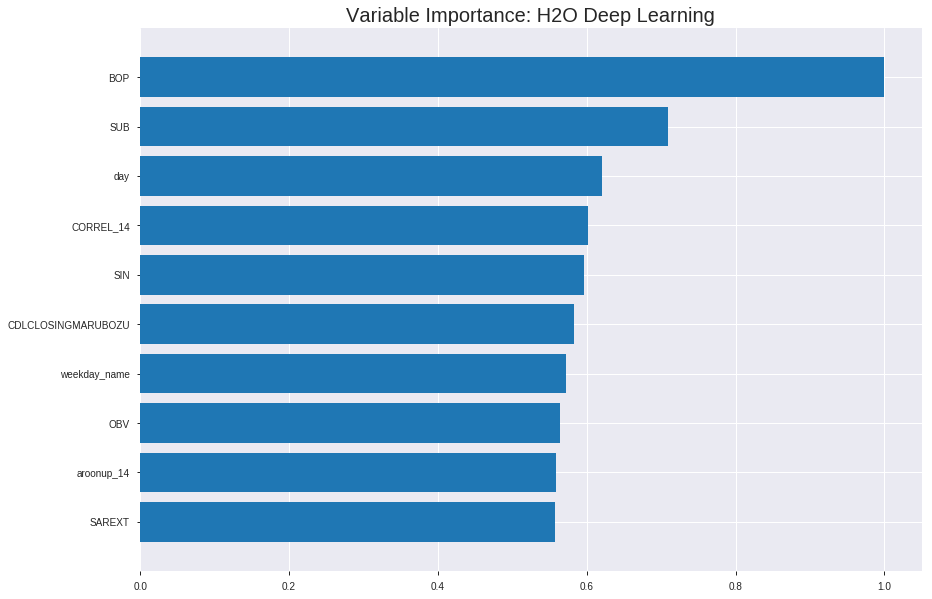

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_152004_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18606955816787357
RMSE: 0.4313578075888665
LogLoss: 0.549089603530528
Mean Per-Class Error: 0.2843816884661118
AUC: 0.7876852952833928
pr_auc: 0.7691871965028393
Gini: 0.5753705905667856
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3142586573413686: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      336  505   0.6005   (505.0/841.0)
1      23   877   0.0256   (23.0/900.0)
Total  359  1382  0.3033   (528.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314259     0.768624  294
max f2                       0.259517     0.88434   312
max f0point5                 0.564778     0.714706  203
max accuracy                 0.510439     0.72085   228
max precision                0.995432     1         0
max recall                   0.068455     1         370
max specificity              0.995432     1         0
max absolute_mcc             0.314259     0.461906  294
max min_per_class_accuracy   0.632436     0.692222  171
max mean_per_class_accuracy  0.510439     0.715618  228

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 57.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.984064           1.82698   1.82698            0.944444         0.988791   0.944444                    0.988791            0.0188889       0.0188889                  82.6975   82.6975
    2        0.0201034                   0.97657            1.82065   1.8239             0.941176         0.979829   0.942857                    0.984438            0.0177778       0.0366667                  82.0654   82.3905
    3        0.0304423                   0.964677           1.82698   1.82495            0.944444         0.970888   0.943396                    0.979836            0.0188889       0.0555556                  82.6975   82.4948
    4        0.0402068                   0.953348           1.47928   1.741              0.764706         0.958335   0.9                         0.974614            0.0144444       0.07                       47.9281   74.1
    5        0.0505457                   0.937795           1.61204   1.71462            0.833333         0.945861   0.886364                    0.968733            0.0166667       0.0866667                  61.2037   71.4621
    6        0.100517                    0.891661           1.62315   1.66915            0.83908          0.913851   0.862857                    0.941449            0.0811111       0.167778                   62.3155   66.9149
    7        0.150488                    0.856841           1.55645   1.63173            0.804598         0.87353    0.843511                    0.918896            0.0777778       0.245556                   55.645    63.1726
    8        0.20046                     0.827524           1.37857   1.56862            0.712644         0.842785   0.810888                    0.899922            0.0688889       0.314444                   37.857    56.8618
    9        0.300402                    0.762043           1.42304   1.52018            0.735632         0.794123   0.785851                    0.864724            0.142222        0.456667                   42.304    52.0185
    10       0.400345                    0.696922           1.21181   1.4432             0.626437         0.728046   0.746055                    0.830603            0.121111        0.577778                   21.1807   44.3201
    11       0.500287                    0.634696           1.08951   1.37254            0.563218         0.668074   0.709529                    0.798135            0.108889        0.686667                   8.95147   37.2545
    12       0.60023                     0.565743           1.20069   1.34393            0.62069          0.604393   0.694737                    0.765875            0.12            0.806667                   20.069    34.393
    13       0.700172                    0.454152           0.93387   1.2854             0.482759         0.517156   0.664479                    0.730373            0.0933333       0.9                        -6.61303  28.5398
    14       0.800115                    0.308728           0.767107  1.22066            0.396552         0.387335   0.631012                    0.687524            0.0766667       0.976667                   -23.2893  22.0658
    15       0.900057                    0.114244           0.211232  1.10857            0.109195         0.204976   0.57307                     0.633942            0.0211111       0.997778                   -78.8768  10.8571
    16       1                           0.00117792         0.022235  1                  0.0114943        0.0506554  0.516944                    0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20995648021315147
RMSE: 0.45821008305487065
LogLoss: 0.628809399706532
Mean Per-Class Error: 0.29749584254968764
AUC: 0.7422703715065309
pr_auc: 0.7136132621621235
Gini: 0.4845407430130617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4806154163816618: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  109  0.4523   (109.0/241.0)
1      40   217  0.1556   (40.0/257.0)
Total  172  326  0.2992   (149.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480615     0.744425  250
max f2                       0.154526     0.851648  344
max f0point5                 0.611481     0.712062  197
max accuracy                 0.611481     0.702811  197
max precision                0.995028     1         0
max recall                   0.0155706    1         391
max specificity              0.995028     1         0
max absolute_mcc             0.480615     0.412071  250
max min_per_class_accuracy   0.624903     0.697095  193
max mean_per_class_accuracy  0.611481     0.702504  197

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 55.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.977608           1.93774   1.93774            1                0.987496   1                           0.987496            0.0194553       0.0194553                  93.7743   93.7743
    2        0.0200803                   0.968702           1.16265   1.55019            0.6              0.975121   0.8                         0.981308            0.0116732       0.0311284                  16.2646   55.0195
    3        0.0301205                   0.950264           1.16265   1.42101            0.6              0.96122    0.733333                    0.974612            0.0116732       0.0428016                  16.2646   42.1012
    4        0.0401606                   0.938885           1.16265   1.35642            0.6              0.944863   0.7                         0.967175            0.0116732       0.0544747                  16.2646   35.642
    5        0.0502008                   0.925477           1.93774   1.47268            1                0.934809   0.76                        0.960702            0.0194553       0.07393                    93.7743   47.2685
    6        0.100402                    0.883927           1.55019   1.51144            0.8              0.904269   0.78                        0.932485            0.077821        0.151751                   55.0195   51.144
    7        0.150602                    0.841628           1.39518   1.47268            0.72             0.863574   0.76                        0.909515            0.0700389       0.22179                    39.5175   47.2685
    8        0.200803                    0.807874           1.55019   1.49206            0.8              0.825356   0.77                        0.888475            0.077821        0.299611                   55.0195   49.2062
    9        0.301205                    0.730986           1.27891   1.42101            0.66             0.769094   0.733333                    0.848681            0.128405        0.428016                   27.8911   42.1012
    10       0.399598                    0.683656           1.22592   1.37297            0.632653         0.706037   0.708543                    0.813558            0.120623        0.548638                   22.5919   37.2974
    11       0.5                         0.629705           1.35642   1.36965            0.7              0.658473   0.706827                    0.782416            0.136187        0.684825                   35.642    36.965
    12       0.600402                    0.545169           0.968872  1.30263            0.5              0.583513   0.672241                    0.749155            0.0972763       0.782101                   -3.11284  30.263
    13       0.698795                    0.418099           0.830461  1.23615            0.428571         0.488022   0.637931                    0.712386            0.0817121       0.863813                   -16.9539  23.6147
    14       0.799197                    0.27793            0.542568  1.14901            0.28             0.356301   0.592965                    0.667652            0.0544747       0.918288                   -45.7432  14.9014
    15       0.899598                    0.0924509          0.542568  1.08133            0.28             0.183183   0.558036                    0.613582            0.0544747       0.972763                   -45.7432  8.13299
    16       1                           0.00196963         0.271284  1                  0.14             0.0332564  0.516064                    0.5


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:23:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:23:12  1 min 26.821 sec  1241 obs/sec      1         1             1741       0.480701         0.671676            0.0746425      0.727518        0.705131           1.61204          0.341183                         0.492526           0.705635              0.0286715        0.699493          0.660574             1.16265            0.36747
    2019-08-28 15:23:17  1 min 32.401 sec  2154 obs/sec      8         8             13928      0.454132         0.603785            0.174109       0.764578        0.746061           1.71951          0.32108                          0.466772           0.642168              0.127596         0.740922          0.702567             1.55019            0.307229
    2019-08-28 15:23:23  1 min 37.689 sec  2486 obs/sec      16        16            27856      0.431358         0.54909             0.254866       0.787685        0.769187           1.82698          0.303274                         0.45821            0.628809              0.159306         0.74227           0.713613             1.93774            0.299197
    2019-08-28 15:23:28  1 min 43.333 sec  2670 obs/sec      25        25            43525      0.411472         0.501009            0.321985       0.825348        0.81445            1.93444          0.264216                         0.470359           0.666435              0.114134         0.719303          0.688601             1.93774            0.309237
    2019-08-28 15:23:34  1 min 49.282 sec  2804 obs/sec      35        35            60935      0.390136         0.455916            0.390476       0.854067        0.844004           1.93444          0.226307                         0.475155           0.697263              0.0959768        0.69846           0.666906             1.93774            0.321285
    2019-08-28 15:23:40  1 min 54.625 sec  2885 obs/sec      44        44            76604      0.368234         0.415216            0.456991       0.890828        0.859928           1.93444          0.190695                         0.471785           0.703868              0.108755         0.723509          0.68494              1.55019            0.337349
    2019-08-28 15:23:40  1 min 55.164 sec  2883 obs/sec      44        44            76604      0.431358         0.54909             0.254866       0.787685        0.769187           1.82698          0.303274                         0.45821            0.628809              0.159306         0.74227           0.713613             1.93774            0.299197

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.041020878398611786
SUB                0.7099003791809082     0.7099003791809082   0.029120737129508432
day                0.6209960579872131     0.6209960579872131   0.025473803780710742
CORREL_14          0.601979672908783      0.601979672908783    0.024693734960827284
SIN                0.5968004465103149     0.5968004465103149   0.024481278544536845
---                ---                    ---                  ---
CDLINVERTEDHAMMER  0.3927983343601227     0.3927983343601227   0.016112932708963846
CDLDRAGONFLYDOJI   0.3820781409740448     0.3820781409740448   0.015673180959663944
WILLR_8            0.377431720495224      0.377431720495224    0.015482580710213415
CDLDARKCLOUDCOVER  0.3740018308162689     0.3740018308162689   0.015341883622772345
CDLTAKURI          0.3693825900554657     0.3693825900554657   0.015152398309229525


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6907630522088354)

('F1', 0.7010309278350516)

('auc', 0.7450738916256157)

('logloss', 0.6309230123408126)

('mean_per_class_error', 0.3214285714285714)

('rmse', 0.46315672266881414)

('mse', 0.21451414975331679)

deeplearning prediction progress: |███████████████████████████████████████| 100%


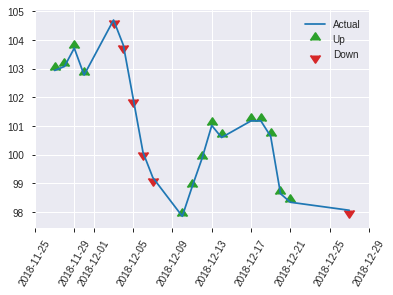


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21451414975331679
RMSE: 0.46315672266881414
LogLoss: 0.6309230123408126
Mean Per-Class Error: 0.3214285714285714
AUC: 0.7450738916256157
pr_auc: 0.7113127414372099
Gini: 0.4901477832512313
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39551196339413497: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   73   0.5489   (73.0/133.0)
1      14   102  0.1207   (14.0/116.0)
Total  74   175  0.3494   (87.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395512     0.701031  174
max f2                       0.0592521    0.826149  231
max f0point5                 0.735067     0.696023  58
max accuracy                 0.735067     0.690763  58
max precision                0.819931     0.928571  27
max recall                   0.021611     1         241
max specificity              0.991206     0.992481  0
max absolute_mcc             0.735067     0.407347  58
max min_per_class_accuracy   0.597581     0.663793  120
max mean_per_class_accuracy  0.692414     0.678571  76

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 52.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.980042           1.43103   1.43103            0.666667         0.986623   0.666667                    0.986623            0.0172414       0.0172414                  43.1034   43.1034
    2        0.0200803                   0.944852           1.07328   1.28793            0.5              0.971346   0.6                         0.980512            0.00862069      0.0258621                  7.32759   28.7931
    3        0.0321285                   0.935797           2.14655   1.60991            1                0.941968   0.75                        0.966058            0.0258621       0.0517241                  114.655   60.9914
    4        0.0401606                   0.901956           2.14655   1.71724            1                0.918379   0.8                         0.956522            0.0172414       0.0689655                  114.655   71.7241
    5        0.0522088                   0.867576           2.14655   1.81631            1                0.886794   0.846154                    0.940431            0.0258621       0.0948276                  114.655   81.6313
    6        0.100402                    0.833014           2.14655   1.97483            1                0.849084   0.92                        0.896584            0.103448        0.198276                   114.655   97.4828
    7        0.15261                     0.796922           1.65119   1.86411            0.769231         0.811922   0.868421                    0.867621            0.0862069       0.284483                   65.1194   86.4111
    8        0.200803                    0.757578           1.60991   1.8031             0.75             0.773384   0.84                        0.845004            0.0775862       0.362069                   60.9914   80.3103
    9        0.301205                    0.693991           1.20207   1.60276            0.56             0.722125   0.746667                    0.804044            0.12069         0.482759                   20.2069   60.2759
    10       0.401606                    0.653185           0.858621  1.41672            0.4              0.673541   0.66                        0.771419            0.0862069       0.568966                   -14.1379  41.6724
    11       0.502008                    0.5897             1.03034   1.33945            0.48             0.622937   0.624                       0.741722            0.103448        0.672414                   3.03448   33.9448
    12       0.598394                    0.528806           0.983836  1.28217            0.458333         0.563826   0.597315                    0.713068            0.0948276       0.767241                   -1.61638  28.2168
    13       0.698795                    0.395669           1.03034   1.24599            0.48             0.47189    0.58046                     0.678416            0.103448        0.87069                    3.03448   24.5987
    14       0.799197                    0.20254            0.515172  1.15418            0.24             0.301911   0.537688                    0.631116            0.0517241       0.922414                   -48.4828  15.4176
    15       0.899598                    0.0880271          0.515172  1.08286            0.24             0.144885   0.504464                    0.576849            0.0517241       0.974138                   -48.4828  8.28587
    16       1                           0.00141096         0.257586  1                  0.12             0.0388653  0.465863                   

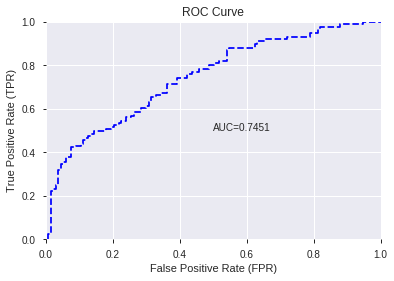

This function is available for GLM models only


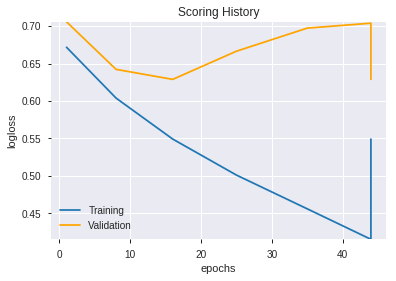

--2019-08-28 15:27:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


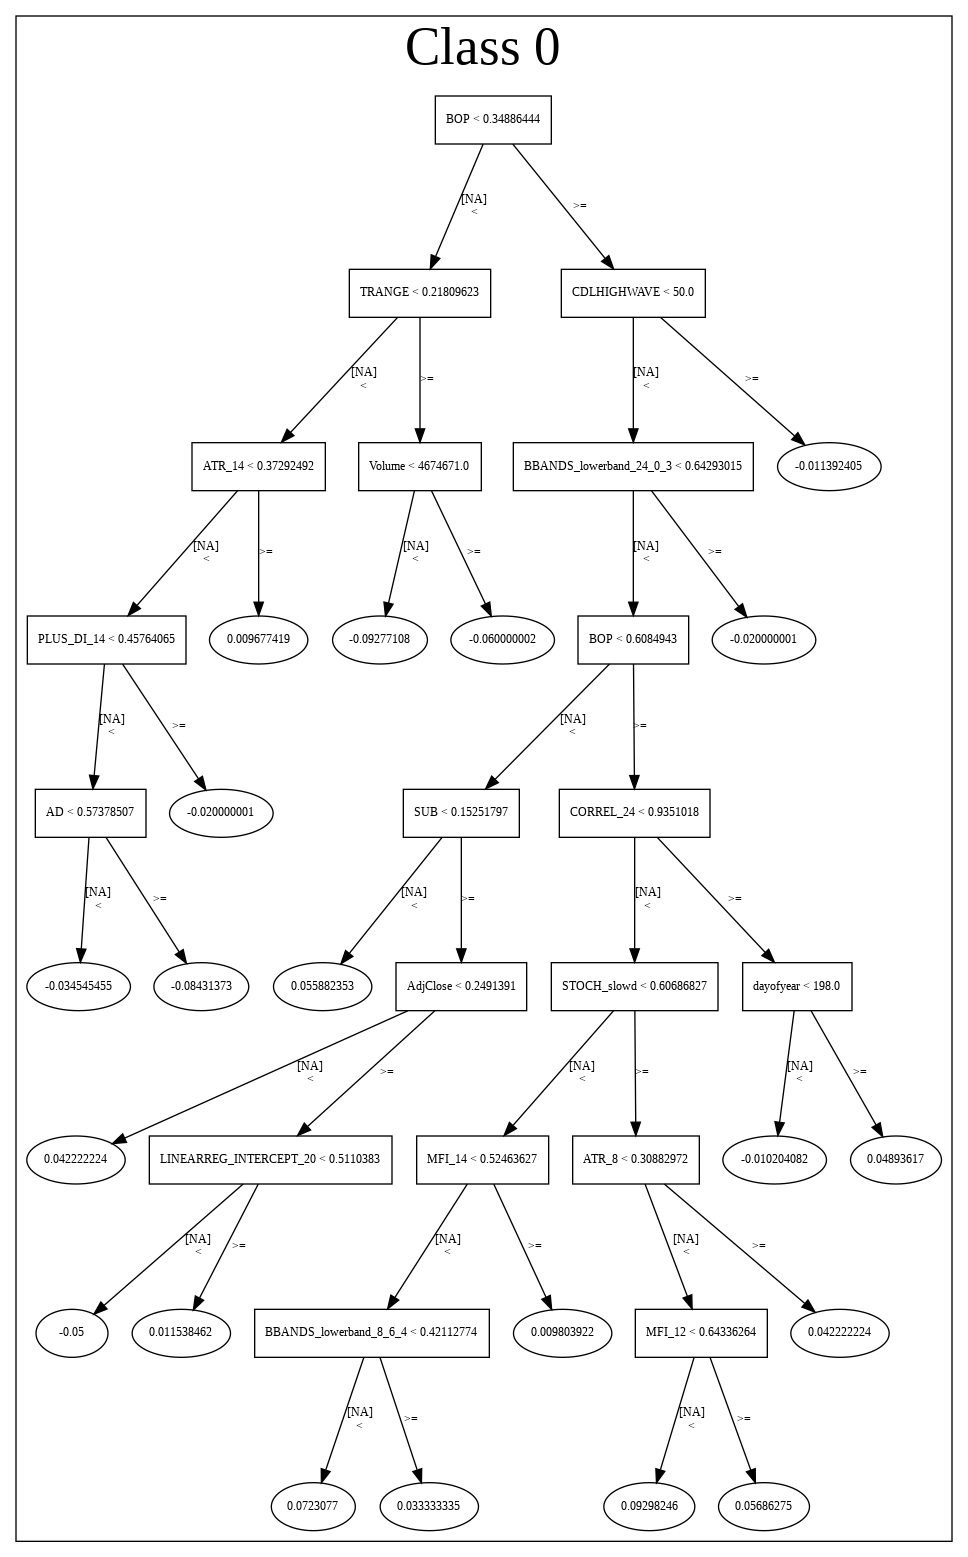

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_152004_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_152004_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'day',
 'CORREL_14',
 'SIN',
 'CDLCLOSINGMARUBOZU',
 'weekday_name',
 'OBV',
 'aroonup_14',
 'SAREXT',
 'days_in_month',
 'CDLMARUBOZU',
 'dayofweek',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'TRANGE',
 'weekday',
 'MACDEXT_hist',
 'CDLRICKSHAWMAN',
 'AROONOSC_8',
 'STOCHRSI_fastd',
 'aroondown_8',
 'DIV',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'WILLR_30',
 'STOCH_slowd',
 'HT_PHASOR_quadrature',
 'quarter',
 'ULTOSC',
 'RSI_8',
 'Volume',
 'CDLSHORTLINE',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'ADOSC',
 'month',
 'week',
 'weekofyear',
 'WILLR_14',
 'dayofyear',
 'WILLR_24',
 'WILLR_20',
 'WILLR_12',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'CDLDARKCLOUDCOVER',
 'CDLTAKURI']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_152800_model_1  0.747083  0.593552              0.315984  0.451463  0.203819

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.513922           1.000000    0.132654
1                    SUB             0.317473           0.617745    0.081946
2           STOCHF_fastk             0.231162           0.449799    0.059668
3                 ULTOSC             0.185391           0.360738    0.047853
4                  RSI_8             0.182708           0.355516    0.047161
5               WILLR_12             0.133039           0.258871    0.034340
6            STOCH_slowd             0.125304           0.243819    0.032344
7                quarter             0.118867           0.231293    0.030682
8                 TRANGE             0.114189           0.222190    0.029474
9     CDLCLOSINGMARUBOZU             0.108565           0.211247    0.028023
10                SAREXT             0.099241           0.193104    0.025616
11          MACDEXT_hist             0.095537           0.185898    0.024660
12          CDLENGULFING             0.095003           0.184859    0.024522
13        STOCHRSI_fastd             0.092068           0.179149    0.023765
14           CDLMARUBOZU             0.089117           0.173406    0.023003
15            aroonup_14             0.087552           0.170360    0.022599
16                Volume             0.083433           0.162345    0.021536
17     CDLINVERTEDHAMMER             0.081340           0.158272    0.020995
18                   SIN             0.078927           0.153577    0.020373
19                   OBV             0.077002           0.149832    0.019876
20                   day             0.070434           0.137052    0.018181
21              WILLR_20             0.066575           0.129542    0.017184
22     CDLDARKCLOUDCOVER             0.065508           0.127466    0.016909
23            AROONOSC_8             0.063470           0.123501    0.016383
24              WILLR_30             0.056699           0.110327    0.014635
25           CDLBELTHOLD             0.054104           0.105277    0.013965
26           aroondown_8             0.052521           0.102197    0.013557
27              WILLR_14             0.051392           0.100000    0.013265
28             CDLTAKURI             0.047490           0.092408    0.012258
29      CDLDRAGONFLYDOJI             0.047472           0.092372    0.012254
30        CDLRICKSHAWMAN             0.045502           0.088538    0.011745
31  HT_PHASOR_quadrature             0.043041           0.083749    0.011110
32          weekday_name             0.032416           0.063076    0.008367
33             dayofyear             0.025528           0.049672    0.006589
34                  week             0.024776           0.048209    0.006395
35         days_in_month             0.024717           0.048094    0.006380
36            weekofyear             0.024552           0.047774    0.006337
37               WILLR_8             0.024023           0.046745    0.006201
38             CORREL_14             0.021766           0.042353    0.005618
39          CDLSHORTLINE             0.021564           0.041961    0.005566
40     CDLLONGLEGGEDDOJI             0.020011           0.038938    0.005165
41        STOCHRSI_fastk             0.018257           0.035525    0.004712
42                 month             0.018235           0.035482    0.004707
43                   DIV             0.015926           0.030989    0.004111
44                 ADOSC             0.008917           0.017350    0.002302
45              WILLR_24             0.008631           0.016794    0.002228
46           CDLLONGLINE             0.007030           0.013679    0.001815
47               CDLDOJI             0.002942           0.005725    0.000759
48               weekday             0.000468           0.000912    0.000121
49             dayofweek             0.000354           0.000688    0.000091

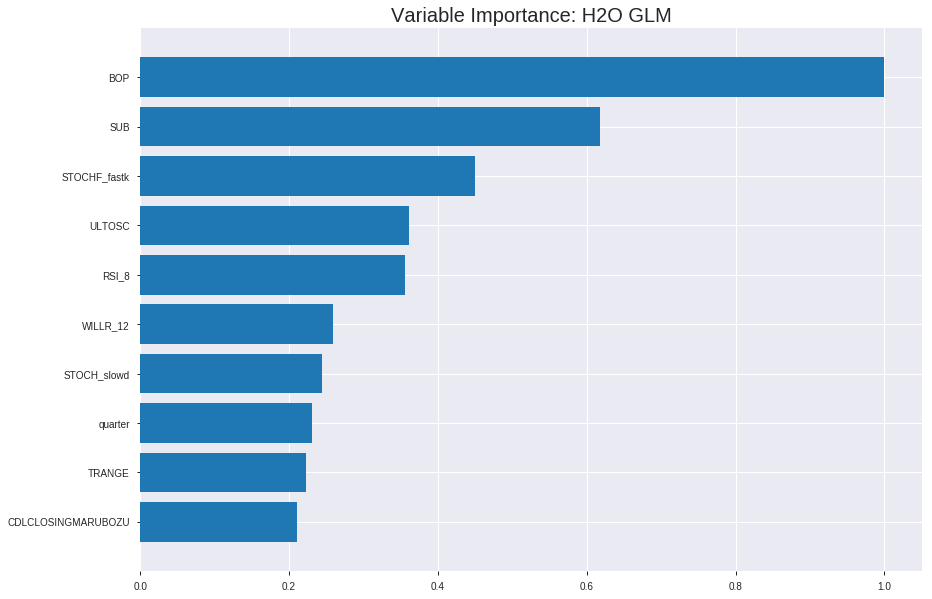

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_152800_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20049679519660216
RMSE: 0.44776868492180444
LogLoss: 0.5860745096005047
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2411.5386742145693
Residual deviance: 2040.711442428957
AIC: 2142.711442428957
AUC: 0.7529680274805126
pr_auc: 0.7286044662474307
Gini: 0.5059360549610252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3549387827614107: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      336  505   0.6005   (505.0/841.0)
1      68   832   0.0756   (68.0/900.0)
Total  404  1337  0.3291   (573.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354939     0.743853  278
max f2                       0.208607     0.858635  339
max f0point5                 0.577381     0.703125  163
max accuracy                 0.468379     0.697875  221
max precision                0.945206     1         0
max recall                   0.0884274    1         387
max specificity              0.945206     1         0
max absolute_mcc             0.468379     0.398407  221
max min_per_class_accuracy   0.537575     0.689655  186
max mean_per_class_accuracy  0.468379     0.694331  221

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.883969           1.50457   1.50457            0.777778         0.903621  0.777778                    0.903621            0.0155556       0.0155556                  50.4568   50.4568
    2        0.0201034                   0.863339           1.70686   1.60283            0.882353         0.872611  0.828571                    0.888559            0.0166667       0.0322222                  70.6863   60.2825
    3        0.0304423                   0.847555           1.71951   1.64245            0.888889         0.855919  0.849057                    0.877474            0.0177778       0.05                       71.9506   64.2453
    4        0.0402068                   0.833747           1.59307   1.63046            0.823529         0.839905  0.842857                    0.86835             0.0155556       0.0655556                  59.3072   63.046
    5        0.0505457                   0.823322           1.28963   1.56074            0.666667         0.828128  0.806818                    0.860122            0.0133333       0.0788889                  28.963    56.0745
    6        0.100517                    0.769183           1.60092   1.58072            0.827586         0.793001  0.817143                    0.826753            0.08            0.158889                   60.092    58.0717
    7        0.150488                    0.731562           1.26739   1.47668            0.655172         0.751191  0.763359                    0.801662            0.0633333       0.222222                   26.7395   47.6675
    8        0.20046                     0.700732           1.35633   1.44668            0.701149         0.716918  0.747851                    0.780537            0.0677778       0.29                       35.6335   44.6676
    9        0.300402                    0.650687           1.45639   1.44991            0.752874         0.676106  0.749522                    0.745793            0.145556        0.435556                   45.6392   44.9909
    10       0.400345                    0.601398           1.35633   1.42655            0.701149         0.625552  0.737446                    0.715776            0.135556        0.571111                   35.6335   42.6549
    11       0.500287                    0.541212           1.11175   1.36366            0.574713         0.572187  0.704937                    0.687091            0.111111        0.682222                   11.175    36.3661
    12       0.60023                     0.479569           1.01169   1.30506            0.522989         0.511839  0.674641                    0.65791             0.101111        0.783333                   1.16922   30.5056
    13       0.700172                    0.406702           0.833812  1.23779            0.431034         0.441581  0.639869                    0.627032            0.0833333       0.866667                   -16.6188  23.7791
    14       0.800115                    0.323457           0.744872  1.17622            0.385057         0.366878  0.60804                     0.594536            0.0744444       0.941111                   -25.5128  17.622
    15       0.900057                    0.210451           0.433582  1.09376            0.224138         0.268837  0.565412                    0.55837             0.0433333       0.984444                   -56.6418  9.37574
    16       1                           0.0269188          0.155645  1                  0.0804598        0.143875  0.516944                    0.516944           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2034532007613828
RMSE: 0.45105786852839935
LogLoss: 0.5936008900152406
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.8619915534578
Residual deviance: 591.2264864551797
AIC: 693.2264864551797
AUC: 0.7479374202818994
pr_auc: 0.7171266646643114
Gini: 0.4958748405637987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35290386736427604: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  132  0.5477   (132.0/241.0)
1      25   232  0.0973   (25.0/257.0)
Total  134  364  0.3153   (157.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352904     0.747182  283
max f2                       0.198456     0.85473   357
max f0point5                 0.4836       0.709434  207
max accuracy                 0.4836       0.702811  207
max precision                0.920596     1         0
max recall                   0.0805414    1         395
max specificity              0.920596     1         0
max absolute_mcc             0.4836       0.404567  207
max min_per_class_accuracy   0.502622     0.688797  196
max mean_per_class_accuracy  0.4836       0.701858  207

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 49.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.86845            1.55019   1.55019            0.8              0.892174  0.8                         0.892174            0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.844939           1.93774   1.74397            1                0.855111  0.9                         0.873643            0.0194553       0.0350195                  93.7743   74.3969
    3        0.0301205                   0.814195           1.16265   1.55019            0.6              0.830981  0.8                         0.859422            0.0116732       0.0466926                  16.2646   55.0195
    4        0.0401606                   0.802687           0.775097  1.35642            0.4              0.809273  0.7                         0.846885            0.0077821       0.0544747                  -22.4903  35.642
    5        0.0502008                   0.792947           1.16265   1.31767            0.6              0.79709   0.68                        0.836926            0.0116732       0.0661479                  16.2646   31.7665
    6        0.100402                    0.746831           1.6277    1.47268            0.84             0.771181  0.76                        0.804053            0.0817121       0.14786                    62.7704   47.2685
    7        0.150602                    0.710862           1.47268   1.47268            0.76             0.725888  0.76                        0.777998            0.07393         0.22179                    47.2685   47.2685
    8        0.200803                    0.681813           1.6277    1.51144            0.84             0.695275  0.78                        0.757317            0.0817121       0.303502                   62.7704   51.144
    9        0.301205                    0.634608           1.31767   1.44685            0.68             0.6553    0.746667                    0.723311            0.132296        0.435798                   31.7665   44.6848
    10       0.399598                    0.57341            1.30501   1.41192            0.673469         0.604719  0.728643                    0.69411             0.128405        0.564202                   30.5011   41.1923
    11       0.5                         0.505873           1.2014    1.36965            0.62             0.539609  0.706827                    0.663086            0.120623        0.684825                   20.1401   36.965
    12       0.600402                    0.452703           0.852607  1.28319            0.44             0.476744  0.662207                    0.631925            0.0856031       0.770428                   -14.7393  28.3188
    13       0.698795                    0.382627           1.06774   1.25285            0.55102          0.421032  0.646552                    0.60223             0.105058        0.875486                   6.7736    25.2851
    14       0.799197                    0.303292           0.542568  1.16362            0.28             0.338251  0.600503                    0.569067            0.0544747       0.929961                   -45.7432  16.362
    15       0.899598                    0.205075           0.503813  1.08998            0.26             0.253423  0.5625                      0.533839            0.0505837       0.980545                   -49.6187  8.99805
    16       1                           0.0230614          0.193774  1                  0.1              0.139334  0.516064                    0.49423             0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:28:00  0.000 sec   2            18        51            1.36646           1.36882
    2019-08-28 15:28:00  0.013 sec   4            11        51            1.35723           1.36055
    2019-08-28 15:28:00  0.026 sec   6            7.1       51            1.3447            1.34914
    2019-08-28 15:28:00  0.038 sec   8            4.4       51            1.32873           1.33423
    2019-08-28 15:28:00  0.051 sec   10           2.8       51            1.30959           1.31582
    2019-08-28 15:28:00  0.067 sec   12           1.7       51            1.28826           1.29459
    2019-08-28 15:28:00  0.079 sec   14           1.1       51            1.26636           1.27202
    2019-08-28 15:28:00  0.092 sec   16           0.66      51            1.24565           1.25006
    2019-08-28 15:28:00  0.105 sec   18           0.41      51            1.22754           1.23057
    2019-08-28 15:28:00  0.118 sec   20           0.25      51            1.21261           1.21473
    2019-08-28 15:28:00  0.131 sec   22           0.16      51            1.20067           1.20289
    2019-08-28 15:28:00  0.144 sec   24           0.098     51            1.19115           1.19479
    2019-08-28 15:28:00  0.158 sec   26           0.061     51            1.18349           1.1899
    2019-08-28 15:28:00  0.176 sec   28           0.038     51            1.17725           1.18761
    2019-08-28 15:28:00  0.189 sec   30           0.023     51            1.17215           1.1872
    2019-08-28 15:28:01  0.202 sec   32           0.015     51            1.16802           1.1881
    2019-08-28 15:28:01  0.214 sec   34           0.0091    51            1.16478           1.18989
    2019-08-28 15:28:01  0.227 sec   36           0.0056    51            1.16238           1.1922
    2019-08-28 15:28:01  0.239 sec   38           0.0035    51            1.16074           1.1947
    2019-08-28 15:28:01  0.252 sec   40           0.0022    51            1.1597            1.19709

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7132867132867132)

('auc', 0.7470832253046409)

('logloss', 0.5935517502206082)

('mean_per_class_error', 0.300589836660617)

('rmse', 0.451463493107194)

('mse', 0.20381928560854942)

glm prediction progress: |████████████████████████████████████████████████| 100%


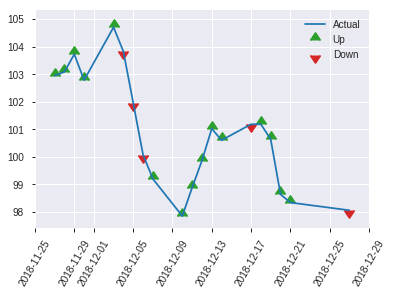


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20381928560854942
RMSE: 0.451463493107194
LogLoss: 0.5935517502206082
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 346.62607336051315
Residual deviance: 295.58877160986293
AIC: 397.58877160986293
AUC: 0.7470832253046409
pr_auc: 0.6973910690237917
Gini: 0.49416645060928177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3637126965555923: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   68   0.5113   (68.0/133.0)
1      14   102  0.1207   (14.0/116.0)
Total  79   170  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363713     0.713287  169
max f2                       0.220094     0.844347  216
max f0point5                 0.621914     0.672043  63
max accuracy                 0.471524     0.694779  133
max precision                0.878296     1         0
max recall                   0.0633763    1         247
max specificity              0.878296     1         0
max absolute_mcc             0.466321     0.40025   137
max min_per_class_accuracy   0.513078     0.663793  120
max mean_per_class_accuracy  0.466321     0.69941   137

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.826873           1.43103    1.43103            0.666667         0.86127   0.666667                    0.86127             0.0172414       0.0172414                  43.1034   43.1034
    2        0.0200803                   0.802375           2.14655    1.71724            1                0.810923  0.8                         0.841131            0.0172414       0.0344828                  114.655   71.7241
    3        0.0321285                   0.780331           1.43103    1.60991            0.666667         0.791545  0.75                        0.822537            0.0172414       0.0517241                  43.1034   60.9914
    4        0.0401606                   0.764678           2.14655    1.71724            1                0.778152  0.8                         0.81366             0.0172414       0.0689655                  114.655   71.7241
    5        0.0522088                   0.755216           2.14655    1.81631            1                0.758923  0.846154                    0.801028            0.0258621       0.0948276                  114.655   81.6313
    6        0.100402                    0.7163             2.14655    1.97483            1                0.733048  0.92                        0.768398            0.103448        0.198276                   114.655   97.4828
    7        0.15261                     0.6871             1.15584    1.69465            0.538462         0.702031  0.789474                    0.745693            0.0603448       0.258621                   15.5836   69.4646
    8        0.200803                    0.647992           1.60991    1.67431            0.75             0.664711  0.78                        0.726257            0.0775862       0.336207                   60.9914   67.431
    9        0.301205                    0.606956           1.37379    1.57414            0.64             0.62445   0.733333                    0.692322            0.137931        0.474138                   37.3793   57.4138
    10       0.401606                    0.546356           0.686897   1.35233            0.32             0.574338  0.63                        0.662826            0.0689655       0.543103                   -31.3103  35.2328
    11       0.502008                    0.491289           1.37379    1.35662            0.64             0.523035  0.632                       0.634868            0.137931        0.681034                   37.3793   35.6621
    12       0.598394                    0.440432           1.25216    1.33979            0.583333         0.467419  0.624161                    0.607896            0.12069         0.801724                   25.2155   33.9794
    13       0.698795                    0.353421           0.772759   1.25832            0.36             0.395411  0.586207                    0.577367            0.0775862       0.87931                    -22.7241  25.8323
    14       0.799197                    0.271967           0.42931    1.15418            0.2              0.313892  0.537688                    0.544267            0.0431034       0.922414                   -57.069   15.4176
    15       0.899598                    0.196252           0.686897   1.10202            0.32             0.231334  0.513393                    0.509341            0.0689655       0.991379                   -31.3103  10.2024
    16       1                           0.0301156          0.0858621  1                  0.04             0.136613  0.465863                    

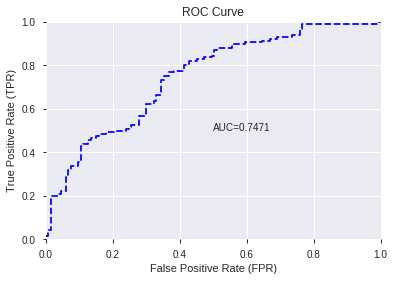

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


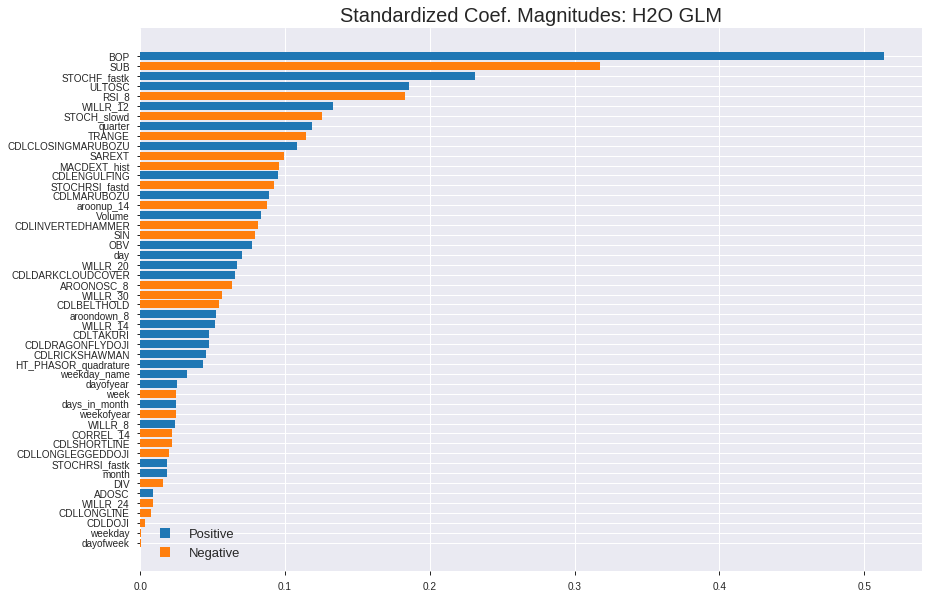

'log_likelihood'
--2019-08-28 15:28:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


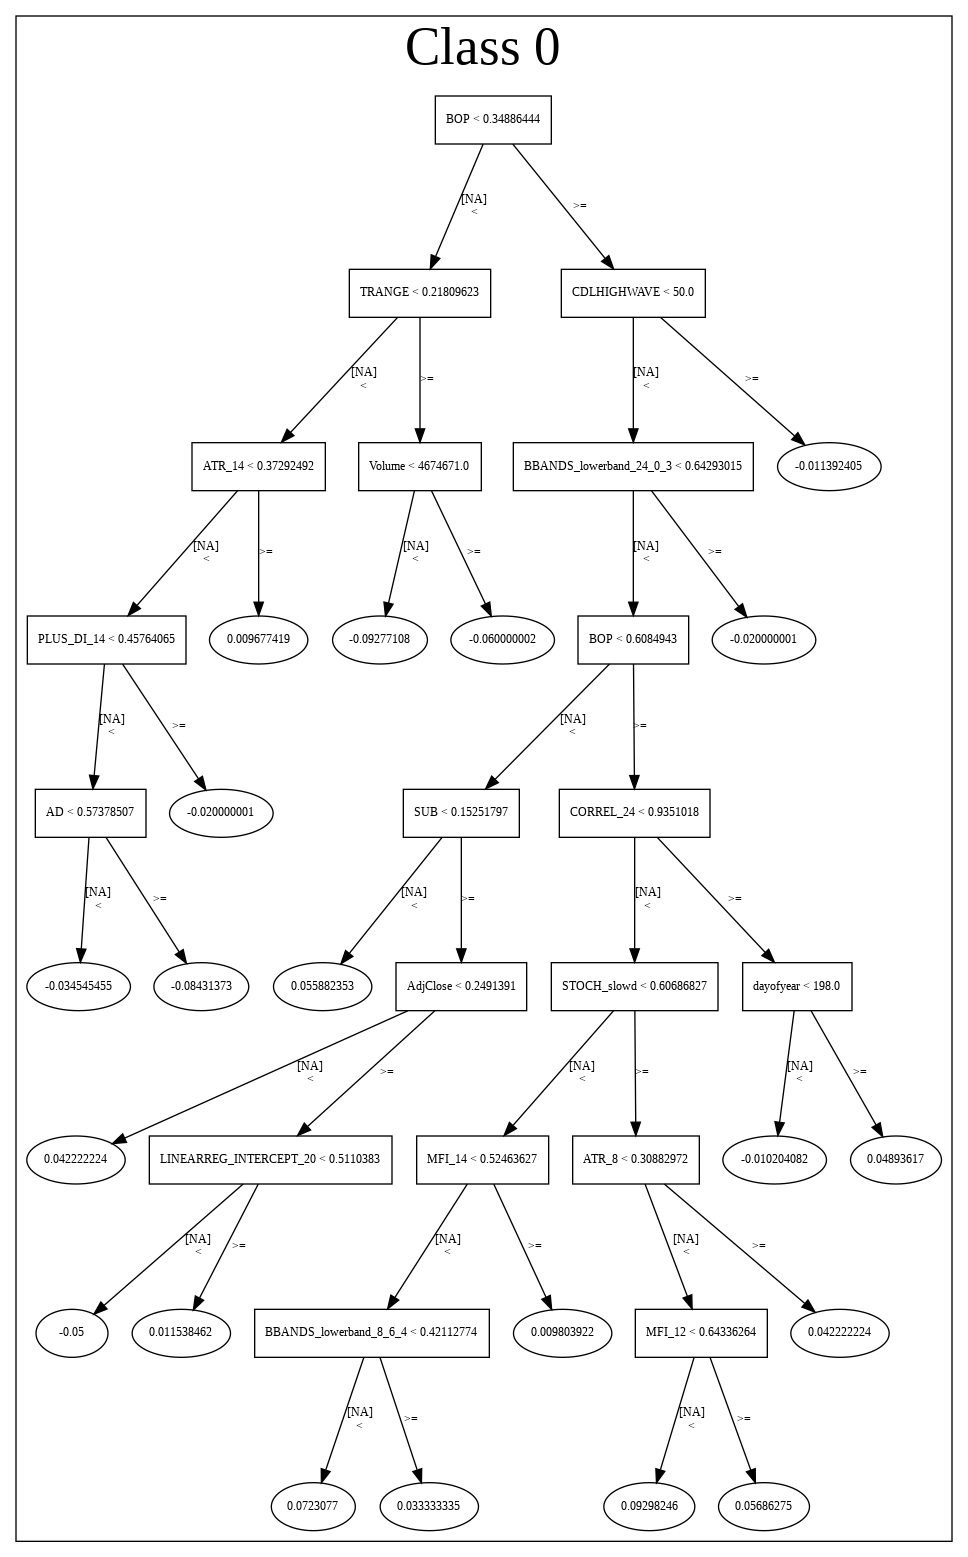

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_152800_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_152800_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SUB',
 'STOCHF_fastk',
 'ULTOSC',
 'RSI_8',
 'WILLR_12',
 'STOCH_slowd',
 'quarter',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'SAREXT',
 'MACDEXT_hist',
 'CDLENGULFING',
 'STOCHRSI_fastd',
 'CDLMARUBOZU',
 'aroonup_14',
 'Volume',
 'CDLINVERTEDHAMMER',
 'SIN',
 'OBV',
 'day',
 'WILLR_20',
 'CDLDARKCLOUDCOVER',
 'AROONOSC_8',
 'WILLR_30',
 'CDLBELTHOLD',
 'aroondown_8',
 'WILLR_14',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'HT_PHASOR_quadrature',
 'weekday_name',
 'dayofyear',
 'week',
 'days_in_month',
 'weekofyear',
 'WILLR_8',
 'CORREL_14',
 'CDLSHORTLINE',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastk',
 'month',
 'DIV',
 'ADOSC',
 'WILLR_24',
 'CDLLONGLINE',
 'CDLDOJI',
 'weekday',
 'dayofweek']

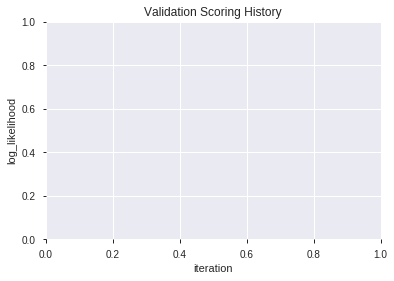

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_152816_model_7  0.752982  0.589322              0.319290  0.449940  0.202446
1  XGBoost_grid_1_AutoML_20190828_152816_model_4  0.746305  0.598030              0.306359  0.453966  0.206086
2  XGBoost_grid_1_AutoML_20190828_152816_model_3  0.745333  0.592729              0.327262  0.452268  0.204547
3               XGBoost_2_AutoML_20190828_152816  0.742611  0.599905              0.312873  0.454777  0.206823
4  XGBoost_grid_1_AutoML_20190828_152816_model_1  0.740213  0.612811              0.322498  0.458818  0.210514
5  XGBoost_grid_1_AutoML_20190828_152816_model_5  0.734768  0.611616              0.300136  0.458562  0.210279
6  XGBoost_grid_1_AutoML_20190828_152816_model_6  0.731073  0.606235              0.320294  0.457625  0.209420
7               XGBoost_3_AutoML_20190828_152816  0.728934  0.610881              0.323600  0.459549  0.211186
8  XGBoost_grid_1_AutoML_20190828_152816_model_2  0.726082  0.608560              0.326257  0.459359  0.211011
9               XGBoost_1_AutoML_20190828_152816  0.717786  0.616898              0.347712  0.463378  0.214719

variable  relative_importance  scaled_importance  percentage
0                    BOP          1605.671875           1.000000    0.158245
1           STOCHF_fastk           693.176331           0.431705    0.068315
2                    SUB           581.843750           0.362368    0.057343
3                 TRANGE           473.770813           0.295061    0.046692
4                    OBV           428.270844           0.266724    0.042208
5                 ULTOSC           342.309814           0.213188    0.033736
6                 Volume           335.655823           0.209044    0.033080
7              CORREL_14           334.496399           0.208322    0.032966
8                    SIN           321.309479           0.200109    0.031666
9                 SAREXT           320.318848           0.199492    0.031569
10                   DIV           317.072052           0.197470    0.031249
11        STOCHRSI_fastd           304.865540           0.189868    0.030046
12           STOCH_slowd           281.074310           0.175051    0.027701
13             dayofyear           262.278534           0.163345    0.025848
14          MACDEXT_hist           257.930237           0.160637    0.025420
15                 ADOSC           256.051086           0.159467    0.025235
16              WILLR_12           255.552551           0.159156    0.025186
17        STOCHRSI_fastk           243.158279           0.151437    0.023964
18                 RSI_8           225.701385           0.140565    0.022244
19               WILLR_8           221.962616           0.138237    0.021875
20                   day           206.293304           0.128478    0.020331
21            aroonup_14           184.307419           0.114785    0.018164
22              WILLR_20           182.040466           0.113373    0.017941
23              WILLR_30           179.285370           0.111658    0.017669
24            AROONOSC_8           176.563828           0.109963    0.017401
25              WILLR_14           176.449188           0.109891    0.017390
26  HT_PHASOR_quadrature           174.523315           0.108692    0.017200
27              WILLR_24           149.877701           0.093343    0.014771
28           aroondown_8           140.611404           0.087572    0.013858
29                  week           117.906906           0.073432    0.011620
30          weekday_name            86.527054           0.053888    0.008528
31    CDLCLOSINGMARUBOZU            77.388863           0.048197    0.007627
32             dayofweek            76.920837           0.047906    0.007581
33            weekofyear            37.980431           0.023654    0.003743
34               weekday            30.065159           0.018724    0.002963
35           CDLLONGLINE            22.126644           0.013780    0.002181
36                 month            20.588993           0.012823    0.002029
37               CDLDOJI            13.570419           0.008452    0.001337
38          CDLENGULFING            12.644997           0.007875    0.001246
39         days_in_month            10.081151           0.006278    0.000994
40     CDLLONGLEGGEDDOJI             3.534816           0.002201    0.000348
41               quarter             3.471595           0.002162    0.000342
42           CDLBELTHOLD             1.542978           0.000961    0.000152

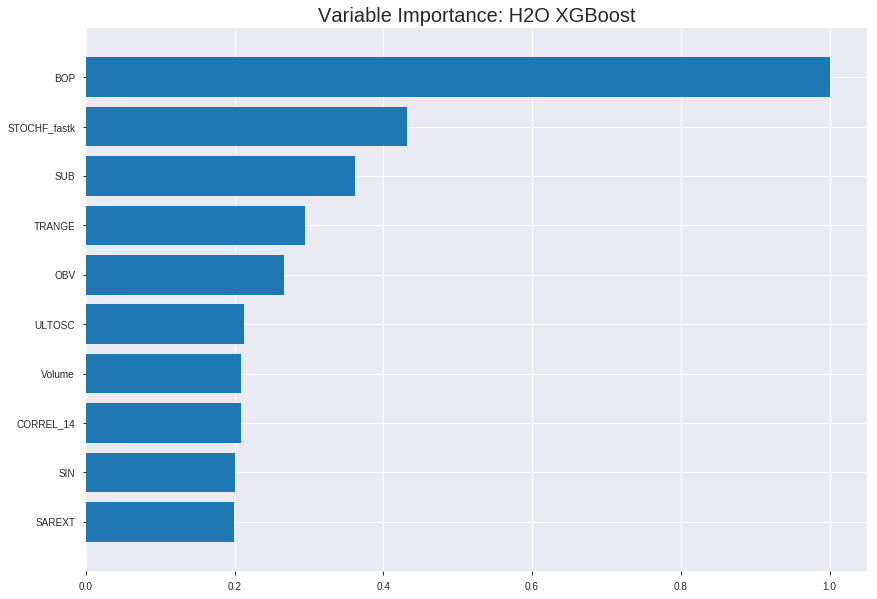

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_152816_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11575678018100534
RMSE: 0.3402304809698939
LogLoss: 0.392088509986573
Mean Per-Class Error: 0.10737746069493992
AUC: 0.9589992072929052
pr_auc: 0.964226184855123
Gini: 0.9179984145858104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5299190580844879: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      746  95   0.113    (95.0/841.0)
1      96   804  0.1067   (96.0/900.0)
Total  842  899  0.1097   (191.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.529919     0.89383   188
max f2                       0.414097     0.918043  238
max f0point5                 0.625878     0.923626  143
max accuracy                 0.560866     0.891442  172
max precision                0.907248     1         0
max recall                   0.172024     1         342
max specificity              0.907248     1         0
max absolute_mcc             0.560866     0.785523  172
max min_per_class_accuracy   0.532032     0.888228  187
max mean_per_class_accuracy  0.560866     0.892623  172

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.882282           1.93444   1.93444            1                0.893767   1                           0.893767            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.870988           1.93444   1.93444            1                0.877192   1                           0.885716            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.860898           1.93444   1.93444            1                0.866141   1                           0.879068            0.02            0.0588889                  93.4444   93.4444
    4        0.0402068                   0.852743           1.93444   1.93444            1                0.856734   1                           0.873644            0.0188889       0.0777778                  93.4444   93.4444
    5        0.0505457                   0.847492           1.93444   1.93444            1                0.849793   1                           0.868765            0.02            0.0977778                  93.4444   93.4444
    6        0.100517                    0.816124           1.93444   1.93444            1                0.831808   1                           0.850392            0.0966667       0.194444                   93.4444   93.4444
    7        0.150488                    0.788188           1.93444   1.93444            1                0.800331   1                           0.833769            0.0966667       0.291111                   93.4444   93.4444
    8        0.20046                     0.762295           1.91221   1.9289             0.988506         0.773725   0.997135                    0.818801            0.0955556       0.386667                   91.2209   92.8902
    9        0.300402                    0.706775           1.91221   1.92335            0.988506         0.735424   0.994264                    0.791062            0.191111        0.577778                   91.2209   92.3348
    10       0.400345                    0.634204           1.7788    1.88726            0.91954          0.67033    0.97561                     0.760922            0.177778        0.755556                   77.8799   88.7263
    11       0.500287                    0.544989           1.21181   1.75233            0.626437         0.591089   0.905855                    0.726995            0.121111        0.876667                   21.1807   75.2327
    12       0.60023                     0.452496           0.633697  1.56607            0.327586         0.501038   0.809569                    0.689371            0.0633333       0.94                       -36.6303  56.6067
    13       0.700172                    0.366205           0.411347  1.40124            0.212644         0.408574   0.724364                    0.64929             0.0411111       0.981111                   -58.8653  40.1242
    14       0.800115                    0.259794           0.166762  1.24704            0.0862069        0.311931   0.644652                    0.60715             0.0166667       0.997778                   -83.3238  24.7043
    15       0.900057                    0.148705           0.022235  1.11104            0.0114943        0.203483   0.574346                    0.562327            0.00222222      1                          -97.7765  11.104
    16       1                           0.0412307          0         1                  0                0.0981992  0.516944                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20202903255600801
RMSE: 0.4494763982190923
LogLoss: 0.5908531884792569
Mean Per-Class Error: 0.2950175178003456
AUC: 0.7577780648077885
pr_auc: 0.7361701489710079
Gini: 0.5155561296155771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3912355303764343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      137  104  0.4315   (104.0/241.0)
1      41   216  0.1595   (41.0/257.0)
Total  178  320  0.2912   (145.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391236     0.7487    252
max f2                       0.125186     0.852273  373
max f0point5                 0.440622     0.704626  227
max accuracy                 0.407689     0.708835  245
max precision                0.876542     1         0
max recall                   0.0701836    1         392
max specificity              0.876542     1         0
max absolute_mcc             0.391236     0.426423  252
max min_per_class_accuracy   0.493289     0.680498  197
max mean_per_class_accuracy  0.407689     0.704982  245

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.84007            1.55019   1.55019            0.8              0.854857  0.8                         0.854857            0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.817613           1.55019   1.55019            0.8              0.829154  0.8                         0.842005            0.0155642       0.0311284                  55.0195   55.0195
    3        0.0301205                   0.802567           1.55019   1.55019            0.8              0.811165  0.8                         0.831725            0.0155642       0.0466926                  55.0195   55.0195
    4        0.0401606                   0.787653           1.55019   1.55019            0.8              0.797674  0.8                         0.823213            0.0155642       0.0622568                  55.0195   55.0195
    5        0.0502008                   0.772328           1.16265   1.47268            0.6              0.780852  0.76                        0.81474             0.0116732       0.07393                    16.2646   47.2685
    6        0.100402                    0.741146           1.70521   1.58895            0.88             0.757004  0.82                        0.785872            0.0856031       0.159533                   70.5214   58.8949
    7        0.150602                    0.700422           1.6277    1.60187            0.84             0.719068  0.826667                    0.763604            0.0817121       0.241245                   62.7704   60.1868
    8        0.200803                    0.679615           1.78272   1.64708            0.92             0.690301  0.85                        0.745278            0.0894942       0.330739                   78.2724   64.7082
    9        0.301205                    0.614207           1.24016   1.51144            0.64             0.646379  0.78                        0.712312            0.124514        0.455253                   24.0156   51.144
    10       0.399598                    0.559995           1.10728   1.41192            0.571429         0.588414  0.728643                    0.681804            0.108949        0.564202                   10.7282   41.1923
    11       0.5                         0.495019           1.04638   1.33852            0.54             0.527434  0.690763                    0.650806            0.105058        0.669261                   4.63813   33.8521
    12       0.600402                    0.431215           1.2014    1.31559            0.62             0.460363  0.67893                     0.61896             0.120623        0.789883                   20.1401   31.5592
    13       0.698795                    0.330988           0.830461  1.24728            0.428571         0.385072  0.643678                    0.586027            0.0817121       0.871595                   -16.9539  24.7283
    14       0.799197                    0.248513           0.542568  1.15875            0.28             0.293333  0.59799                     0.549256            0.0544747       0.92607                    -45.7432  15.8751
    15       0.899598                    0.15495            0.465058  1.08133            0.24             0.203066  0.558036                    0.510619            0.0466926       0.972763                   -53.4942  8.13299
    16       1                           0.0455539          0.271284  1                  0.14             0.109289  0.516064                    0.470325          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:28:33  10.734 sec  0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-28 15:28:33  10.879 sec  5                  0.470735         0.635955            0.862595        0.863614           1.93444          0.225158                         0.483972           0.661421              0.727328          0.709858             1.55019            0.331325
    2019-08-28 15:28:33  10.982 sec  10                 0.447438         0.591583            0.882829        0.89014            1.93444          0.210798                         0.47093            0.635791              0.760095          0.74694              1.93774            0.335341
    2019-08-28 15:28:33  11.081 sec  15                 0.428917         0.556445            0.894015        0.89963            1.93444          0.20046                          0.46298            0.619898              0.755744          0.739516             1.93774            0.327309
    2019-08-28 15:28:33  11.183 sec  20                 0.413365         0.526842            0.903126        0.911656           1.93444          0.194716                         0.457609           0.608892              0.758335          0.747549             1.93774            0.307229
    2019-08-28 15:28:33  11.271 sec  25                 0.401814         0.504712            0.909071        0.917867           1.93444          0.189546                         0.45484            0.603077              0.758844          0.749811             1.93774            0.317269
    2019-08-28 15:28:33  11.361 sec  30                 0.39269          0.486968            0.913283        0.922581           1.93444          0.178059                         0.451208           0.595694              0.76288           0.745847             1.55019            0.291165
    2019-08-28 15:28:33  11.460 sec  35                 0.382354         0.467572            0.922769        0.932359           1.93444          0.168868                         0.448364           0.589775              0.766271          0.758756             1.93774            0.301205
    2019-08-28 15:28:33  11.564 sec  40                 0.372744         0.449872            0.932258        0.941204           1.93444          0.148191                         0.448467           0.589647              0.763655          0.749966             1.55019            0.303213
    2019-08-28 15:28:34  11.679 sec  45                 0.363198         0.432742            0.941276        0.947521           1.93444          0.130959                         0.448522           0.589427              0.760773          0.749417             1.93774            0.293173
    2019-08-28 15:28:34  11.785 sec  50                 0.355512         0.418864            0.947917        0.954737           1.93444          0.122918                         0.448914           0.58971               0.759385          0.745901             1.93774            0.295181
    2019-08-28 15:28:34  11.894 sec  55                 0.347942         0.405342            0.95379         0.96002            1.93444          0.118897                         0.449369           0.590847              0.758254          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
BOP                1605.671875            1.0                    0.1582445779571743
STOCHF_fastk       693.1763305664062      0.4317048466495723     0.06831495126012822
SUB                581.84375              0.36236777828595895    0.05734273614014048
TRANGE             473.77081298828125     0.2950607906663877     0.04669177029071268
OBV                428.2708435058594      0.2667237622916322     0.04220758919498902
---                ---                    ---                    ---
CDLENGULFING       12.644996643066406     0.007875205912208187   0.0012462086359032285
days_in_month      10.081151008605957     0.006278462720539312   0.0009935326834315957
CDLLONGLEGGEDDOJI  3.534815549850464      0.0022014557300821277  0.0003483684328982493
quarter            3.471595287322998      0.002162082640528905   0.0003421378549590296
CDLBELTHOLD        1.542978286743164      0.000960954919100868   0.00015206590560898743


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7068273092369478)

('F1', 0.7007299270072993)

('auc', 0.7529815919108116)

('logloss', 0.5893216698623683)

('mean_per_class_error', 0.3047381384495722)

('rmse', 0.44994048312115814)

('mse', 0.2024464383513012)

xgboost prediction progress: |████████████████████████████████████████████| 100%


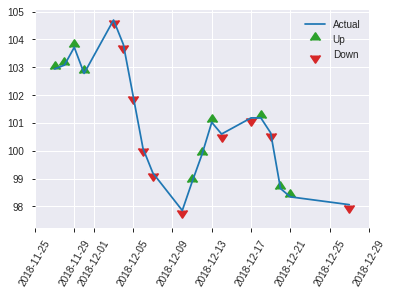


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2024464383513012
RMSE: 0.44994048312115814
LogLoss: 0.5893216698623683
Mean Per-Class Error: 0.3047381384495722
AUC: 0.7529815919108116
pr_auc: 0.7057658967717163
Gini: 0.5059631838216232
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3676694631576538: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   62   0.4662   (62.0/133.0)
1      20   96   0.1724   (20.0/116.0)
Total  91   158  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367669     0.70073   157
max f2                       0.0998091    0.835735  229
max f0point5                 0.5858       0.707547  76
max accuracy                 0.5858       0.706827  76
max precision                0.871968     1         0
max recall                   0.0998091    1         229
max specificity              0.871968     1         0
max absolute_mcc             0.5858       0.420306  76
max min_per_class_accuracy   0.465099     0.684211  121
max mean_per_class_accuracy  0.575662     0.695262  78

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 44.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.821111           2.14655   2.14655            1                0.841383   1                           0.841383            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.799681           2.14655   2.14655            1                0.813714   1                           0.830315            0.0172414       0.0431034                  114.655   114.655
    3        0.0321285                   0.787776           0.715517  1.60991            0.333333         0.793681   0.75                        0.816578            0.00862069      0.0517241                  -28.4483  60.9914
    4        0.0401606                   0.772251           1.07328   1.50259            0.5              0.780845   0.7                         0.809431            0.00862069      0.0603448                  7.32759   50.2586
    5        0.0522088                   0.759              2.14655   1.65119            1                0.766987   0.769231                    0.799636            0.0258621       0.0862069                  114.655   65.1194
    6        0.100402                    0.717611           1.78879   1.71724            0.833333         0.73317    0.8                         0.767732            0.0862069       0.172414                   78.8793   71.7241
    7        0.15261                     0.689726           1.65119   1.69465            0.769231         0.707473   0.789474                    0.747117            0.0862069       0.258621                   65.1194   69.4646
    8        0.200803                    0.649418           1.43103   1.63138            0.666667         0.665376   0.76                        0.727499            0.0689655       0.327586                   43.1034   63.1379
    9        0.301205                    0.589536           1.71724   1.66               0.8              0.624011   0.773333                    0.693003            0.172414        0.5                        71.7241   66
    10       0.401606                    0.533399           0.858621  1.45966            0.4              0.561502   0.68                        0.660128            0.0862069       0.586207                   -14.1379  45.9655
    11       0.502008                    0.463345           1.11621   1.39097            0.52             0.495378   0.648                       0.627178            0.112069        0.698276                   11.6207   39.0966
    12       0.598394                    0.400573           0.804957  1.29657            0.375            0.432163   0.604027                    0.595766            0.0775862       0.775862                   -19.5043  29.6575
    13       0.698795                    0.316577           0.858621  1.23365            0.4              0.352802   0.574713                    0.560857            0.0862069       0.862069                   -14.1379  23.365
    14       0.799197                    0.223851           0.772759  1.17575            0.36             0.281076   0.547739                    0.525709            0.0775862       0.939655                   -22.7241  17.5749
    15       0.899598                    0.12071            0.42931   1.09244            0.2              0.165937   0.508929                    0.485556            0.0431034       0.982759                   -57.069   9.24415
    16       1                           0.0471771          0.171724  1                  0.08             0.0806301  0.465863                    0.444

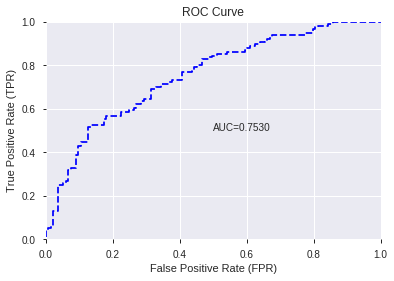

This function is available for GLM models only


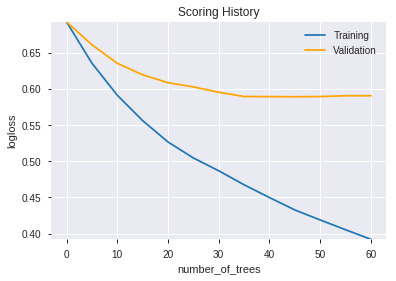

--2019-08-28 15:28:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

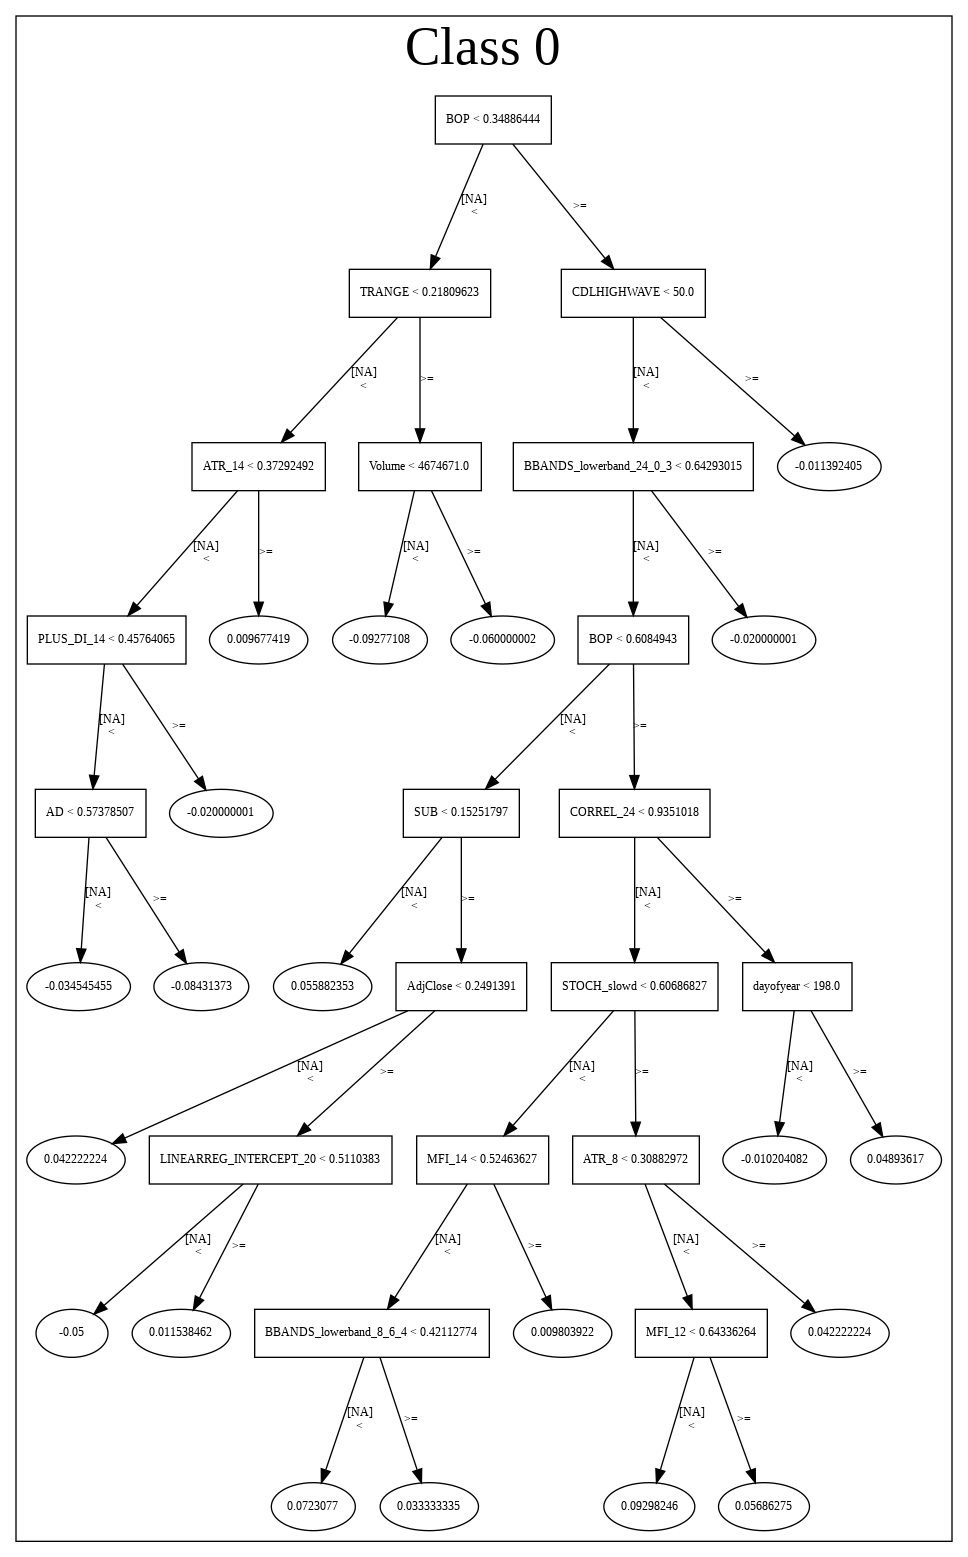

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_152816_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_152816_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'OBV',
 'ULTOSC',
 'Volume',
 'CORREL_14',
 'SIN',
 'SAREXT',
 'DIV',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'dayofyear',
 'MACDEXT_hist',
 'ADOSC',
 'WILLR_12',
 'STOCHRSI_fastk',
 'RSI_8',
 'WILLR_8',
 'day',
 'aroonup_14',
 'WILLR_20',
 'WILLR_30',
 'AROONOSC_8',
 'WILLR_14',
 'HT_PHASOR_quadrature',
 'WILLR_24',
 'aroondown_8',
 'week',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'weekofyear',
 'weekday',
 'CDLLONGLINE',
 'month',
 'CDLDOJI',
 'CDLENGULFING',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'quarter',
 'CDLBELTHOLD']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [893 906] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


32

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDL3INSIDE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_152851_model_8  0.753370  0.622380              0.362652  0.466784  0.217887
1  DeepLearning_grid_1_AutoML_20190828_152851_model_6  0.745398  0.613937              0.348166  0.462750  0.214137
2  DeepLearning_grid_1_AutoML_20190828_152851_model_9  0.734444  0.617052              0.314979  0.462194  0.213623
3  DeepLearning_grid_1_AutoML_20190828_152851_model_4  0.728416  0.672506              0.396390  0.478102  0.228582
4  DeepLearning_grid_1_AutoML_20190828_152851_model_5  0.724494  0.608794              0.327262  0.461602  0.213077
5               DeepLearning_1_AutoML_20190828_152851  0.717462  0.653329              0.347615  0.479231  0.229662
6  DeepLearning_grid_1_AutoML_20190828_152851_model_7  0.716684  0.646611              0.339091  0.469757  0.220672
7  DeepLearning_grid_1_AutoML_20190828_152851_model_3  0.714351  0.681073              0.336531  0.483321  0.233599
8  DeepLearning_grid_1_AutoML_20190828_152851_model_1  0.686609  0.865507              0.373380  0.522906  0.273431
9  DeepLearning_grid_1_AutoML_20190828_152851_model_2  0.654621  0.783510              0.394283  0.518656  0.269004

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.068354
1                  SUB             0.809943           0.809943    0.055363
2         STOCHF_fastk             0.687434           0.687434    0.046989
3          CDLMARUBOZU             0.679713           0.679713    0.046461
4   CDLCLOSINGMARUBOZU             0.615695           0.615695    0.042085
5           CDL3INSIDE             0.526345           0.526345    0.035978
6         CDLENGULFING             0.494353           0.494353    0.033791
7               TRANGE             0.493042           0.493042    0.033701
8       STOCHRSI_fastk             0.489177           0.489177    0.033437
9       STOCHRSI_fastd             0.482239           0.482239    0.032963
10                 DIV             0.473913           0.473913    0.032394
11              ULTOSC             0.440723           0.440723    0.030125
12         STOCH_slowk             0.435672           0.435672    0.029780
13         CDLBELTHOLD             0.433842           0.433842    0.029655
14         CDLLONGLINE             0.417985           0.417985    0.028571
15               CCI_8             0.408238           0.408238    0.027905
16             WILLR_8             0.407418           0.407418    0.027849
17               ADOSC             0.406543           0.406543    0.027789
18            WILLR_30             0.394954           0.394954    0.026997
19        STOCHF_fastd             0.388717           0.388717    0.026570
20            WILLR_20             0.384928           0.384928    0.026311
21              CCI_14             0.384379           0.384379    0.026274
22            WILLR_14             0.363114           0.363114    0.024820
23               RSI_8             0.355625           0.355625    0.024308
24            WILLR_12             0.351189           0.351189    0.024005
25              CMO_14             0.351090           0.351090    0.023998
26               CMO_8             0.345531           0.345531    0.023618
27            WILLR_24             0.344553           0.344553    0.023552
28              RSI_14             0.334320           0.334320    0.022852
29              CCI_12             0.318032           0.318032    0.021739
30              CMO_12             0.307815           0.307815    0.021040
31              RSI_12             0.303185           0.303185    0.020724

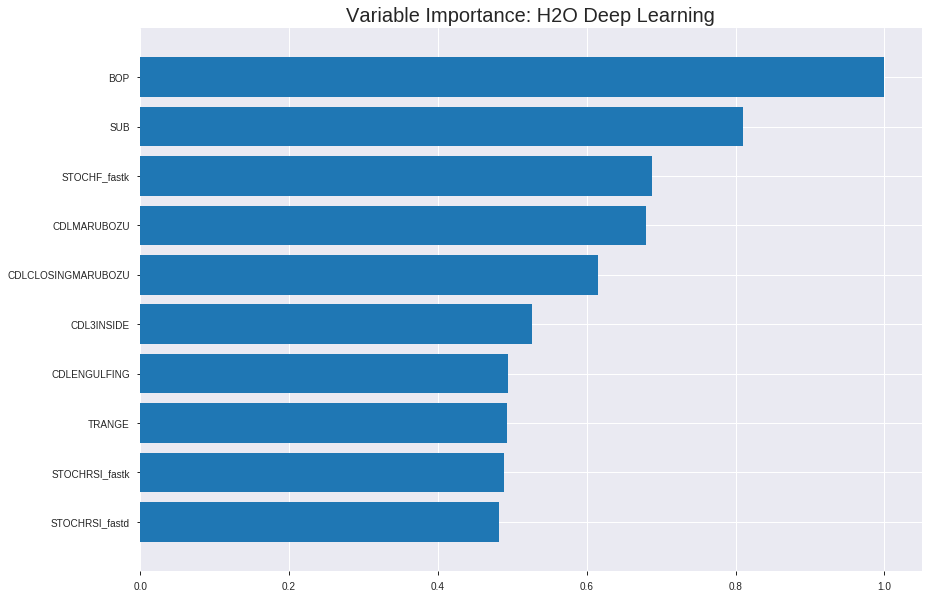

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_152851_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2006746738749874
RMSE: 0.44796726875407694
LogLoss: 0.5822929100844053
Mean Per-Class Error: 0.3025108997225525
AUC: 0.7553084951776985
pr_auc: 0.7314649795713865
Gini: 0.510616990355397
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.408365590030442: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      326  515   0.6124   (515.0/841.0)
1      57   843   0.0633   (57.0/900.0)
Total  383  1358  0.3285   (572.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408366     0.746678  266
max f2                       0.127082     0.865571  350
max f0point5                 0.621671     0.701807  178
max accuracy                 0.621671     0.700172  178
max precision                0.980947     1         0
max recall                   0.0342148    1         386
max specificity              0.980947     1         0
max absolute_mcc             0.562272     0.403044  208
max min_per_class_accuracy   0.648615     0.678889  159
max mean_per_class_accuracy  0.621671     0.697489  178

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 57.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.961125           1.71951   1.71951            0.888889         0.970131   0.888889                    0.970131            0.0177778       0.0177778                  71.9506   71.9506
    2        0.0201034                   0.937502           1.70686   1.71337            0.882353         0.950701   0.885714                    0.960693            0.0166667       0.0344444                  70.6863   71.3365
    3        0.0304423                   0.905324           1.61204   1.67895            0.833333         0.9203     0.867925                    0.946975            0.0166667       0.0511111                  61.2037   67.8952
    4        0.0402068                   0.879021           1.59307   1.6581             0.823529         0.892719   0.857143                    0.933798            0.0155556       0.0666667                  59.3072   65.8095
    5        0.0505457                   0.863199           1.61204   1.64867            0.833333         0.870936   0.852273                    0.92094             0.0166667       0.0833333                  61.2037   64.8674
    6        0.100517                    0.803879           1.44527   1.54756            0.747126         0.82878    0.8                         0.875124            0.0722222       0.155556                   44.5275   54.7556
    7        0.150488                    0.770185           1.46751   1.52098            0.758621         0.784473   0.78626                     0.845022            0.0733333       0.228889                   46.751    52.0975
    8        0.20046                     0.746997           1.35633   1.47993            0.701149         0.758943   0.765043                    0.823564            0.0677778       0.296667                   35.6335   47.9933
    9        0.300402                    0.709213           1.35633   1.43881            0.701149         0.727742   0.743786                    0.791684            0.135556        0.432222                   35.6335   43.8812
    10       0.400345                    0.680817           1.31186   1.40712            0.678161         0.695011   0.727403                    0.767551            0.131111        0.563333                   31.1865   40.7121
    11       0.500287                    0.650082           1.08951   1.34367            0.563218         0.665796   0.694604                    0.747223            0.108889        0.672222                   8.95147   34.3673
    12       0.60023                     0.614764           1.16734   1.31431            0.603448         0.634392   0.679426                    0.728436            0.116667        0.788889                   16.7337   31.4312
    13       0.700172                    0.52535            0.856047  1.2489             0.442529         0.573916   0.645611                    0.70638             0.0855556       0.874444                   -14.3953  24.8899
    14       0.800115                    0.359228           0.75599   1.18733            0.390805         0.455642   0.613783                    0.67506             0.0755556       0.95                       -24.401   18.733
    15       0.900057                    0.130729           0.433582  1.10363            0.224138         0.241645   0.570517                    0.626934            0.0433333       0.993333                   -56.6418  10.3633
    16       1                           0.00334404         0.066705  1                  0.0344828        0.0585808  0.516944                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.203777589084366
RMSE: 0.4514173114584397
LogLoss: 0.5984294119159449
Mean Per-Class Error: 0.2740203755428904
AUC: 0.7604743529715678
pr_auc: 0.7235525741245297
Gini: 0.5209487059431357
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5983382140278932: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      155  86   0.3568   (86.0/241.0)
1      53   204  0.2062   (53.0/257.0)
Total  208  290  0.2791   (139.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.598338     0.745887  216
max f2                       0.162245     0.859959  352
max f0point5                 0.633371     0.732075  196
max accuracy                 0.633371     0.726908  196
max precision                0.961777     1         0
max recall                   0.0143411    1         398
max specificity              0.961777     1         0
max absolute_mcc             0.633371     0.452911  196
max min_per_class_accuracy   0.645276     0.715953  185
max mean_per_class_accuracy  0.633371     0.72598   196

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 56.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.946902           1.55019   1.55019            0.8              0.956522   0.8                         0.956522            0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.919092           1.55019   1.55019            0.8              0.930996   0.8                         0.943759            0.0155642       0.0311284                  55.0195   55.0195
    3        0.0301205                   0.888729           1.16265   1.42101            0.6              0.909023   0.733333                    0.932181            0.0116732       0.0428016                  16.2646   42.1012
    4        0.0401606                   0.861076           1.55019   1.45331            0.8              0.873448   0.75                        0.917497            0.0155642       0.0583658                  55.0195   45.3307
    5        0.0502008                   0.847072           1.55019   1.47268            0.8              0.854138   0.76                        0.904825            0.0155642       0.07393                    55.0195   47.2685
    6        0.100402                    0.795509           1.55019   1.51144            0.8              0.821573   0.78                        0.863199            0.077821        0.151751                   55.0195   51.144
    7        0.150602                    0.770741           1.31767   1.44685            0.68             0.783122   0.746667                    0.836507            0.0661479       0.217899                   31.7665   44.6848
    8        0.200803                    0.752315           1.47268   1.45331            0.76             0.763297   0.75                        0.818204            0.07393         0.291829                   47.2685   45.3307
    9        0.301205                    0.714814           1.55019   1.4856             0.8              0.731461   0.766667                    0.78929             0.155642        0.447471                   55.0195   48.5603
    10       0.399598                    0.679526           1.30501   1.44114            0.673469         0.696715   0.743719                    0.766495            0.128405        0.575875                   30.5011   44.1136
    11       0.5                         0.646792           1.31767   1.41634            0.68             0.661042   0.730924                    0.74532             0.132296        0.708171                   31.7665   41.6342
    12       0.600402                    0.589136           0.891362  1.32855            0.46             0.621024   0.685619                    0.724534            0.0894942       0.797665                   -10.8638  32.8553
    13       0.698795                    0.492484           0.632732  1.23058            0.326531         0.545332   0.635057                    0.699302            0.0622568       0.859922                   -36.7268  23.0578
    14       0.799197                    0.354347           0.697588  1.16362            0.36             0.443805   0.600503                    0.667204            0.0700389       0.929961                   -30.2412  16.362
    15       0.899598                    0.123646           0.542568  1.09431            0.28             0.244923   0.564732                    0.620075            0.0544747       0.984436                   -45.7432  9.43059
    16       1                           0.00635628         0.155019  1                  0.08             0.0642765  0.516064                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:34:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:35:00  1 min 35.976 sec  685 obs/sec       0.54394   1             947        0.488081         0.68378             0.046013       0.700891        0.674931           1.18216          0.352096                         0.477619           0.66101               0.0865768        0.740995          0.710967             1.55019            0.309237
    2019-08-28 15:35:09  1 min 45.130 sec  1110 obs/sec      6.15164   11            10710      0.457074         0.605399            0.163372       0.736978        0.713066           1.71951          0.345778                         0.456345           0.60518               0.166135         0.75781           0.725544             1.55019            0.307229
    2019-08-28 15:35:18  1 min 54.109 sec  1262 obs/sec      12.8466   23            22366      0.455334         0.60125             0.169731       0.739505        0.718421           1.71951          0.331419                         0.45375            0.60034               0.175593         0.760733          0.722104             1.55019            0.277108
    2019-08-28 15:35:27  2 min  3.108 sec  1359 obs/sec      20.1637   36            35105      0.455651         0.614987            0.168573       0.744706        0.72259            1.71951          0.316485                         0.447895           0.610195              0.19673          0.766828          0.734149             1.55019            0.2751
    2019-08-28 15:35:36  2 min 12.208 sec  1437 obs/sec      28.0839   50            48894      0.453356         0.595677            0.176927       0.743939        0.721104           1.61204          0.326249                         0.457334           0.607221              0.162516         0.750254          0.717886             1.55019            0.335341
    2019-08-28 15:35:45  2 min 21.452 sec  1503 obs/sec      36.5646   65            63659      0.456083         0.601541            0.166998       0.749219        0.729529           1.71951          0.310741                         0.450041           0.598669              0.189014         0.768612          0.73087              1.93774            0.287149
    2019-08-28 15:35:54  2 min 30.518 sec  1548 obs/sec      44.9357   80            78233      0.447967         0.582293            0.196378       0.755308        0.731465           1.71951          0.328547                         0.451417           0.598429              0.184047         0.760474          0.723553             1.55019            0.279116

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.06835407510773094
SUB                 0.8099426031112671     0.8099426031112671   0.055362877526018664
STOCHF_fastk        0.6874344348907471     0.6874344348907471   0.0469889449941627
CDLMARUBOZU         0.6797134280204773     0.6797134280204773   0.04646118271064498
CDLCLOSINGMARUBOZU  0.615695059299469      0.615695059299469    0.04208526632681476
---                 ---                    ---                  ---
WILLR_24            0.34455329179763794    0.34455329179763794  0.02355162158615168
RSI_14              0.3343198597431183     0.3343198597431183   0.022852124802887182
CCI_12              0.31803229451179504    0.31803229451179504  0.021738803345743244
CMO_12              0.30781489610671997    0.30781489610671997  0.021040402527757133
RSI_12              0.30318474769592285    0.30318474769592285  0.020723913015525567


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6987951807228916)

('F1', 0.6905537459283388)

('auc', 0.7533704952035261)

('logloss', 0.6223803039378801)

('mean_per_class_error', 0.30674747212859743)

('rmse', 0.4667841518856018)

('mse', 0.21788744445156055)

deeplearning prediction progress: |███████████████████████████████████████| 100%


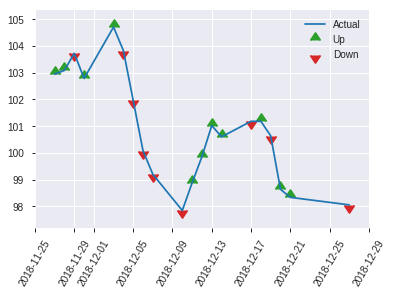


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21788744445156055
RMSE: 0.4667841518856018
LogLoss: 0.6223803039378801
Mean Per-Class Error: 0.30674747212859743
AUC: 0.7533704952035261
pr_auc: 0.7304557242151211
Gini: 0.5067409904070521
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4007550553880961: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   85   0.6391   (85.0/133.0)
1      10   106  0.0862   (10.0/116.0)
Total  58   191  0.3815   (95.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400755     0.690554  190
max f2                       0.107331     0.829726  228
max f0point5                 0.731239     0.696203  49
max accuracy                 0.666458     0.698795  100
max precision                0.972057     1         0
max recall                   0.0302043    1         244
max specificity              0.972057     1         0
max absolute_mcc             0.731239     0.416147  49
max min_per_class_accuracy   0.651019     0.661654  121
max mean_per_class_accuracy  0.666458     0.693253  100

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 55.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.93419            2.14655   2.14655            1                0.95911    1                           0.95911             0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.875363           1.07328   1.71724            0.5              0.904034   0.8                         0.93708             0.00862069      0.0344828                  7.32759   71.7241
    3        0.0321285                   0.833177           2.14655   1.87823            1                0.860928   0.875                       0.908523            0.0258621       0.0603448                  114.655   87.8233
    4        0.0401606                   0.813468           2.14655   1.9319             1                0.826768   0.9                         0.892172            0.0172414       0.0775862                  114.655   93.1897
    5        0.0522088                   0.798377           2.14655   1.98143            1                0.806103   0.923077                    0.87231             0.0258621       0.103448                   114.655   98.1432
    6        0.100402                    0.765934           1.96767   1.97483            0.916667         0.781234   0.92                        0.828593            0.0948276       0.198276                   96.7672   97.4828
    7        0.15261                     0.743554           1.65119   1.86411            0.769231         0.75244    0.868421                    0.802541            0.0862069       0.284483                   65.1194   86.4111
    8        0.200803                    0.731074           1.96767   1.88897            0.916667         0.738067   0.88                        0.787067            0.0948276       0.37931                    96.7672   88.8966
    9        0.301205                    0.694265           1.11621   1.63138            0.52             0.713819   0.76                        0.762651            0.112069        0.491379                   11.6207   63.1379
    10       0.401606                    0.668225           1.11621   1.50259            0.52             0.682662   0.7                         0.742654            0.112069        0.603448                   11.6207   50.2586
    11       0.502008                    0.649243           0.601034  1.32228            0.28             0.657676   0.616                       0.725658            0.0603448       0.663793                   -39.8966  32.2276
    12       0.598394                    0.598115           1.16272   1.29657            0.541667         0.624068   0.604027                    0.709295            0.112069        0.775862                   16.2716   29.6575
    13       0.698795                    0.494748           0.686897  1.20898            0.32             0.549753   0.563218                    0.686372            0.0689655       0.844828                   -31.3103  20.8977
    14       0.799197                    0.326676           0.772759  1.15418            0.36             0.41844    0.537688                    0.652712            0.0775862       0.922414                   -22.7241  15.4176
    15       0.899598                    0.133              0.515172  1.08286            0.24             0.254425   0.504464                    0.608261            0.0517241       0.974138                   -48.4828  8.28587
    16       1                           0.00897322         0.257586  1                  0.12             0.0661535  0.465863                   

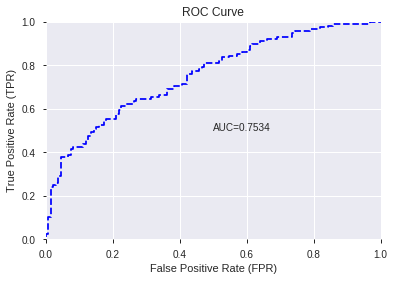

This function is available for GLM models only


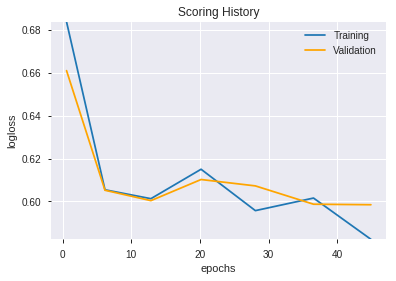

--2019-08-28 15:37:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


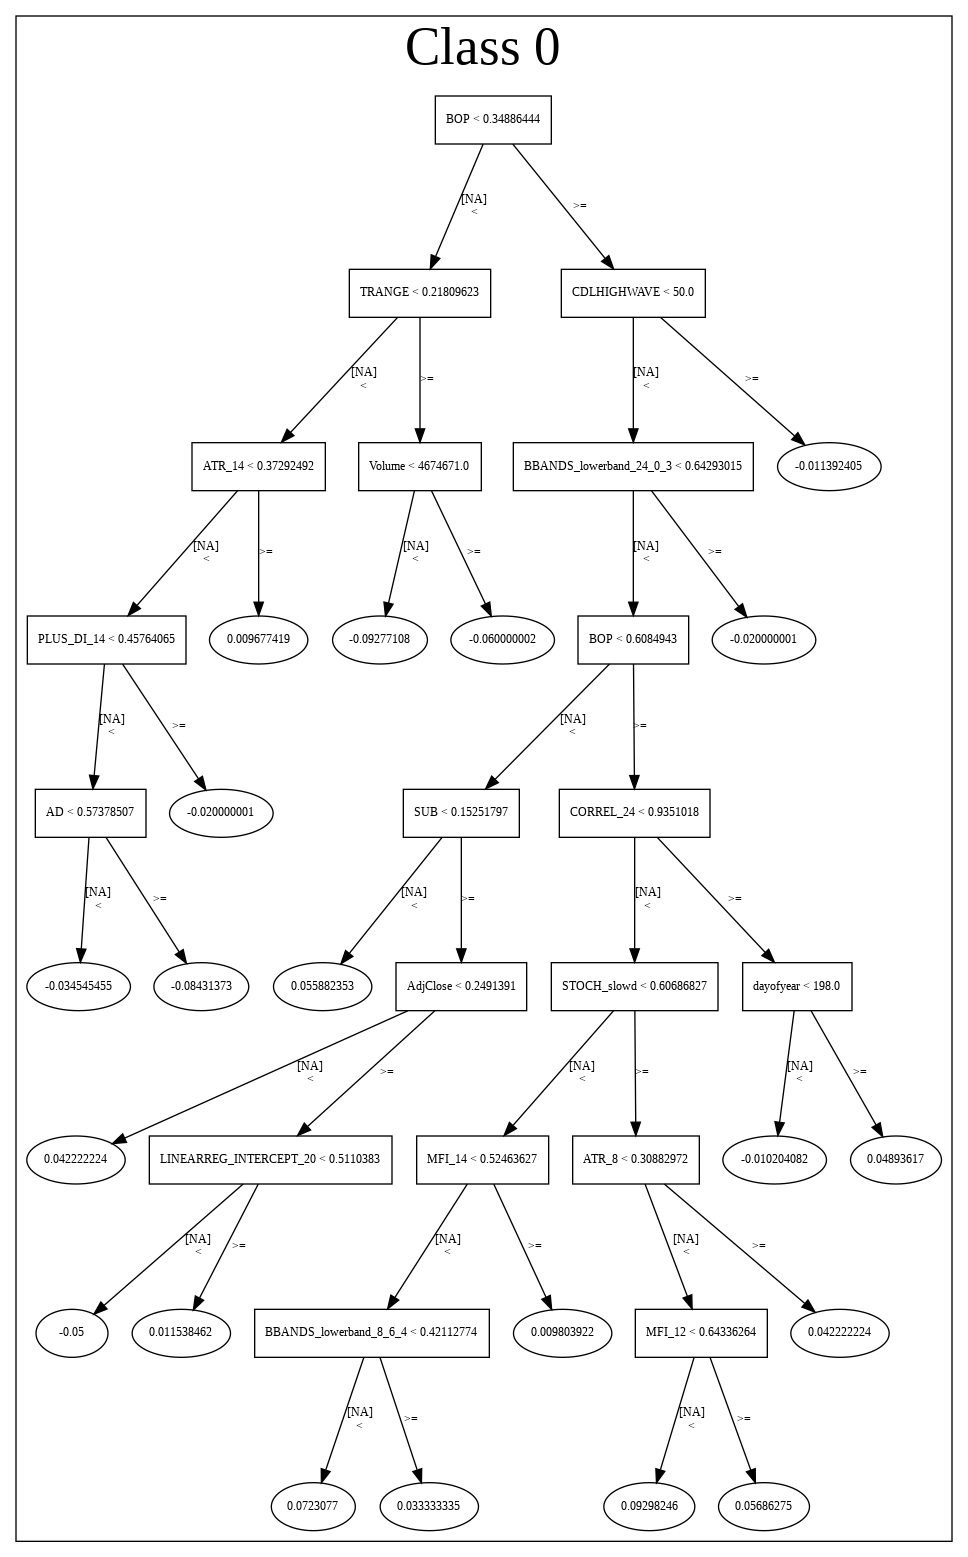

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_152851_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_152851_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'CDLCLOSINGMARUBOZU',
 'CDL3INSIDE',
 'CDLENGULFING',
 'TRANGE',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'DIV',
 'ULTOSC',
 'STOCH_slowk',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CCI_8',
 'WILLR_8',
 'ADOSC',
 'WILLR_30',
 'STOCHF_fastd',
 'WILLR_20',
 'CCI_14',
 'WILLR_14',
 'RSI_8',
 'WILLR_12',
 'CMO_14',
 'CMO_8',
 'WILLR_24',
 'RSI_14',
 'CCI_12',
 'CMO_12',
 'RSI_12']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_153713_model_1  0.749935  0.587896              0.305905  0.449534  0.20208

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.543058           1.000000    0.148366
1         STOCHF_fastk             0.441650           0.813265    0.120661
2                  SUB             0.413906           0.762176    0.113081
3               ULTOSC             0.224976           0.414277    0.061465
4                CCI_8             0.203731           0.375155    0.055660
5             WILLR_30             0.142356           0.262139    0.038893
6           CDL3INSIDE             0.130732           0.240734    0.035717
7             WILLR_12             0.095985           0.176750    0.026224
8               CMO_14             0.093993           0.173080    0.025679
9               RSI_14             0.093831           0.172783    0.025635
10             WILLR_8             0.091562           0.168605    0.025015
11         CDLMARUBOZU             0.087472           0.161074    0.023898
12              CCI_14             0.083587           0.153920    0.022837
13        CDLENGULFING             0.078700           0.144920    0.021501
14  CDLCLOSINGMARUBOZU             0.077706           0.143089    0.021230
15              RSI_12             0.076103           0.140138    0.020792
16              CMO_12             0.075585           0.139183    0.020650
17              TRANGE             0.074133           0.136510    0.020253
18         STOCH_slowk             0.072878           0.134199    0.019911
19        STOCHF_fastd             0.071378           0.131438    0.019501
20                 DIV             0.069938           0.128785    0.019107
21            WILLR_14             0.061136           0.112577    0.016703
22               RSI_8             0.059453           0.109479    0.016243
23               CMO_8             0.059251           0.109106    0.016188
24      STOCHRSI_fastd             0.048507           0.089322    0.013252
25      STOCHRSI_fastk             0.046460           0.085552    0.012693
26         CDLBELTHOLD             0.039144           0.072080    0.010694
27            WILLR_20             0.033134           0.061014    0.009052
28               ADOSC             0.032895           0.060573    0.008987
29         CDLLONGLINE             0.018976           0.034942    0.005184
30            WILLR_24             0.016357           0.030120    0.004469
31              CCI_12             0.001681           0.003095    0.000459

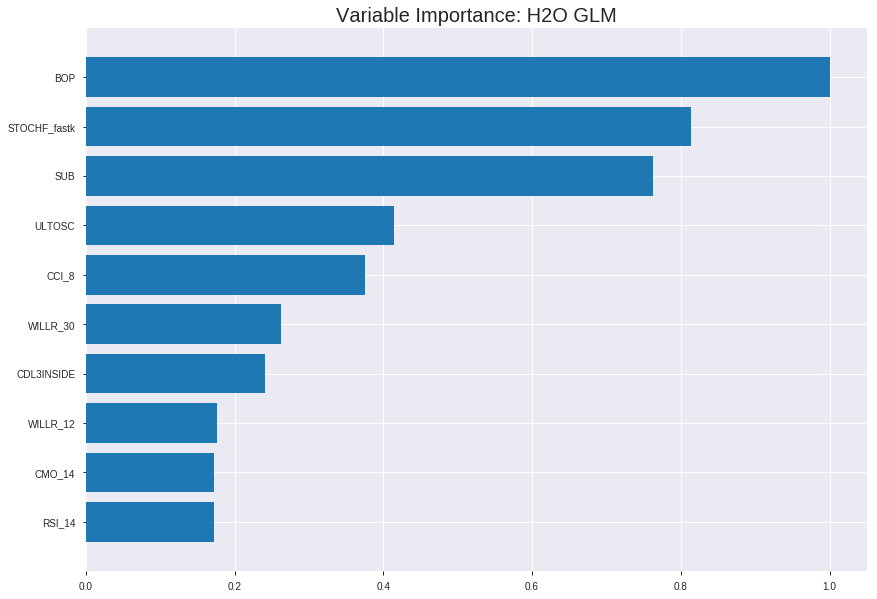

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_153713_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20261893238633957
RMSE: 0.4501321276984565
LogLoss: 0.5900363141847589
Null degrees of freedom: 1740
Residual degrees of freedom: 1708
Null deviance: 2411.5386742145693
Residual deviance: 2054.5064459913306
AIC: 2120.5064459913306
AUC: 0.7457041881358172
pr_auc: 0.7229266522194338
Gini: 0.49140837627163436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3941286874544135: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      382  459   0.5458   (459.0/841.0)
1      95   805   0.1056   (95.0/900.0)
Total  477  1264  0.3182   (554.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394129     0.743993  257
max f2                       0.248287     0.857422  323
max f0point5                 0.557732     0.702168  171
max accuracy                 0.492422     0.690408  206
max precision                0.950445     1         0
max recall                   0.104475     1         378
max specificity              0.950445     1         0
max absolute_mcc             0.404336     0.39167   252
max min_per_class_accuracy   0.543591     0.68      179
max mean_per_class_accuracy  0.557732     0.688424  171

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.889414           1.82698   1.82698            0.944444         0.911365  0.944444                    0.911365            0.0188889       0.0188889                  82.6975   82.6975
    2        0.0201034                   0.864807           1.70686   1.76863            0.882353         0.877666  0.914286                    0.894997            0.0166667       0.0355556                  70.6863   76.8635
    3        0.0304423                   0.848765           1.50457   1.67895            0.777778         0.856391  0.867925                    0.881885            0.0155556       0.0511111                  50.4568   67.8952
    4        0.0402068                   0.834878           1.36549   1.60283            0.705882         0.84066   0.828571                    0.871873            0.0133333       0.0644444                  36.549    60.2825
    5        0.0505457                   0.811535           1.61204   1.60471            0.833333         0.820384  0.829545                    0.861342            0.0166667       0.0811111                  61.2037   60.471
    6        0.100517                    0.767331           1.44527   1.52545            0.747126         0.790846  0.788571                    0.826295            0.0722222       0.153333                   44.5275   52.5448
    7        0.150488                    0.727442           1.3341    1.46191            0.689655         0.746325  0.755725                    0.79974             0.0666667       0.22                       33.41     46.1908
    8        0.20046                     0.698726           1.44527   1.45776            0.747126         0.713435  0.753582                    0.778226            0.0722222       0.292222                   44.5275   45.7762
    9        0.300402                    0.646386           1.37857   1.43141            0.712644         0.671323  0.739962                    0.74266             0.137778        0.43                       37.857    43.1415
    10       0.400345                    0.596021           1.27851   1.39324            0.66092          0.62199   0.72023                     0.712536            0.127778        0.557778                   27.8512   39.3244
    11       0.500287                    0.54663            1.20069   1.35478            0.62069          0.571642  0.700344                    0.684389            0.12            0.677778                   20.069    35.4777
    12       0.60023                     0.483617           0.989457  1.29395            0.511494         0.513419  0.6689                      0.655921            0.0988889       0.776667                   -1.05428  29.3949
    13       0.700172                    0.409319           0.93387   1.24255            0.482759         0.447796  0.64233                     0.626214            0.0933333       0.87                       -6.61303  24.2551
    14       0.800115                    0.325942           0.722637  1.17761            0.373563         0.371114  0.608758                    0.594349            0.0722222       0.942222                   -27.7363  17.7609
    15       0.900057                    0.212333           0.411347  1.09252            0.212644         0.271555  0.564773                    0.558506            0.0411111       0.983333                   -58.8653  9.25229
    16       1                           0.0118907          0.166762  1                  0.0862069        0.142651  0.516944                    0.516944          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19787510755096163
RMSE: 0.4448315496353217
LogLoss: 0.5817842012700575
Null degrees of freedom: 497
Residual degrees of freedom: 465
Null deviance: 689.8619915534578
Residual deviance: 579.4570644649775
AIC: 645.4570644649775
AUC: 0.7684744175533204
pr_auc: 0.7374891868288233
Gini: 0.5369488351066407
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2886308505781622: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      80   161  0.668    (161.0/241.0)
1      11   246  0.0428   (11.0/257.0)
Total  91   407  0.3454   (172.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288631     0.740964  317
max f2                       0.26163      0.859807  330
max f0point5                 0.60698      0.730159  136
max accuracy                 0.503022     0.712851  194
max precision                0.911663     1         0
max recall                   0.0833884    1         396
max specificity              0.911663     1         0
max absolute_mcc             0.503022     0.425797  194
max min_per_class_accuracy   0.503022     0.708171  194
max mean_per_class_accuracy  0.503022     0.713007  194

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 49.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.86388            1.16265   1.16265            0.6              0.884993  0.6                         0.884993            0.0116732       0.0116732                  16.2646   16.2646
    2        0.0200803                   0.823473           1.55019   1.35642            0.8              0.84224   0.7                         0.863616            0.0155642       0.0272374                  55.0195   35.642
    3        0.0301205                   0.81044            1.93774   1.55019            1                0.818632  0.8                         0.848621            0.0194553       0.0466926                  93.7743   55.0195
    4        0.0401606                   0.792867           1.55019   1.55019            0.8              0.801678  0.8                         0.836885            0.0155642       0.0622568                  55.0195   55.0195
    5        0.0502008                   0.783478           1.55019   1.55019            0.8              0.787629  0.8                         0.827034            0.0155642       0.077821                   55.0195   55.0195
    6        0.100402                    0.746776           1.47268   1.51144            0.76             0.761649  0.78                        0.794342            0.07393         0.151751                   47.2685   51.144
    7        0.150602                    0.709802           1.70521   1.57603            0.88             0.730271  0.813333                    0.772985            0.0856031       0.237354                   70.5214   57.6031
    8        0.200803                    0.682669           1.47268   1.55019            0.76             0.695384  0.8                         0.753585            0.07393         0.311284                   47.2685   55.0195
    9        0.301205                    0.630709           1.55019   1.55019            0.8              0.656241  0.8                         0.721137            0.155642        0.466926                   55.0195   55.0195
    10       0.399598                    0.57546            1.18637   1.46061            0.612245         0.60472   0.753769                    0.692471            0.116732        0.583658                   18.6373   46.061
    11       0.5                         0.503505           1.2014    1.40856            0.62             0.540191  0.726908                    0.661893            0.120623        0.70428                    20.1401   40.856
    12       0.600402                    0.453596           0.852607  1.31559            0.44             0.474938  0.67893                     0.63063             0.0856031       0.789883                   -14.7393  31.5592
    13       0.698795                    0.391012           0.75137   1.23615            0.387755         0.420735  0.637931                    0.601075            0.07393         0.863813                   -24.863   23.6147
    14       0.799197                    0.304876           0.697588  1.16849            0.36             0.347916  0.603015                    0.569271            0.0700389       0.933852                   -30.2412  16.8488
    15       0.899598                    0.198144           0.503813  1.09431            0.26             0.253011  0.564732                    0.533974            0.0505837       0.984436                   -49.6187  9.43059
    16       1                           0.0259342          0.155019  1                  0.08             0.142996  0.516064                    0.49472             0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 15:37:14  0.000 sec   2            .18E2     33            1.3658492345036248  1.368295126037003
     2019-08-28 15:37:14  0.007 sec   4            .11E2     33            1.35718104041075    1.3604837968547887
     2019-08-28 15:37:14  0.015 sec   6            .71E1     33            1.3460279096601977  1.350183879671897
     2019-08-28 15:37:14  0.023 sec   8            .44E1     33            1.3323704510601493  1.3371338251451497
     2019-08-28 15:37:14  0.030 sec   10           .28E1     33            1.3162614832882729  1.32104609250995
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 15:37:14  0.124 sec   34           .91E-2    33            1.176788611317011   1.1636061385673078
     2019-08-28 15:37:14  0.132 sec   36           .56E-2    33            1.1742719306328646  1.1649103158801148
     2019-08-28 15:37:14  0.140 sec   38           .35E-2    33            1.172480703886449   1.1668968463624771
     2019-08-28 15:37:14  0.148 sec   40           .22E-2    33            1.1713130930100437  1.1690893416293264
     2019-08-28 15:37:14  0.155 sec   42           .13E-2    33            1.170616541399404   1.1711263727012027


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6867469879518072)

('F1', 0.7045454545454546)

('auc', 0.7499351827845475)

('logloss', 0.5878963188046188)

('mean_per_class_error', 0.3059048483277158)

('rmse', 0.44953363833404264)

('mse', 0.20208049199384184)

glm prediction progress: |████████████████████████████████████████████████| 100%


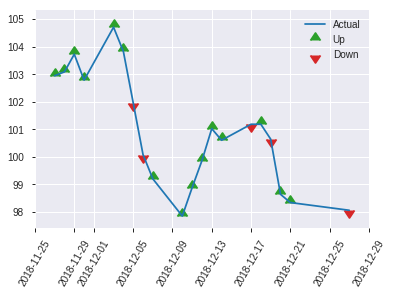


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20208049199384184
RMSE: 0.44953363833404264
LogLoss: 0.5878963188046188
Null degrees of freedom: 248
Residual degrees of freedom: 216
Null deviance: 346.62607336051315
Residual deviance: 292.77236676470017
AIC: 358.77236676470017
AUC: 0.7499351827845475
pr_auc: 0.7275801028025947
Gini: 0.49987036556909503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4383838500032065: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   55   0.4135   (55.0/133.0)
1      23   93   0.1983   (23.0/116.0)
Total  101  148  0.3133   (78.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438384     0.704545  147
max f2                       0.254751     0.835799  211
max f0point5                 0.601971     0.667476  73
max accuracy                 0.47387      0.686747  135
max precision                0.914267     1         0
max recall                   0.089925     1         245
max specificity              0.914267     1         0
max absolute_mcc             0.438384     0.394374  147
max min_per_class_accuracy   0.516162     0.672414  120
max mean_per_class_accuracy  0.438384     0.694095  147

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 47.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.840283           2.14655   2.14655            1                0.898926  1                           0.898926            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.788224           2.14655   2.14655            1                0.794967  1                           0.857343            0.0172414       0.0431034                  114.655   114.655
    3        0.0321285                   0.773492           1.43103   1.87823            0.666667         0.782596  0.875                       0.829313            0.0172414       0.0603448                  43.1034   87.8233
    4        0.0401606                   0.770494           2.14655   1.9319             1                0.77112   0.9                         0.817674            0.0172414       0.0775862                  114.655   93.1897
    5        0.0522088                   0.765983           2.14655   1.98143            1                0.768558  0.923077                    0.80634             0.0258621       0.103448                   114.655   98.1432
    6        0.100402                    0.726552           2.14655   2.06069            1                0.749729  0.96                        0.779167            0.103448        0.206897                   114.655   106.069
    7        0.15261                     0.670576           1.65119   1.9206             0.769231         0.699011  0.894737                    0.751745            0.0862069       0.293103                   65.1194   92.0599
    8        0.200803                    0.638933           1.25216   1.76017            0.583333         0.651469  0.82                        0.727679            0.0603448       0.353448                   25.2155   76.0172
    9        0.301205                    0.59914            1.20207   1.57414            0.56             0.61699   0.733333                    0.690782            0.12069         0.474138                   20.2069   57.4138
    10       0.401606                    0.562633           0.772759  1.37379            0.36             0.580669  0.64                        0.663254            0.0775862       0.551724                   -22.7241  37.3793
    11       0.502008                    0.504138           1.28793   1.35662            0.6              0.538135  0.632                       0.63823             0.12931         0.681034                   28.7931   35.6621
    12       0.598394                    0.437311           1.25216   1.33979            0.583333         0.467274  0.624161                    0.610694            0.12069         0.801724                   25.2155   33.9794
    13       0.698795                    0.37877            0.772759  1.25832            0.36             0.404937  0.586207                    0.581131            0.0775862       0.87931                    -22.7241  25.8323
    14       0.799197                    0.283015           0.42931   1.15418            0.2              0.334162  0.537688                    0.550105            0.0431034       0.922414                   -57.069   15.4176
    15       0.899598                    0.216714           0.515172  1.08286            0.24             0.250953  0.504464                    0.516717            0.0517241       0.974138                   -48.4828  8.28587
    16       1                           0.0331949          0.257586  1                  0.12             0.14458   0.465863                    0.479354         

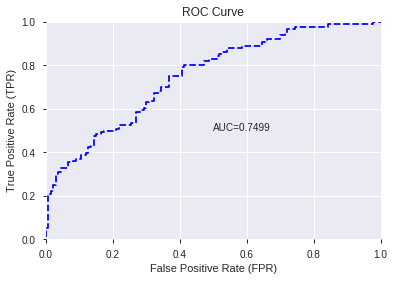

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


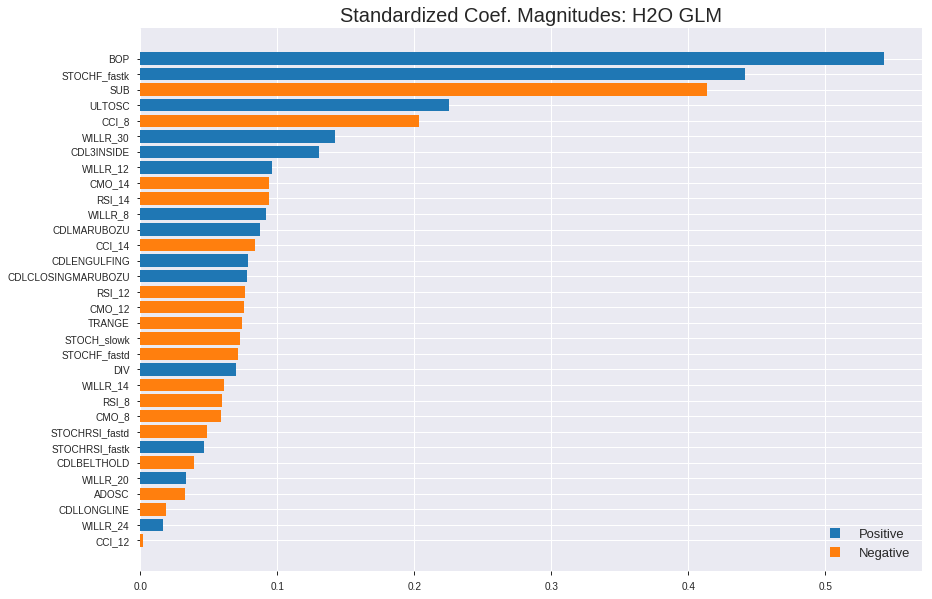

'log_likelihood'
--2019-08-28 15:37:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


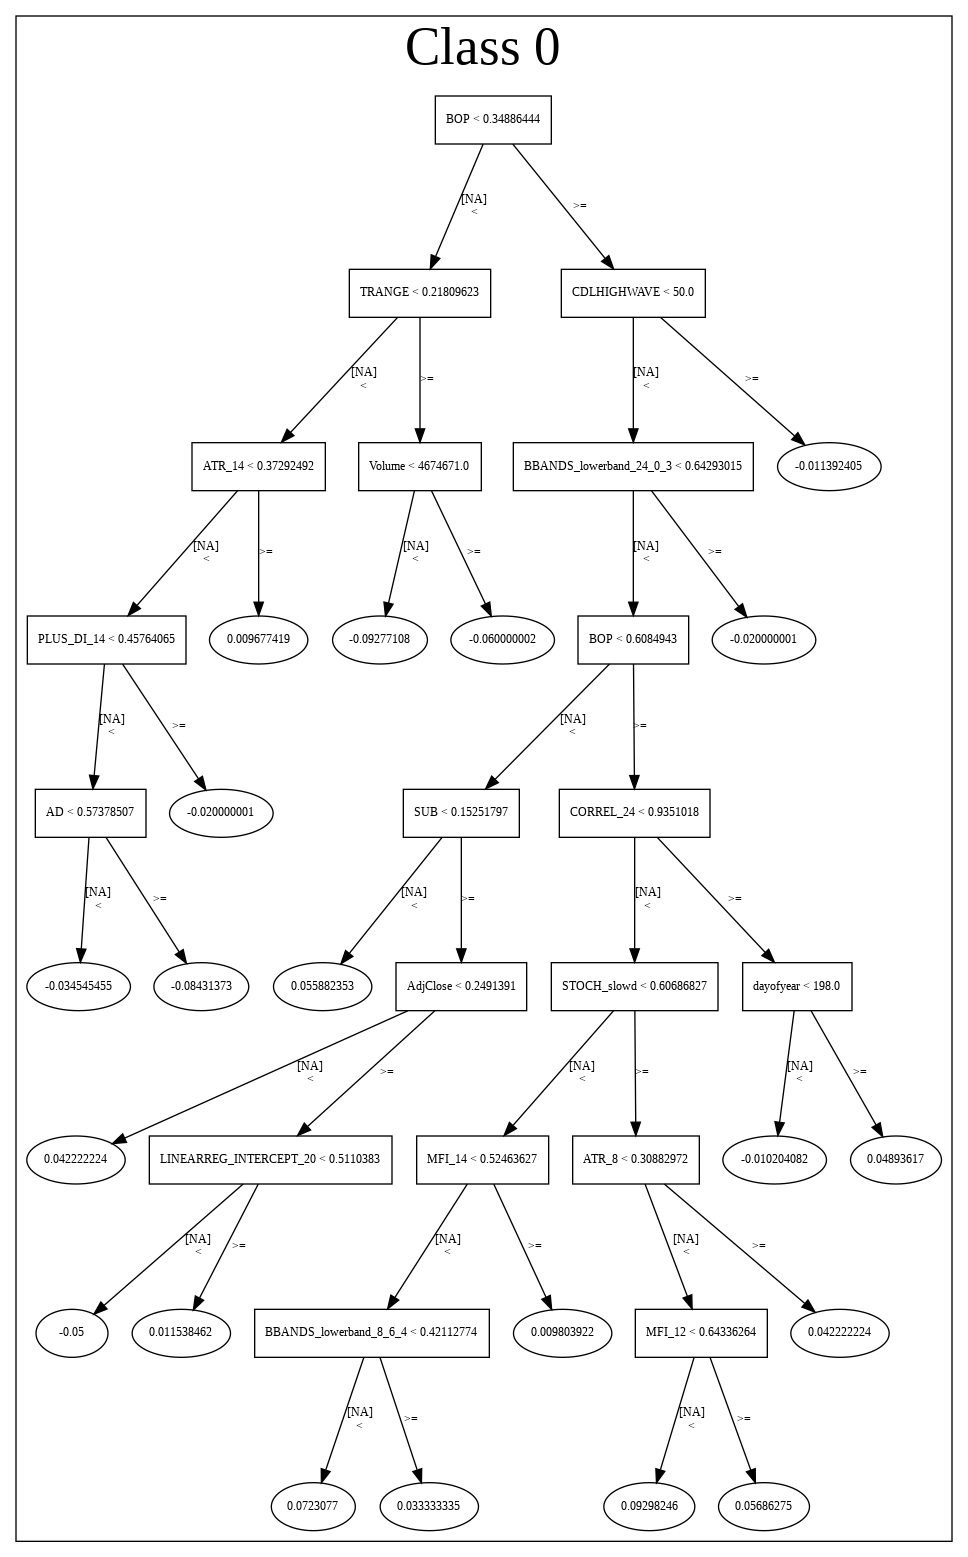

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_153713_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_153713_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'SUB',
 'ULTOSC',
 'CCI_8',
 'WILLR_30',
 'CDL3INSIDE',
 'WILLR_12',
 'CMO_14',
 'RSI_14',
 'WILLR_8',
 'CDLMARUBOZU',
 'CCI_14',
 'CDLENGULFING',
 'CDLCLOSINGMARUBOZU',
 'RSI_12',
 'CMO_12',
 'TRANGE',
 'STOCH_slowk',
 'STOCHF_fastd',
 'DIV',
 'WILLR_14',
 'RSI_8',
 'CMO_8',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'WILLR_20',
 'ADOSC',
 'CDLLONGLINE',
 'WILLR_24',
 'CCI_12']

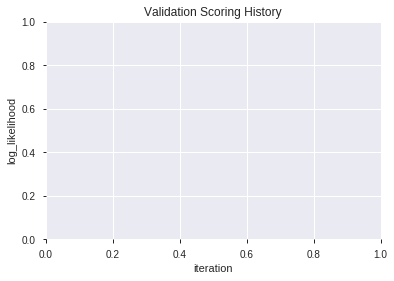

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_153730_model_4  0.739759  0.595868              0.291969  0.453122  0.205320
1  XGBoost_grid_1_AutoML_20190828_153730_model_3  0.738268  0.604404              0.282895  0.455995  0.207931
2  XGBoost_grid_1_AutoML_20190828_153730_model_6  0.738138  0.604114              0.289312  0.456011  0.207946
3  XGBoost_grid_1_AutoML_20190828_153730_model_2  0.735611  0.601976              0.290867  0.455480  0.207462
4               XGBoost_3_AutoML_20190828_153730  0.732435  0.608729              0.279135  0.458282  0.210022
5  XGBoost_grid_1_AutoML_20190828_153730_model_1  0.732013  0.612744              0.311220  0.459018  0.210698
6               XGBoost_2_AutoML_20190828_153730  0.731657  0.604817              0.310766  0.457167  0.209002
7               XGBoost_1_AutoML_20190828_153730  0.730814  0.609362              0.313877  0.458005  0.209769
8  XGBoost_grid_1_AutoML_20190828_153730_model_7  0.727184  0.610474              0.318739  0.459530  0.211168
9  XGBoost_grid_1_AutoML_20190828_153730_model_5  0.704887  0.647659              0.320391  0.472545  0.223299

variable  relative_importance  scaled_importance  percentage
0                  BOP          1878.832397           1.000000    0.395106
1         STOCHF_fastk           560.132385           0.298128    0.117792
2                  SUB           488.044098           0.259759    0.102633
3               TRANGE           295.125824           0.157079    0.062063
4                CCI_8           271.256042           0.144375    0.057043
5          STOCH_slowk           157.144623           0.083640    0.033046
6                ADOSC           128.195343           0.068231    0.026959
7               CCI_14           104.333664           0.055531    0.021941
8                  DIV            88.537888           0.047124    0.018619
9                CMO_8            84.806625           0.045138    0.017834
10              ULTOSC            82.379311           0.043846    0.017324
11      STOCHRSI_fastd            77.246857           0.041114    0.016245
12            WILLR_30            72.404945           0.038537    0.015226
13              CCI_12            63.696922           0.033902    0.013395
14      STOCHRSI_fastk            58.435184           0.031102    0.012289
15              CMO_14            58.048309           0.030896    0.012207
16              CMO_12            50.432484           0.026842    0.010606
17            WILLR_12            50.052078           0.026640    0.010526
18            WILLR_20            48.147854           0.025626    0.010125
19             WILLR_8            44.286366           0.023571    0.009313
20            WILLR_24            39.690487           0.021125    0.008347
21            WILLR_14            29.377892           0.015636    0.006178
22  CDLCLOSINGMARUBOZU            24.651009           0.013120    0.005184

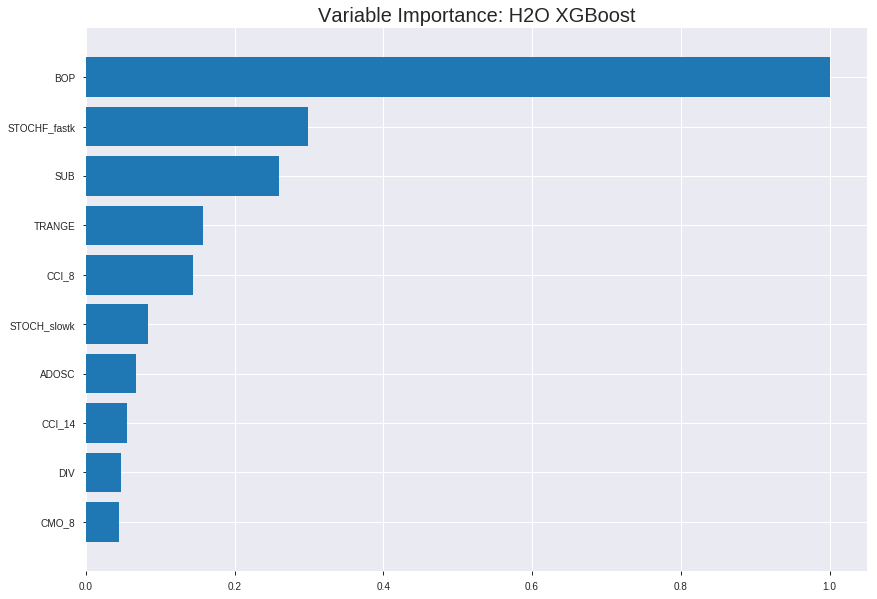

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_153730_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18169914371482715
RMSE: 0.4262618253079053
LogLoss: 0.5431289478054344
Mean Per-Class Error: 0.2610410886510768
AUC: 0.8092462676707624
pr_auc: 0.800104619883669
Gini: 0.6184925353415247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4102129340171814: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      436  405   0.4816   (405.0/841.0)
1      94   806   0.1044   (94.0/900.0)
Total  530  1211  0.2866   (499.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410213     0.763619  254
max f2                       0.229321     0.864573  334
max f0point5                 0.618087     0.763674  143
max accuracy                 0.586576     0.737507  160
max precision                0.862194     1         0
max recall                   0.0997829    1         390
max specificity              0.862194     1         0
max absolute_mcc             0.617333     0.482209  144
max min_per_class_accuracy   0.565503     0.733333  172
max mean_per_class_accuracy  0.617333     0.738959  144

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.825811           1.93444   1.93444            1                0.83582   1                           0.83582             0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.814791           1.70686   1.8239             0.882353         0.8194    0.942857                    0.827845            0.0166667       0.0366667                  70.6863   82.3905
    3        0.0304423                   0.802954           1.71951   1.78845            0.888889         0.808045  0.924528                    0.82112             0.0177778       0.0544444                  71.9506   78.8449
    4        0.0402068                   0.793602           1.93444   1.8239             1                0.797252  0.942857                    0.815324            0.0188889       0.0733333                  93.4444   82.3905
    5        0.0505457                   0.786875           1.71951   1.80255            0.888889         0.789917  0.931818                    0.810127            0.0177778       0.0911111                  71.9506   80.2551
    6        0.100517                    0.758844           1.60092   1.70231            0.827586         0.771922  0.88                        0.791134            0.08            0.171111                   60.092    70.2311
    7        0.150488                    0.734097           1.55645   1.65388            0.804598         0.745977  0.854962                    0.776139            0.0777778       0.248889                   55.645    65.3876
    8        0.20046                     0.712524           1.55645   1.62959            0.804598         0.723535  0.842407                    0.763026            0.0777778       0.326667                   55.645    62.9589
    9        0.300402                    0.671772           1.54533   1.60156            0.798851         0.692923  0.827916                    0.739703            0.154444        0.481111                   54.5332   60.1557
    10       0.400345                    0.629118           1.4008    1.55144            0.724138         0.651499  0.802009                    0.717683            0.14            0.621111                   40.0805   55.1441
    11       0.500287                    0.568829           1.05616   1.4525             0.545977         0.602159  0.750861                    0.694605            0.105556        0.726667                   5.61622   45.2499
    12       0.60023                     0.490565           0.8894    1.35874            0.45977          0.532493  0.702392                    0.667612            0.0888889       0.815556                   -11.06    35.8739
    13       0.700172                    0.404947           0.811577  1.28064            0.41954          0.448974  0.662018                    0.636404            0.0811111       0.896667                   -18.8423  28.0637
    14       0.800115                    0.296892           0.522522  1.18594            0.270115         0.346278  0.613065                    0.600164            0.0522222       0.948889                   -47.7478  18.5941
    15       0.900057                    0.176173           0.389112  1.09746            0.201149         0.238983  0.567326                    0.560059            0.0388889       0.987778                   -61.0888  9.74608
    16       1                           0.0798585          0.122292  1                  0.0632184        0.123799  0.516944                    0.516458         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1951145462279569
RMSE: 0.4417177223385506
LogLoss: 0.5739642172409916
Mean Per-Class Error: 0.2851849459935095
AUC: 0.7724139044512973
pr_auc: 0.7647972612702321
Gini: 0.5448278089025946
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39089593291282654: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  124  0.5145   (124.0/241.0)
1      32   225  0.1245   (32.0/257.0)
Total  149  349  0.3133   (156.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390896     0.742574  274
max f2                       0.21713      0.859001  343
max f0point5                 0.575896     0.733624  169
max accuracy                 0.575896     0.712851  169
max precision                0.823072     1         0
max recall                   0.0901239    1         397
max specificity              0.823072     1         0
max absolute_mcc             0.575896     0.431955  169
max min_per_class_accuracy   0.534286     0.688797  195
max mean_per_class_accuracy  0.575896     0.714815  169

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.812145           1.93774   1.93774            1                0.819917  1                           0.819917            0.0194553       0.0194553                  93.7743   93.7743
    2        0.0200803                   0.797291           1.93774   1.93774            1                0.804571  1                           0.812244            0.0194553       0.0389105                  93.7743   93.7743
    3        0.0301205                   0.783328           1.55019   1.80856            0.8              0.790813  0.933333                    0.8051              0.0155642       0.0544747                  55.0195   80.856
    4        0.0401606                   0.77846            1.16265   1.64708            0.6              0.780815  0.85                        0.799029            0.0116732       0.0661479                  16.2646   64.7082
    5        0.0502008                   0.77009            1.93774   1.70521            1                0.775491  0.88                        0.794321            0.0194553       0.0856031                  93.7743   70.5214
    6        0.100402                    0.74977            1.6277    1.66646            0.84             0.760049  0.86                        0.777185            0.0817121       0.167315                   62.7704   66.6459
    7        0.150602                    0.719408           1.55019   1.6277             0.8              0.731822  0.84                        0.762064            0.077821        0.245136                   55.0195   62.7704
    8        0.200803                    0.702781           1.55019   1.60833            0.8              0.712463  0.83                        0.749664            0.077821        0.322957                   55.0195   60.8327
    9        0.301205                    0.653394           1.31767   1.51144            0.68             0.677101  0.78                        0.725476            0.132296        0.455253                   31.7665   51.144
    10       0.399598                    0.601352           1.3841    1.48009            0.714286         0.631922  0.763819                    0.70244             0.136187        0.59144                    38.4102   48.0085
    11       0.5                         0.539652           0.852607  1.35409            0.44             0.573104  0.698795                    0.676469            0.0856031       0.677043                   -14.7393  35.4086
    12       0.600402                    0.473889           1.2014    1.32855            0.62             0.507455  0.685619                    0.648206            0.120623        0.797665                   20.1401   32.8553
    13       0.698795                    0.391379           0.75137   1.24728            0.387755         0.439554  0.643678                    0.618827            0.07393         0.871595                   -24.863   24.7283
    14       0.799197                    0.275209           0.620078  1.16849            0.32             0.339585  0.603015                    0.583746            0.0622568       0.933852                   -37.9922  16.8488
    15       0.899598                    0.184346           0.426304  1.08566            0.22             0.232652  0.560268                    0.544561            0.0428016       0.976654                   -57.3696  8.56552
    16       1                           0.0839711          0.232529  1                  0.12             0.127732  0.516064                    0.502711           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:37:38  3.333 sec   0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-28 15:37:38  3.413 sec   5                  0.480337         0.654365            0.760015        0.740516           1.67066          0.299253                         0.482188           0.657973              0.755469          0.755245             1.93774            0.301205
    2019-08-28 15:37:38  3.463 sec   10                 0.46794          0.629992            0.765845        0.75193            1.82698          0.309018                         0.470813           0.635619              0.760361          0.771365             1.93774            0.313253
    2019-08-28 15:37:38  3.515 sec   15                 0.458672         0.611513            0.775018        0.762564           1.82698          0.325101                         0.461642           0.617384              0.772357          0.782799             1.93774            0.303213
    2019-08-28 15:37:38  3.569 sec   20                 0.451882         0.597734            0.781904        0.771497           1.82698          0.302125                         0.455576           0.605105              0.776305          0.782574             1.93774            0.297189
    2019-08-28 15:37:38  3.626 sec   25                 0.446908         0.587318            0.785835        0.776375           1.93444          0.295233                         0.452336           0.598116              0.771235          0.773478             1.93774            0.301205
    2019-08-28 15:37:38  3.684 sec   30                 0.443028         0.579081            0.789003        0.778565           1.93444          0.296381                         0.449325           0.591669              0.773802          0.777035             1.93774            0.323293
    2019-08-28 15:37:38  3.748 sec   35                 0.44007          0.57268             0.790137        0.778679           1.93444          0.292361                         0.446164           0.585045              0.776797          0.775092             1.93774            0.321285
    2019-08-28 15:37:38  3.991 sec   40                 0.43688          0.565941            0.794697        0.783162           1.82698          0.286617                         0.445199           0.582586              0.774852          0.768812             1.93774            0.319277
    2019-08-28 15:37:39  4.066 sec   45                 0.434697         0.561113            0.796884        0.785407           1.82698          0.292361                         0.443928           0.57974               0.774933          0.767198             1.93774            0.317269
    2019-08-28 15:37:39  4.145 sec   50                 0.432749         0.556898            0.799573        0.787674           1.82698          0.301551                         0.443359           0.578055              0.773544          0.768171             1.93774            0.305221
    2019-08-28 15:37:39  4.229 sec   55                 0.431043         0.553179            0.802085        0.791604           1.82698          0.287191                         0.44233            0.575654              0.774246          0

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  --------------------
BOP                 1878.8323974609375     1.0                   0.39510625198035093
STOCHF_fastk        560.1323852539062      0.2981279149810657    0.11779220309888559
SUB                 488.0440979003906      0.2597592518416947    0.10263250441239205
TRANGE              295.1258239746094      0.1570793777951901    0.06206304422406313
CCI_8               271.25604248046875     0.14437479513715293   0.05704338418707149
---                 ---                    ---                   ---
WILLR_20            48.14785385131836      0.025626476271319136  0.010125180991024304
WILLR_8             44.2863655090332       0.023571216660348202  0.009313135069286983
WILLR_24            39.690486907958984     0.021125081173603823  0.00834665164528328
WILLR_14            29.377891540527344     0.01563624918339111   0.006177979809880484
CDLCLOSINGMARUBOZU  24.65100860595703      0.01312038723585484   0.005183947025289443


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7028112449799196)

('F1', 0.7109375000000001)

('auc', 0.739758879958517)

('logloss', 0.5958681320050031)

('mean_per_class_error', 0.29196914700544463)

('rmse', 0.4531221006040406)

('mse', 0.2053196380558183)

xgboost prediction progress: |████████████████████████████████████████████| 100%


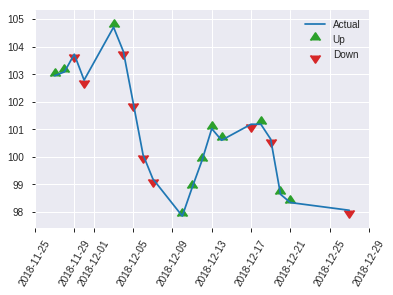


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2053196380558183
RMSE: 0.4531221006040406
LogLoss: 0.5958681320050031
Mean Per-Class Error: 0.29196914700544463
AUC: 0.739758879958517
pr_auc: 0.6825226012450776
Gini: 0.47951775991703394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46968814730644226: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   49   0.3684   (49.0/133.0)
1      25   91   0.2155   (25.0/116.0)
Total  109  140  0.2972   (74.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469688     0.710938  139
max f2                       0.266485     0.833333  195
max f0point5                 0.469688     0.673077  139
max accuracy                 0.469688     0.702811  139
max precision                0.847825     1         0
max recall                   0.100546     1         238
max specificity              0.847825     1         0
max absolute_mcc             0.469688     0.418346  139
max min_per_class_accuracy   0.524156     0.691729  121
max mean_per_class_accuracy  0.469688     0.708031  139

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 47.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.799001           2.14655   2.14655            1                0.823684  1                           0.823684            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.787512           1.07328   1.71724            0.5              0.791131  0.8                         0.810663            0.00862069      0.0344828                  7.32759   71.7241
    3        0.0321285                   0.773365           2.14655   1.87823            1                0.783715  0.875                       0.800557            0.0258621       0.0603448                  114.655   87.8233
    4        0.0401606                   0.764268           2.14655   1.9319             1                0.766057  0.9                         0.793657            0.0172414       0.0775862                  114.655   93.1897
    5        0.0522088                   0.750522           0.715517  1.65119            0.333333         0.759373  0.769231                    0.785745            0.00862069      0.0862069                  -28.4483  65.1194
    6        0.100402                    0.714071           1.60991   1.63138            0.75             0.733653  0.76                        0.760741            0.0775862       0.163793                   60.9914   63.1379
    7        0.15261                     0.689941           1.65119   1.63816            0.769231         0.703401  0.763158                    0.741125            0.0862069       0.25                       65.1194   63.8158
    8        0.200803                    0.652511           1.43103   1.58845            0.666667         0.671165  0.74                        0.724334            0.0689655       0.318966                   43.1034   58.8448
    9        0.301205                    0.622542           1.11621   1.43103            0.52             0.63657   0.666667                    0.69508             0.112069        0.431034                   11.6207   43.1034
    10       0.401606                    0.578821           1.45966   1.43819            0.68             0.599394  0.67                        0.671158            0.146552        0.577586                   45.9655   43.819
    11       0.502008                    0.51837            1.28793   1.40814            0.6              0.546454  0.656                       0.646217            0.12931         0.706897                   28.7931   40.8138
    12       0.598394                    0.451952           0.983836  1.33979            0.458333         0.477417  0.624161                    0.619028            0.0948276       0.801724                   -1.61638  33.9794
    13       0.698795                    0.359434           0.515172  1.22131            0.24             0.403005  0.568966                    0.58799             0.0517241       0.853448                   -48.4828  22.1314
    14       0.799197                    0.255086           0.944483  1.18654            0.44             0.302739  0.552764                    0.552155            0.0948276       0.948276                   -5.55172  18.6536
    15       0.899598                    0.139176           0.257586  1.08286            0.12             0.193539  0.504464                    0.512131            0.0258621       0.974138                   -74.2414  8.28587
    16       1                           0.0821045          0.257586  1                  0.12             0.106784  0.465863                    0.471433          

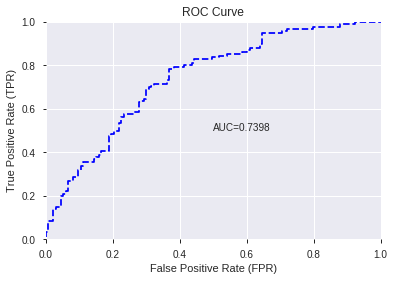

This function is available for GLM models only


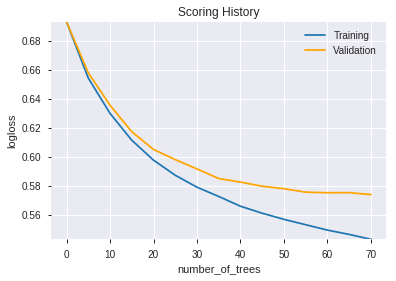

--2019-08-28 15:37:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

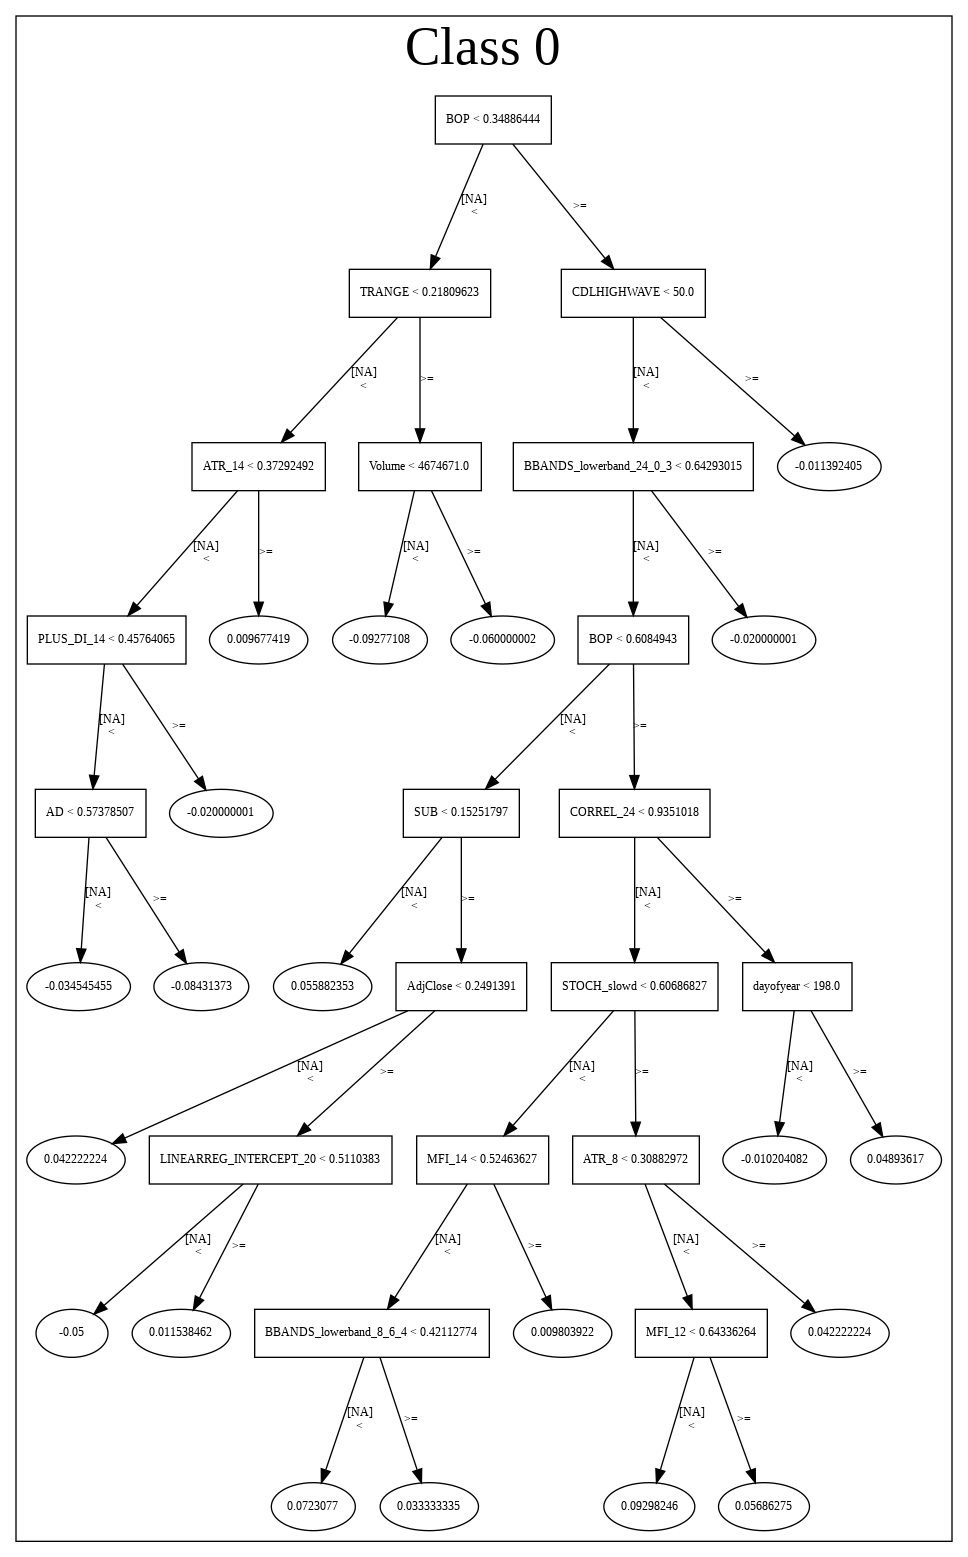

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_153730_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_153730_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'CCI_8',
 'STOCH_slowk',
 'ADOSC',
 'CCI_14',
 'DIV',
 'CMO_8',
 'ULTOSC',
 'STOCHRSI_fastd',
 'WILLR_30',
 'CCI_12',
 'STOCHRSI_fastk',
 'CMO_14',
 'CMO_12',
 'WILLR_12',
 'WILLR_20',
 'WILLR_8',
 'WILLR_24',
 'WILLR_14',
 'CDLCLOSINGMARUBOZU']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

57

['BBANDS_middleband_14_5_3',
 'MAVP_20_2',
 'BBANDS_lowerband_20_2_5',
 'BBANDS_upperband_20_6_5',
 'BBANDS_upperband_30_1_5',
 'BBANDS_lowerband_30_1_5',
 'BOP',
 'ADXR_8',
 'aroondown_8',
 'CCI_8',
 'DX_8',
 'MFI_8',
 'ROC_8',
 'ROCR100_8',
 'WILLR_8',
 'aroondown_12',
 'aroonup_12',
 'DX_12',
 'MACDFIX_hist_12',
 'MFI_12',
 'PLUS_DI_12',
 'ROCR100_12',
 'aroondown_14',
 'MFI_14',
 'MINUS_DM_14',
 'WILLR_14',
 'ADX_20',
 'MACDFIX_signal_20',
 'ROC_20',
 'AROONOSC_24',
 'MOM_24',
 'ROC_24',
 'ROCR_24',
 'MOM_30',
 'PLUS_DI_30',
 'ROCP_30',
 'MACDEXT',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'AD',
 'ADOSC',
 'OBV',
 'ATR_8',
 'NATR_12',
 'TRANGE',
 'HT_PHASOR_inphase',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'BETA_8',
 'CORREL_8',
 'VAR_12',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_153912_model_9  0.738527  0.598531              0.304803  0.454243  0.206337
1  DeepLearning_grid_1_AutoML_20190828_153912_model_6  0.732953  0.610639              0.306456  0.460922  0.212449
2  DeepLearning_grid_1_AutoML_20190828_153912_model_8  0.725240  0.643956              0.310215  0.476955  0.227486
3  DeepLearning_grid_1_AutoML_20190828_153912_model_5  0.699637  0.649556              0.326355  0.479986  0.230386
4  DeepLearning_grid_1_AutoML_20190828_153912_model_3  0.690303  0.732837              0.363754  0.498388  0.248390
5               DeepLearning_1_AutoML_20190828_153912  0.687905  0.680068              0.342397  0.485796  0.235997
6  DeepLearning_grid_1_AutoML_20190828_153912_model_7  0.674682  0.751922              0.396487  0.508219  0.258286
7  DeepLearning_grid_1_AutoML_20190828_153912_model_4  0.659386  0.830540              0.366412  0.524060  0.274639
8  DeepLearning_grid_1_AutoML_20190828_153912_model_2  0.658932  0.960548              0.423807  0.538101  0.289553
9  DeepLearning_grid_1_AutoML_20190828_153912_model_1  0.641431  1.320192              0.406566  0.586620  0.344123

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.046872
1                     TRANGE             0.764824           0.764824    0.035849
2                CDLLONGLINE             0.644059           0.644059    0.030188
3               STOCHF_fastk             0.473335           0.473335    0.022186
4                     ULTOSC             0.445927           0.445927    0.020902
5                   CORREL_8             0.414837           0.414837    0.019444
6                      CCI_8             0.409567           0.409567    0.019197
7                MINUS_DM_14             0.386486           0.386486    0.018115
8             STOCHRSI_fastk             0.380391           0.380391    0.017830
9                     MFI_14             0.377124           0.377124    0.017677
10                     DX_12             0.369875           0.369875    0.017337
11                       OBV             0.369298           0.369298    0.017310
12                      DX_8             0.368739           0.368739    0.017284
13                   WILLR_8             0.363744           0.363744    0.017049
14                    ADXR_8             0.362973           0.362973    0.017013
15                    VAR_12             0.362717           0.362717    0.017001
16                PLUS_DI_30             0.362346           0.362346    0.016984
17            CDLSPINNINGTOP             0.360193           0.360193    0.016883
18                aroonup_12             0.357551           0.357551    0.016759
19                    BETA_8             0.357027           0.357027    0.016735
20                        AD             0.355606           0.355606    0.016668
21            STOCHRSI_fastd             0.355414           0.355414    0.016659
22                PLUS_DI_12             0.352680           0.352680    0.016531
23         MACDFIX_signal_20             0.347854           0.347854    0.016305
24                   ROCP_30             0.346489           0.346489    0.016241
25                     ATR_8             0.345892           0.345892    0.016213
26               aroondown_8             0.345752           0.345752    0.016206
27                     ADOSC             0.345375           0.345375    0.016188
28              STOCHF_fastd             0.344840           0.344840    0.016163
29                    MOM_30             0.344678           0.344678    0.016156
30         HT_PHASOR_inphase             0.344561           0.344561    0.016150
31  BBANDS_middleband_14_5_3             0.342879           0.342879    0.016071
32   BBANDS_upperband_30_1_5             0.341114           0.341114    0.015989
33                    ROC_20             0.340272           0.340272    0.015949
34                     MFI_8             0.337571           0.337571    0.015823
35               AROONOSC_24             0.337549           0.337549    0.015822
36   BBANDS_lowerband_30_1_5             0.336940           0.336940    0.015793
37               STOCH_slowd             0.336773           0.336773    0.015785
38              aroondown_12             0.335944           0.335944    0.015746
39   BBANDS_lowerband_20_2_5             0.334865           0.334865    0.015696
40                    MOM_24             0.332306           0.332306    0.015576
41                    MFI_12             0.332233           0.332233    0.015572
42                  WILLR_14             0.331259           0.331259    0.015527
43                 ROCR100_8             0.331055           0.331055    0.015517
44                 MAVP_20_2             0.327922           0.327922    0.015370
45        LINEARREG_ANGLE_14             0.327152           0.327152    0.015334
46                    ADX_20             0.326121           0.326121    0.015286
47                   NATR_12             0.326066           0.326066    0.015283
48                ROCR100_12             0.326000  

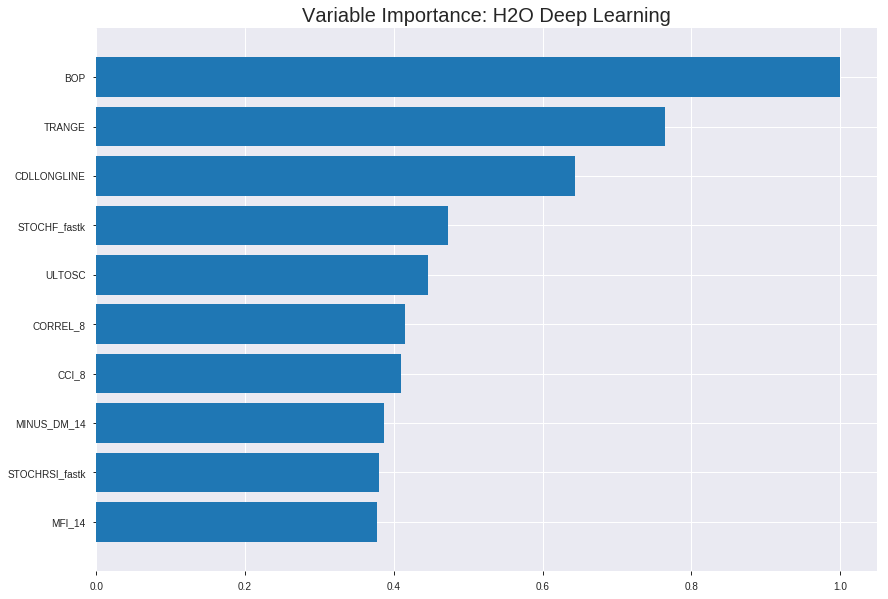

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_153912_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19910550020789472
RMSE: 0.44621239360633486
LogLoss: 0.583490222962492
Mean Per-Class Error: 0.293251420266878
AUC: 0.757269784647906
pr_auc: 0.7256255597477173
Gini: 0.5145395692958119
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5048946872608896: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      433  408   0.4851   (408.0/841.0)
1      119  781   0.1322   (119.0/900.0)
Total  552  1189  0.3027   (527.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504895     0.747726  228
max f2                       0.242152     0.855615  326
max f0point5                 0.570946     0.707903  188
max accuracy                 0.554677     0.710511  199
max precision                0.818783     0.865672  16
max recall                   0.122156     1         392
max specificity              0.853506     0.998811  0
max absolute_mcc             0.549338     0.426314  202
max min_per_class_accuracy   0.613304     0.687277  159
max mean_per_class_accuracy  0.554677     0.706749  199

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 54.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.837342           1.3971    1.3971             0.722222         0.842914  0.722222                    0.842914            0.0144444       0.0144444                  39.7099   39.7099
    2        0.0201034                   0.829681           1.70686   1.54756            0.882353         0.833527  0.8                         0.838355            0.0166667       0.0311111                  70.6863   54.7556
    3        0.0304423                   0.823235           1.82698   1.64245            0.944444         0.826053  0.849057                    0.834177            0.0188889       0.05                       82.6975   64.2453
    4        0.0402068                   0.815632           1.70686   1.6581             0.882353         0.819588  0.857143                    0.830634            0.0166667       0.0666667                  70.6863   65.8095
    5        0.0505457                   0.81142            1.50457   1.62669            0.777778         0.813726  0.840909                    0.827175            0.0155556       0.0822222                  50.4568   62.6692
    6        0.100517                    0.788306           1.35633   1.49229            0.701149         0.798308  0.771429                    0.812824            0.0677778       0.15                       35.6335   49.2286
    7        0.150488                    0.766804           1.3341    1.43976            0.689655         0.777321  0.744275                    0.801035            0.0666667       0.216667                   33.41     43.9758
    8        0.20046                     0.743269           1.62315   1.48548            0.83908          0.75486   0.767908                    0.789524            0.0811111       0.297778                   62.3155   48.5476
    9        0.300402                    0.702279           1.38969   1.45361            0.718391         0.722763  0.751434                    0.767313            0.138889        0.436667                   38.9687   45.3607
    10       0.400345                    0.660105           1.34522   1.42655            0.695402         0.682163  0.737446                    0.746056            0.134444        0.571111                   34.5217   42.6549
    11       0.500287                    0.61641            1.10063   1.36144            0.568966         0.638527  0.703789                    0.724575            0.11            0.681111                   10.0632   36.144
    12       0.60023                     0.566564           1.17845   1.33097            0.609195         0.591889  0.688038                    0.702482            0.117778        0.798889                   17.8455   33.0972
    13       0.700172                    0.478725           0.778225  1.25207            0.402299         0.530559  0.647252                    0.677941            0.0777778       0.876667                   -22.1775  25.2073
    14       0.800115                    0.296386           0.66705   1.179              0.344828         0.385886  0.609476                    0.641461            0.0666667       0.943333                   -33.295   17.8997
    15       0.900057                    0.172744           0.333525  1.08512            0.172414         0.223238  0.560944                    0.595021            0.0333333       0.976667                   -66.6475  8.51159
    16       1                           0.104405           0.233467  1                  0.12069          0.142257  0.516944                    0.549771          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20431394791777258
RMSE: 0.45201100419986745
LogLoss: 0.5959173590051913
Mean Per-Class Error: 0.29477533622874863
AUC: 0.7492936370828422
pr_auc: 0.7240375421641423
Gini: 0.4985872741656845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38084847275391387: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      110  131  0.5436   (131.0/241.0)
1      29   228  0.1128   (29.0/257.0)
Total  139  359  0.3213   (160.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380848     0.74026   281
max f2                       0.192071     0.850847  357
max f0point5                 0.549291     0.717164  191
max accuracy                 0.549291     0.704819  191
max precision                0.822319     1         0
max recall                   0.130579     1         395
max specificity              0.822319     1         0
max absolute_mcc             0.549291     0.410267  191
max min_per_class_accuracy   0.543505     0.700389  195
max mean_per_class_accuracy  0.549291     0.705225  191

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.804751           1.16265   1.16265            0.6              0.812754  0.6                         0.812754            0.0116732       0.0116732                  16.2646   16.2646
    2        0.0200803                   0.797372           1.55019   1.35642            0.8              0.801867  0.7                         0.807311            0.0155642       0.0272374                  55.0195   35.642
    3        0.0301205                   0.785708           1.55019   1.42101            0.8              0.793407  0.733333                    0.802676            0.0155642       0.0428016                  55.0195   42.1012
    4        0.0401606                   0.779101           1.93774   1.55019            1                0.781759  0.8                         0.797447            0.0194553       0.0622568                  93.7743   55.0195
    5        0.0502008                   0.774878           1.93774   1.6277             1                0.777716  0.84                        0.793501            0.0194553       0.0817121                  93.7743   62.7704
    6        0.100402                    0.735153           1.47268   1.55019            0.76             0.758048  0.8                         0.775774            0.07393         0.155642                   47.2685   55.0195
    7        0.150602                    0.706808           1.6277    1.57603            0.84             0.718722  0.813333                    0.756757            0.0817121       0.237354                   62.7704   57.6031
    8        0.200803                    0.674123           1.39518   1.53082            0.72             0.690265  0.79                        0.740134            0.0700389       0.307393                   39.5175   53.0817
    9        0.301205                    0.63259            1.35642   1.47268            0.7              0.651418  0.76                        0.710562            0.136187        0.44358                    35.642    47.2685
    10       0.399598                    0.586797           1.30501   1.4314             0.673469         0.607415  0.738693                    0.685164            0.128405        0.571984                   30.5011   43.1398
    11       0.5                         0.543697           1.24016   1.393              0.64             0.565895  0.718876                    0.661214            0.124514        0.696498                   24.0156   39.2996
    12       0.600402                    0.5014             0.697588  1.27671            0.36             0.524592  0.658863                    0.638368            0.0700389       0.766537                   -30.2412  27.6707
    13       0.698795                    0.410896           0.909553  1.22501            0.469388         0.458939  0.632184                    0.613103            0.0894942       0.856031                   -9.04471  22.501
    14       0.799197                    0.285583           0.697588  1.15875            0.36             0.34562   0.59799                     0.5795              0.0700389       0.92607                    -30.2412  15.8751
    15       0.899598                    0.190417           0.503813  1.08566            0.26             0.235608  0.560268                    0.541119            0.0505837       0.976654                   -49.6187  8.56552
    16       1                           0.106564           0.232529  1                  0.12             0.151194  0.516064                    0.50197            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:45:49  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:45:50  2 min 13.289 sec  498 obs/sec       0.528432  1             920        0.501932         0.73412             -0.00890007    0.662704        0.646682           1.28963          0.393452                         0.504867           0.73614               -0.020618        0.664885          0.662978             1.93774            0.411647
    2019-08-28 15:46:00  2 min 23.186 sec  794 obs/sec       4.92476   9             8574       0.453262         0.597431            0.177268       0.738973        0.711043           1.3971           0.325675                         0.460054           0.61273               0.152526         0.746831          0.725509             1.93774            0.329317
    2019-08-28 15:46:10  2 min 33.242 sec  955 obs/sec       10.9288   20            19027      0.454028         0.599191            0.174488       0.751978        0.723162           1.61204          0.321654                         0.454447           0.600551              0.17306          0.747227          0.720615             1.16265            0.317269
    2019-08-28 15:46:20  2 min 43.203 sec  1054 obs/sec      17.5244   32            30510      0.446212         0.58349             0.202662       0.75727         0.725626           1.3971           0.3027                           0.452011           0.595917              0.1819           0.749294          0.724038             1.16265            0.321285
    2019-08-28 15:46:30  2 min 52.730 sec  1142 obs/sec      24.6221   45            42867      0.446589         0.586751            0.201317       0.761276        0.72015            1.18216          0.292361                         0.452711           0.597579              0.179363         0.745677          0.711853             1.16265            0.355422
    2019-08-28 15:46:40  3 min  2.364 sec  1215 obs/sec      32.2481   59            56144      0.442562         0.576653            0.215654       0.769275        0.738972           1.71951          0.310741                         0.454153           0.602328              0.174127         0.750093          0.71824              1.16265            0.329317
    2019-08-28 15:46:49  3 min 12.099 sec  1281 obs/sec      40.4664   74            70452      0.437857         0.567944            0.232243       0.779641        0.756001           1.61204          0.298105                         0.456511           0.605776              0.165529         0.742682          0.71798              1.16265            0.333333
    2019-08-28 15:46:50  3 min 13.076 sec  1280 obs/sec      40.4664   74            70452      0.446212         0.58349             0.202662       0.75727         0.725626           1.3971           0.3027                           0.452011           0.595917              0.1819           0.749294          0.724038             1.16265            0.321285

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.04687217426844997
TRANGE                   0.7648242115974426     0.7648242115974426   0.03584897373072519
CDLLONGLINE              0.6440594792366028     0.6440594792366028   0.030188468150025183
STOCHF_fastk             0.47333505749702454    0.47333505749702454  0.022186243302367323
ULTOSC                   0.4459266662597656     0.4459266662597656   0.020901552411876665
---                      ---                    ---                  ---
ROC_24                   0.3226001262664795     0.3226001262664795   0.015120969337386393
LINEARREG_SLOPE_14       0.32092344760894775    0.32092344760894775  0.015042379763158375
BBANDS_upperband_20_6_5  0.3189757466316223     0.3189757466316223   0.014951086783526347
ROC_8                    0.31802186369895935    0.31802186369895935  0.014906376216474868
MACDEXT                  0.31452953815460205    0.31452953815460205  0.014742683324957593


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6907630522088354)

('F1', 0.708955223880597)

('auc', 0.7385273528649209)

('logloss', 0.5985312443671869)

('mean_per_class_error', 0.3021454498314753)

('rmse', 0.4542432490347767)

('mse', 0.20633692929367015)

deeplearning prediction progress: |███████████████████████████████████████| 100%


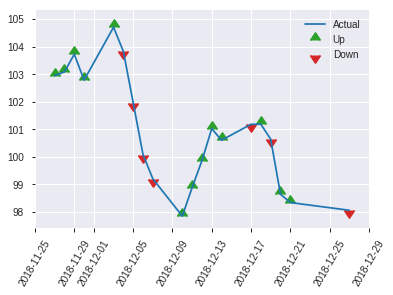


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20633692929367015
RMSE: 0.4542432490347767
LogLoss: 0.5985312443671869
Mean Per-Class Error: 0.3021454498314753
AUC: 0.7385273528649209
pr_auc: 0.6839939850115423
Gini: 0.47705470572984177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4872038338585134: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   57   0.4286   (57.0/133.0)
1      21   95   0.181    (21.0/116.0)
Total  97   152  0.3133   (78.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487204     0.708955  151
max f2                       0.164917     0.832138  232
max f0point5                 0.507548     0.661337  142
max accuracy                 0.507548     0.690763  142
max precision                0.802706     1         0
max recall                   0.164917     1         232
max specificity              0.802706     1         0
max absolute_mcc             0.495553     0.401395  146
max min_per_class_accuracy   0.542254     0.661654  121
max mean_per_class_accuracy  0.495553     0.697855  146

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.791723           2.14655   2.14655            1                0.797673  1                           0.797673            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.787308           1.07328   1.71724            0.5              0.787847  0.8                         0.793743            0.00862069      0.0344828                  7.32759   71.7241
    3        0.0321285                   0.775419           2.14655   1.87823            1                0.782685  0.875                       0.789596            0.0258621       0.0603448                  114.655   87.8233
    4        0.0401606                   0.767007           2.14655   1.9319             1                0.772348  0.9                         0.786146            0.0172414       0.0775862                  114.655   93.1897
    5        0.0522088                   0.759247           2.14655   1.98143            1                0.764443  0.923077                    0.781138            0.0258621       0.103448                   114.655   98.1432
    6        0.100402                    0.737011           1.43103   1.71724            0.666667         0.746324  0.8                         0.764427            0.0689655       0.172414                   43.1034   71.7241
    7        0.15261                     0.706427           1.15584   1.52518            0.538462         0.721267  0.710526                    0.749662            0.0603448       0.232759                   15.5836   52.5181
    8        0.200803                    0.685142           1.43103   1.50259            0.666667         0.693347  0.7                         0.736147            0.0689655       0.301724                   43.1034   50.2586
    9        0.301205                    0.632804           1.54552   1.5169             0.72             0.660725  0.706667                    0.711006            0.155172        0.456897                   54.5517   51.6897
    10       0.401606                    0.582001           1.03034   1.39526            0.48             0.607428  0.65                        0.685111            0.103448        0.560345                   3.03448   39.5259
    11       0.502008                    0.537767           1.20207   1.35662            0.56             0.557757  0.632                       0.659641            0.12069         0.681034                   20.2069   35.6621
    12       0.598394                    0.490652           1.25216   1.33979            0.583333         0.514292  0.624161                    0.636229            0.12069         0.801724                   25.2155   33.9794
    13       0.698795                    0.373552           0.686897  1.24599            0.32             0.437625  0.58046                     0.607694            0.0689655       0.87069                    -31.3103  24.5987
    14       0.799197                    0.277541           0.601034  1.16496            0.28             0.325901  0.542714                    0.572293            0.0603448       0.931034                   -39.8966  16.4963
    15       0.899598                    0.19262            0.42931   1.08286            0.2              0.232907  0.504464                    0.534415            0.0431034       0.974138                   -57.069   8.28587
    16       1                           0.103141           0.257586  1                  0.12             0.153856  0.465863                    0.496206         

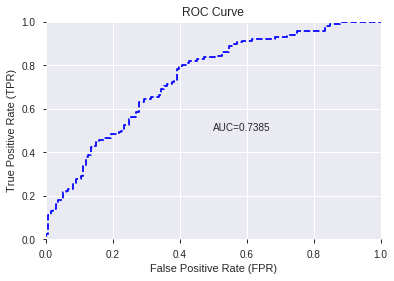

This function is available for GLM models only


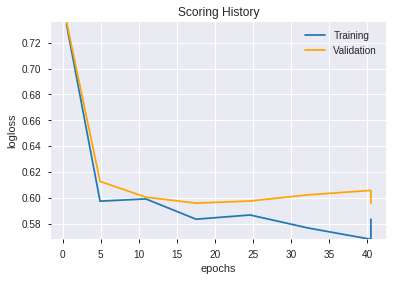

--2019-08-28 15:46:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


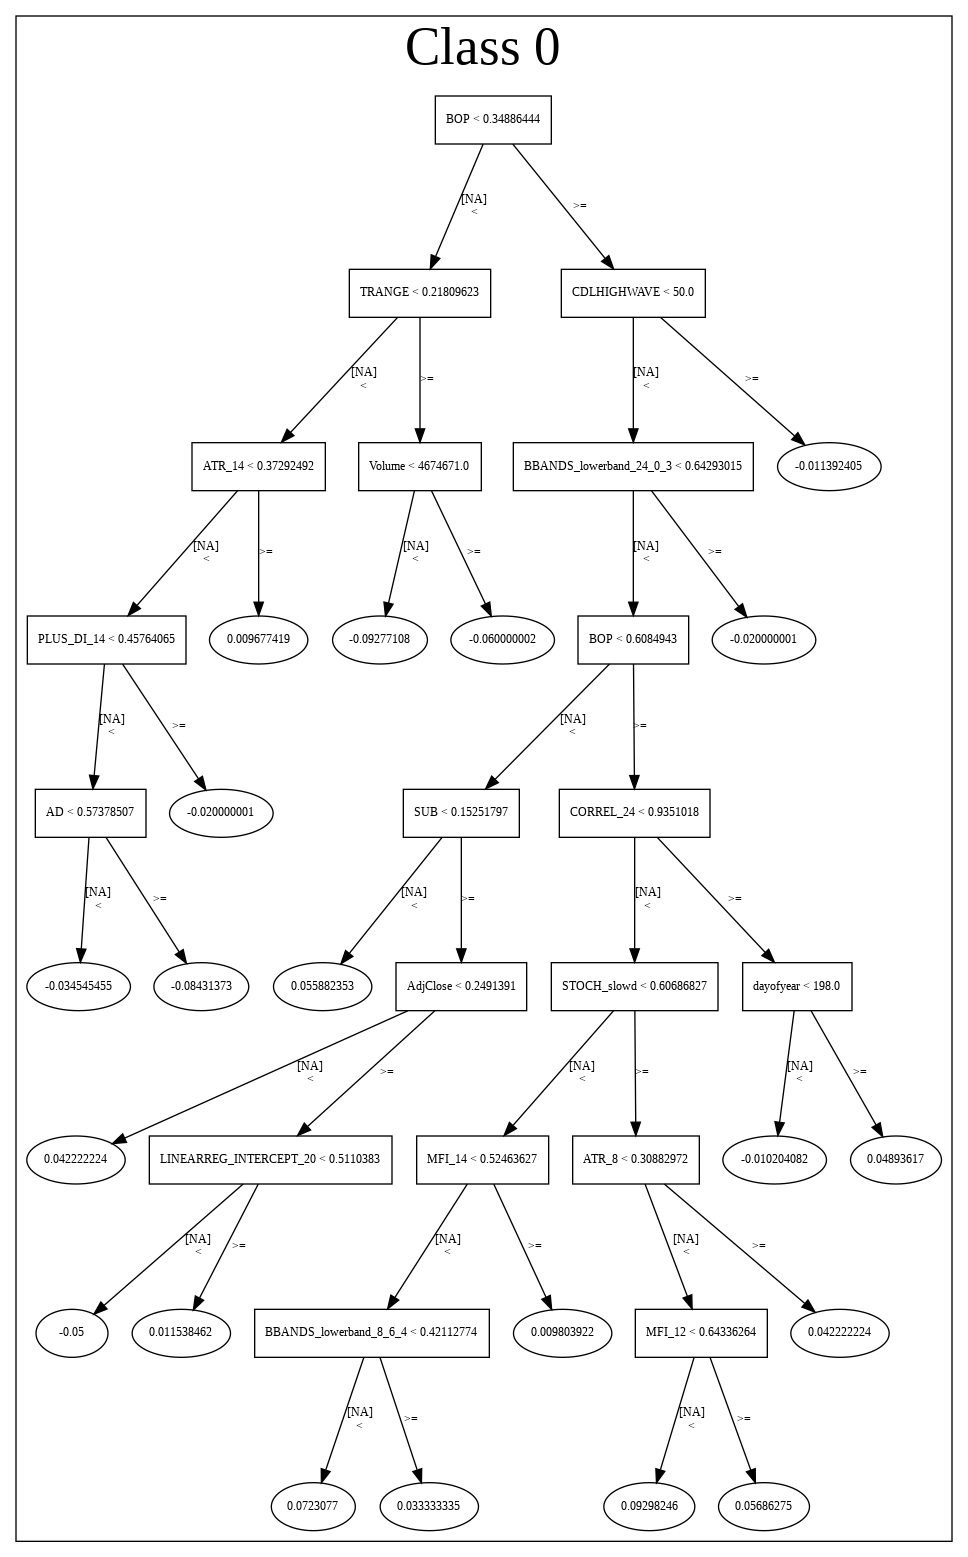

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_153912_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_153912_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'ULTOSC',
 'CORREL_8',
 'CCI_8',
 'MINUS_DM_14',
 'STOCHRSI_fastk',
 'MFI_14',
 'DX_12',
 'OBV',
 'DX_8',
 'WILLR_8',
 'ADXR_8',
 'VAR_12',
 'PLUS_DI_30',
 'CDLSPINNINGTOP',
 'aroonup_12',
 'BETA_8',
 'AD',
 'STOCHRSI_fastd',
 'PLUS_DI_12',
 'MACDFIX_signal_20',
 'ROCP_30',
 'ATR_8',
 'aroondown_8',
 'ADOSC',
 'STOCHF_fastd',
 'MOM_30',
 'HT_PHASOR_inphase',
 'BBANDS_middleband_14_5_3',
 'BBANDS_upperband_30_1_5',
 'ROC_20',
 'MFI_8',
 'AROONOSC_24',
 'BBANDS_lowerband_30_1_5',
 'STOCH_slowd',
 'aroondown_12',
 'BBANDS_lowerband_20_2_5',
 'MOM_24',
 'MFI_12',
 'WILLR_14',
 'ROCR100_8',
 'MAVP_20_2',
 'LINEARREG_ANGLE_14',
 'ADX_20',
 'NATR_12',
 'ROCR100_12',
 'ROCR_24',
 'MACDFIX_hist_12',
 'aroondown_14',
 'ROC_24',
 'LINEARREG_SLOPE_14',
 'BBANDS_upperband_20_6_5',
 'ROC_8',
 'MACDEXT']

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_154708_model_1  0.761537  0.583501              0.293525  0.446946  0.199761

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.506982           1.000000    0.127954
1                     TRANGE             0.377015           0.743645    0.095152
2               STOCHF_fastk             0.271196           0.534923    0.068445
3                     ULTOSC             0.205334           0.405013    0.051823
4                MINUS_DM_14             0.185527           0.365945    0.046824
5                     MFI_14             0.150577           0.297007    0.038003
6                      CCI_8             0.146621           0.289204    0.037005
7                    WILLR_8             0.114550           0.225945    0.028910
8                         AD             0.100902           0.199026    0.025466
9             CDLSPINNINGTOP             0.098514           0.194315    0.024863
10                PLUS_DI_12             0.095647           0.188660    0.024140
11                    ROC_20             0.094801           0.186991    0.023926
12                  WILLR_14             0.086013           0.169657    0.021708
13        LINEARREG_SLOPE_14             0.084452           0.166578    0.021314
14            STOCHRSI_fastd             0.081701           0.161151    0.020620
15               aroondown_8             0.078961           0.155747    0.019928
16                    MOM_30             0.076393           0.150681    0.019280
17                   ROCP_30             0.075261           0.148449    0.018995
18               STOCH_slowd             0.074958           0.147851    0.018918
19         MACDFIX_signal_20             0.068072           0.134269    0.017180
20                PLUS_DI_30             0.064506           0.127235    0.016280
21            STOCHRSI_fastk             0.056187           0.110826    0.014181
22        LINEARREG_ANGLE_14             0.054018           0.106548    0.013633
23         HT_PHASOR_inphase             0.050326           0.099265    0.012701
24               CDLLONGLINE             0.049138           0.096923    0.012402
25           MACDFIX_hist_12             0.048129           0.094932    0.012147
26   BBANDS_lowerband_20_2_5             0.046551           0.091821    0.011749
27                     ATR_8             0.040360           0.079609    0.010186
28                  CORREL_8             0.039296           0.077509    0.009918
29              aroondown_12             0.034480           0.068011    0.008702
30                      DX_8             0.034417           0.067887    0.008686
31                   NATR_12             0.034291           0.067637    0.008654
32                       OBV             0.033473           0.066025    0.008448
33   BBANDS_upperband_20_6_5             0.029420           0.058029    0.007425
34              STOCHF_fastd             0.029137           0.057471    0.007354
35                    ROC_24             0.028914           0.057032    0.007297
36                   ROCR_24             0.028780           0.056767    0.007264
37                     MFI_8             0.027112           0.053477    0.006843
38               AROONOSC_24             0.026009           0.051301    0.006564
39   BBANDS_lowerband_30_1_5             0.025594           0.050484    0.006460
40                 MAVP_20_2             0.024477           0.048279    0.006178
41                     DX_12             0.022294           0.043974    0.005627
42                    ADXR_8             0.022218           0.043825    0.005608
43                   MACDEXT             0.022104           0.043599    0.005579
44                    BETA_8             0.017509           0.034535    0.004419
45                    MOM_24             0.016750           0.033038    0.004227
46                ROCR100_12             0.013745           0.027112    0.003469
47                    MFI_12             0.013116           0.025871    0.003310
48   BBANDS_upperband_30_1_5             0.012806  

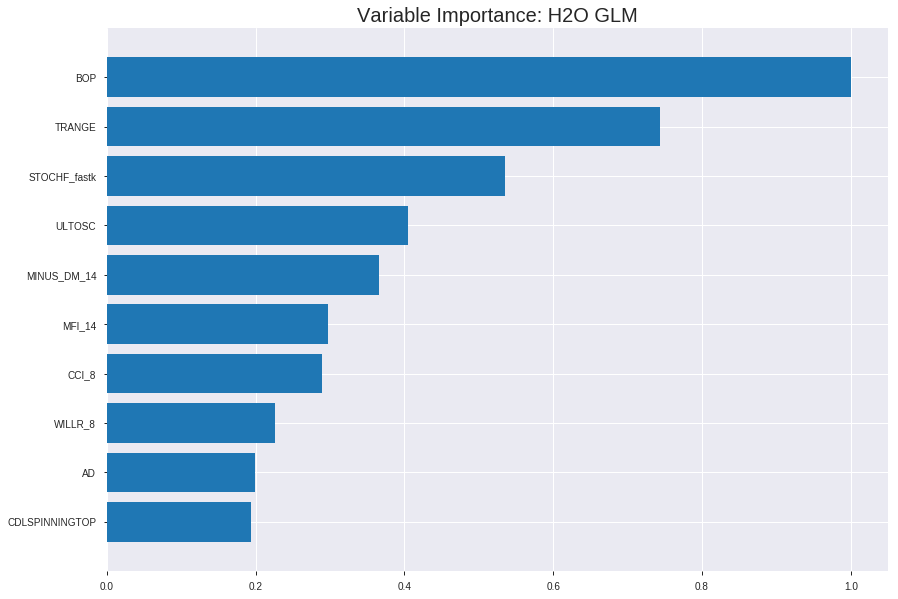

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_154708_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2004017351344252
RMSE: 0.4476625237100211
LogLoss: 0.586960453627379
Null degrees of freedom: 1740
Residual degrees of freedom: 1683
Null deviance: 2411.5386742145693
Residual deviance: 2043.7962995305343
AIC: 2159.7962995305343
AUC: 0.7554346677236095
pr_auc: 0.7231828652655627
Gini: 0.5108693354472189
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3994361054422391: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      391  450   0.5351   (450.0/841.0)
1      92   808   0.1022   (92.0/900.0)
Total  483  1258  0.3113   (542.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399436     0.748842  254
max f2                       0.248134     0.857671  328
max f0point5                 0.515945     0.706889  191
max accuracy                 0.447079     0.701895  227
max precision                0.893991     1         0
max recall                   0.0600878    1         395
max specificity              0.893991     1         0
max absolute_mcc             0.439428     0.413341  231
max min_per_class_accuracy   0.539834     0.682521  176
max mean_per_class_accuracy  0.515945     0.699847  191

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.83501            1.28963   1.28963            0.666667         0.852254  0.666667                    0.852254            0.0133333       0.0133333                  28.963    28.963
    2        0.0201034                   0.818609           1.47928   1.38175            0.764706         0.825827  0.714286                    0.839418            0.0144444       0.0277778                  47.9281   38.1746
    3        0.0304423                   0.804314           1.71951   1.49646            0.888889         0.812093  0.773585                    0.830138            0.0177778       0.0455556                  71.9506   49.6457
    4        0.0402068                   0.796388           1.82065   1.57519            0.941176         0.80012   0.814286                    0.822848            0.0177778       0.0633333                  82.0654   57.519
    5        0.0505457                   0.787924           1.50457   1.56074            0.777778         0.792127  0.806818                    0.816564            0.0155556       0.0788889                  50.4568   56.0745
    6        0.100517                    0.751089           1.46751   1.51439            0.758621         0.768551  0.782857                    0.792695            0.0733333       0.152222                   46.751    51.4394
    7        0.150488                    0.726094           1.51198   1.51359            0.781609         0.73921   0.782443                    0.774934            0.0755556       0.227778                   51.198    51.3592
    8        0.20046                     0.701388           1.42304   1.49102            0.735632         0.713359  0.770774                    0.759585            0.0711111       0.298889                   42.304    49.1019
    9        0.300402                    0.64863            1.36745   1.44991            0.706897         0.673815  0.749522                    0.731049            0.136667        0.435556                   36.7452   44.9909
    10       0.400345                    0.593857           1.3341    1.421              0.689655         0.620321  0.734577                    0.703407            0.133333        0.568889                   33.41     42.0998
    11       0.500287                    0.543495           1.08951   1.35478            0.563218         0.56915   0.700344                    0.676587            0.108889        0.677778                   8.95147   35.4777
    12       0.60023                     0.478152           1.11175   1.31431            0.574713         0.513158  0.679426                    0.649375            0.111111        0.788889                   11.175    31.4312
    13       0.700172                    0.415687           0.878282  1.25207            0.454023         0.447154  0.647252                    0.62051             0.0877778       0.876667                   -12.1718  25.2073
    14       0.800115                    0.338228           0.655932  1.17761            0.33908          0.377037  0.608758                    0.590097            0.0655556       0.942222                   -34.4068  17.7609
    15       0.900057                    0.233024           0.40023   1.09129            0.206897         0.281449  0.564135                    0.555825            0.04            0.982222                   -59.977   9.12884
    16       1                           0.0276469          0.17788   1                  0.091954         0.166795  0.516944                    0.516944           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20556206365638943
RMSE: 0.45338952751071504
LogLoss: 0.5974025883190729
Null degrees of freedom: 497
Residual degrees of freedom: 440
Null deviance: 689.8619915534578
Residual deviance: 595.0129779657967
AIC: 711.0129779657967
AUC: 0.7579153010316935
pr_auc: 0.7351284960362088
Gini: 0.5158306020633869
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3584980614035639: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  112  0.4647   (112.0/241.0)
1      40   217  0.1556   (40.0/257.0)
Total  169  329  0.3052   (152.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358498     0.740614  262
max f2                       0.1943       0.857726  350
max f0point5                 0.516145     0.728111  164
max accuracy                 0.506522     0.704819  170
max precision                0.868191     1         0
max recall                   0.0727551    1         396
max specificity              0.868191     1         0
max absolute_mcc             0.506522     0.418524  170
max min_per_class_accuracy   0.464021     0.684825  195
max mean_per_class_accuracy  0.506522     0.707291  170

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 44.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.776605           1.55019   1.55019            0.8              0.806518  0.8                         0.806518            0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.760627           1.55019   1.55019            0.8              0.76978   0.8                         0.788149            0.0155642       0.0311284                  55.0195   55.0195
    3        0.0301205                   0.741933           1.55019   1.55019            0.8              0.754773  0.8                         0.777024            0.0155642       0.0466926                  55.0195   55.0195
    4        0.0401606                   0.737058           1.55019   1.55019            0.8              0.739781  0.8                         0.767713            0.0155642       0.0622568                  55.0195   55.0195
    5        0.0502008                   0.734629           1.55019   1.55019            0.8              0.735732  0.8                         0.761317            0.0155642       0.077821                   55.0195   55.0195
    6        0.100402                    0.696193           1.39518   1.47268            0.72             0.715138  0.76                        0.738227            0.0700389       0.14786                    39.5175   47.2685
    7        0.150602                    0.651485           1.86023   1.60187            0.96             0.674758  0.826667                    0.717071            0.0933852       0.241245                   86.0233   60.1868
    8        0.200803                    0.626679           1.39518   1.55019            0.72             0.636213  0.8                         0.696856            0.0700389       0.311284                   39.5175   55.0195
    9        0.301205                    0.581676           1.31767   1.47268            0.68             0.601049  0.76                        0.664921            0.132296        0.44358                    31.7665   47.2685
    10       0.399598                    0.522028           1.42365   1.46061            0.734694         0.551079  0.753769                    0.636889            0.140078        0.583658                   42.3648   46.061
    11       0.5                         0.458247           1.00763   1.36965            0.52             0.490362  0.706827                    0.607466            0.101167        0.684825                   0.762646  36.965
    12       0.600402                    0.393102           0.852607  1.28319            0.44             0.426126  0.662207                    0.577142            0.0856031       0.770428                   -14.7393  28.3188
    13       0.698795                    0.330045           0.870007  1.22501            0.44898          0.363566  0.632184                    0.547069            0.0856031       0.856031                   -12.9993  22.501
    14       0.799197                    0.269417           0.697588  1.15875            0.36             0.298488  0.59799                     0.51584             0.0700389       0.92607                    -30.2412  15.8751
    15       0.899598                    0.186183           0.542568  1.08998            0.28             0.223452  0.5625                      0.483208            0.0544747       0.980545                   -45.7432  8.99805
    16       1                           0.01749            0.193774  1                  0.1              0.134801  0.516064                    0.448227            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:47:08  0.000 sec   2            18        58            1.37206           1.37279
    2019-08-28 15:47:08  0.013 sec   4            11        58            1.36546           1.36641
    2019-08-28 15:47:08  0.027 sec   6            7.1       58            1.35625           1.35745
    2019-08-28 15:47:08  0.041 sec   8            4.4       58            1.34401           1.34544
    2019-08-28 15:47:08  0.055 sec   10           2.8       58            1.32851           1.33014
    2019-08-28 15:47:08  0.068 sec   12           1.7       58            1.31007           1.31183
    2019-08-28 15:47:08  0.082 sec   14           1.1       58            1.28956           1.2914
    2019-08-28 15:47:08  0.097 sec   16           0.66      58            1.26824           1.27018
    2019-08-28 15:47:08  0.111 sec   18           0.41      58            1.24737           1.24966
    2019-08-28 15:47:08  0.125 sec   20           0.25      58            1.228             1.23124
    2019-08-28 15:47:08  0.140 sec   22           0.16      58            1.21082           1.21608
    2019-08-28 15:47:08  0.154 sec   24           0.098     58            1.19611           1.20487
    2019-08-28 15:47:08  0.168 sec   26           0.061     58            1.18387           1.19785
    2019-08-28 15:47:08  0.185 sec   28           0.038     58            1.17392           1.19481
    2019-08-28 15:47:08  0.199 sec   30           0.023     58            1.16602           1.19526
    2019-08-28 15:47:08  0.213 sec   32           0.015     58            1.15991           1.19869
    2019-08-28 15:47:08  0.229 sec   34           0.0091    58            1.15543           1.20445
    2019-08-28 15:47:08  0.243 sec   36           0.0056    58            1.15232           1.21158
    2019-08-28 15:47:08  0.261 sec   38           0.0035    58            1.15029           1.21916

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.714859437751004)

('F1', 0.7169811320754716)

('auc', 0.7615374643505315)

('logloss', 0.583500814400713)

('mean_per_class_error', 0.28234379051075975)

('rmse', 0.44694620105378036)

('mse', 0.19976090663640628)

glm prediction progress: |████████████████████████████████████████████████| 100%


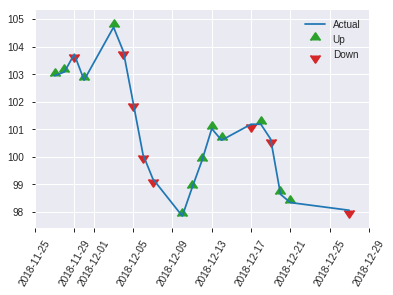


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19976090663640628
RMSE: 0.44694620105378036
LogLoss: 0.583500814400713
Null degrees of freedom: 248
Residual degrees of freedom: 191
Null deviance: 346.62607336051315
Residual deviance: 290.5834055715551
AIC: 406.5834055715551
AUC: 0.7615374643505315
pr_auc: 0.7233893247985489
Gini: 0.523074928701063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3877265227940389: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   54   0.406    (54.0/133.0)
1      21   95   0.181    (21.0/116.0)
Total  100  149  0.3012   (75.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387727     0.716981  148
max f2                       0.220812     0.828402  211
max f0point5                 0.428857     0.688291  128
max accuracy                 0.428857     0.714859  128
max precision                0.816526     1         0
max recall                   0.131517     1         236
max specificity              0.816526     1         0
max absolute_mcc             0.425676     0.43489   130
max min_per_class_accuracy   0.446189     0.699248  121
max mean_per_class_accuracy  0.425676     0.717656  130

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 44.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.780042           2.14655   2.14655            1                0.799413  1                           0.799413            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.769444           2.14655   2.14655            1                0.776137  1                           0.790103            0.0172414       0.0431034                  114.655   114.655
    3        0.0321285                   0.742096           2.14655   2.14655            1                0.752209  1                           0.775893            0.0258621       0.0689655                  114.655   114.655
    4        0.0401606                   0.735616           2.14655   2.14655            1                0.738958  1                           0.768506            0.0172414       0.0862069                  114.655   114.655
    5        0.0522088                   0.723312           1.43103   1.98143            0.666667         0.727557  0.923077                    0.759056            0.0172414       0.103448                   43.1034   98.1432
    6        0.100402                    0.696808           1.60991   1.8031             0.75             0.711233  0.84                        0.736101            0.0775862       0.181034                   60.9914   80.3103
    7        0.15261                     0.65931            1.65119   1.75113            0.769231         0.678989  0.815789                    0.716562            0.0862069       0.267241                   65.1194   75.1134
    8        0.200803                    0.613848           1.25216   1.63138            0.583333         0.634517  0.76                        0.696872            0.0603448       0.327586                   25.2155   63.1379
    9        0.301205                    0.57676            1.37379   1.54552            0.64             0.59812   0.72                        0.663955            0.137931        0.465517                   37.3793   54.5517
    10       0.401606                    0.523447           1.20207   1.45966            0.56             0.547478  0.68                        0.634835            0.12069         0.586207                   20.2069   45.9655
    11       0.502008                    0.438378           1.28793   1.42531            0.6              0.474667  0.664                       0.602802            0.12931         0.715517                   28.7931   42.531
    12       0.598394                    0.387104           1.07328   1.36861            0.5              0.413568  0.637584                    0.572321            0.103448        0.818966                   7.32759   36.8607
    13       0.698795                    0.335731           0.601034  1.25832            0.28             0.35823   0.586207                    0.541561            0.0603448       0.87931                    -39.8966  25.8323
    14       0.799197                    0.25495            0.515172  1.16496            0.24             0.291903  0.542714                    0.510197            0.0517241       0.931034                   -48.4828  16.4963
    15       0.899598                    0.173447           0.42931   1.08286            0.2              0.220799  0.504464                    0.477898            0.0431034       0.974138                   -57.069   8.28587
    16       1                           0.0248385          0.257586  1                  0.12             0.119273  0.465863                    0.441892          

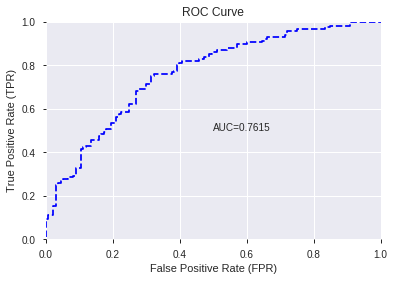

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


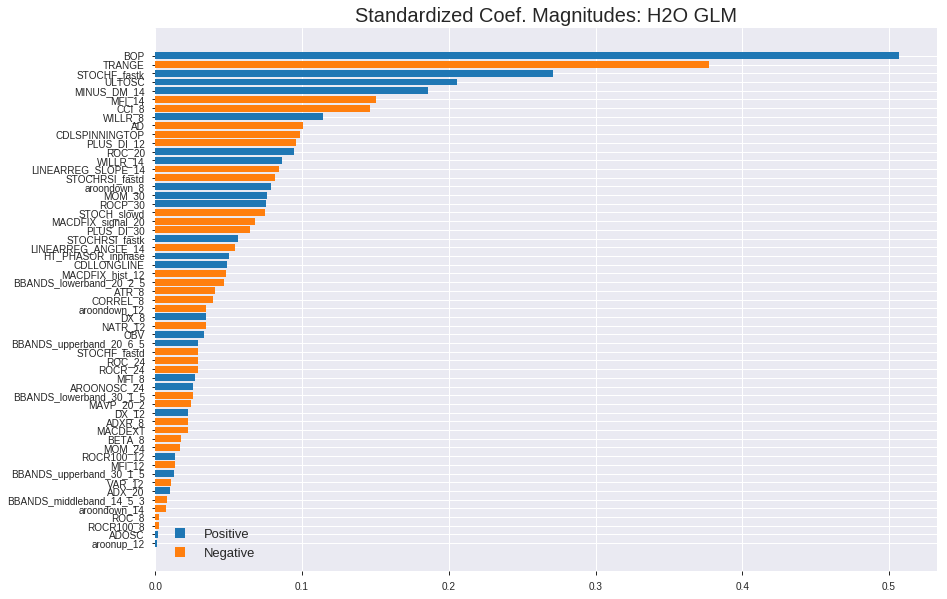

'log_likelihood'
--2019-08-28 15:47:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


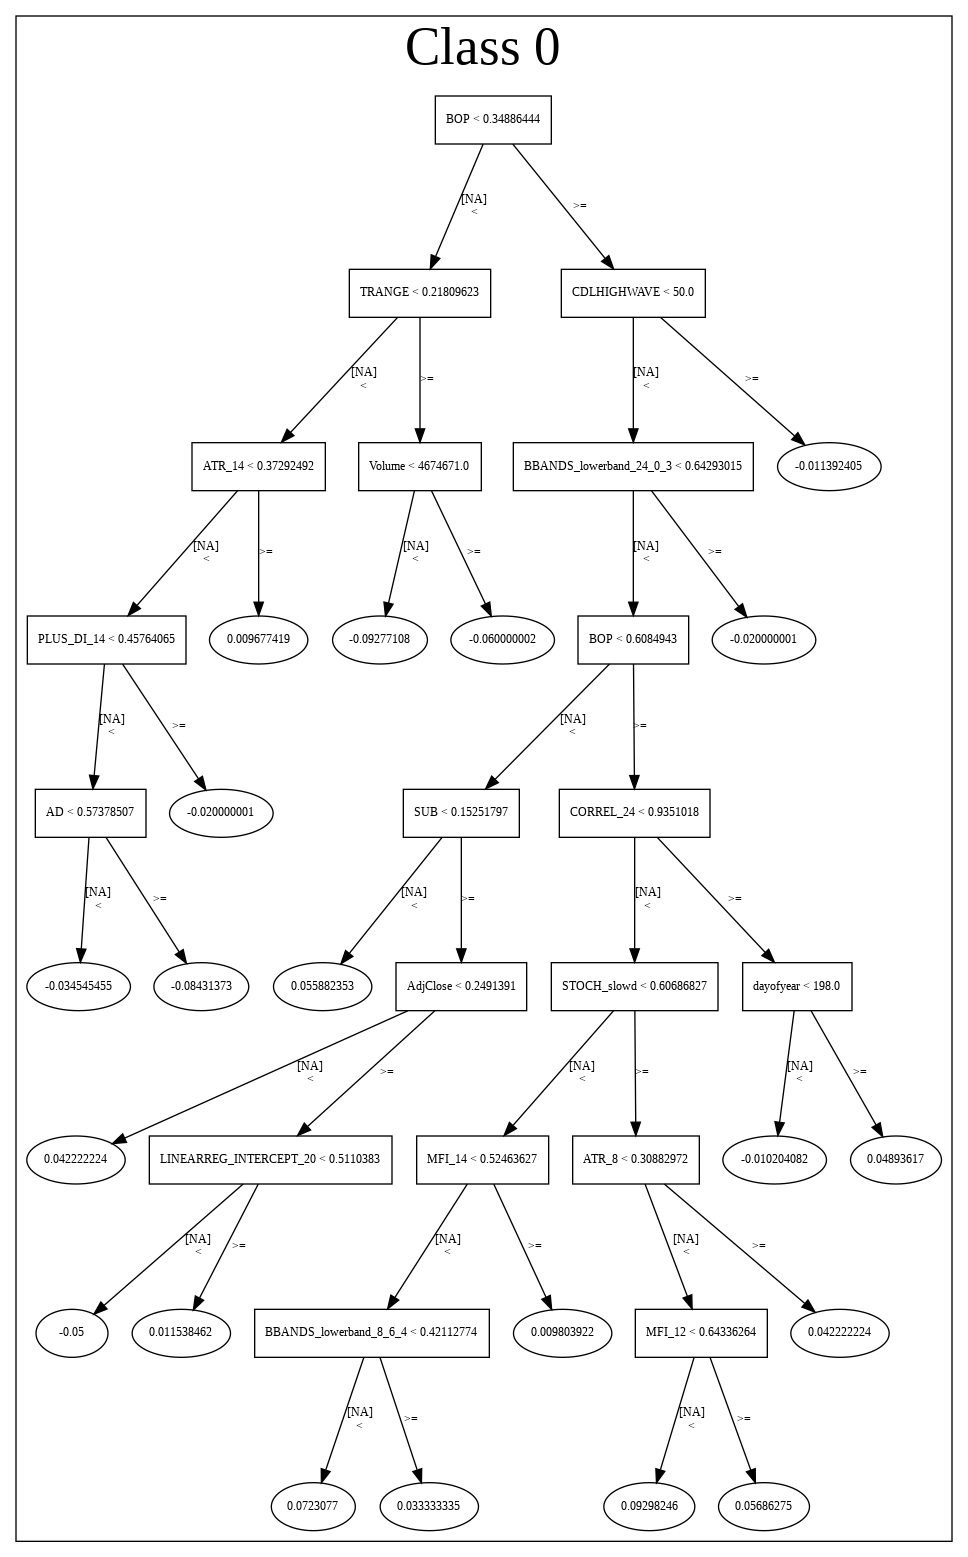

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_154708_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_154708_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'ULTOSC',
 'MINUS_DM_14',
 'MFI_14',
 'CCI_8',
 'WILLR_8',
 'AD',
 'CDLSPINNINGTOP',
 'PLUS_DI_12',
 'ROC_20',
 'WILLR_14',
 'LINEARREG_SLOPE_14',
 'STOCHRSI_fastd',
 'aroondown_8',
 'MOM_30',
 'ROCP_30',
 'STOCH_slowd',
 'MACDFIX_signal_20',
 'PLUS_DI_30',
 'STOCHRSI_fastk',
 'LINEARREG_ANGLE_14',
 'HT_PHASOR_inphase',
 'CDLLONGLINE',
 'MACDFIX_hist_12',
 'BBANDS_lowerband_20_2_5',
 'ATR_8',
 'CORREL_8',
 'aroondown_12',
 'DX_8',
 'NATR_12',
 'OBV',
 'BBANDS_upperband_20_6_5',
 'STOCHF_fastd',
 'ROC_24',
 'ROCR_24',
 'MFI_8',
 'AROONOSC_24',
 'BBANDS_lowerband_30_1_5',
 'MAVP_20_2',
 'DX_12',
 'ADXR_8',
 'MACDEXT',
 'BETA_8',
 'MOM_24',
 'ROCR100_12',
 'MFI_12',
 'BBANDS_upperband_30_1_5',
 'VAR_12',
 'ADX_20',
 'BBANDS_middleband_14_5_3',
 'aroondown_14',
 'ROC_8',
 'ROCR100_8',
 'ADOSC',
 'aroonup_12']

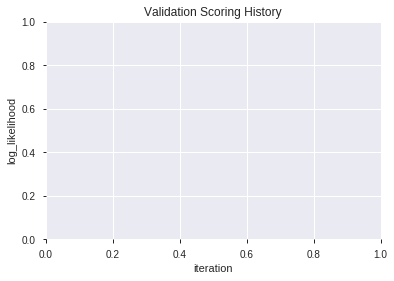

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_154725_model_4  0.756158  0.591221              0.282895  0.450617  0.203056
1               XGBoost_3_AutoML_20190828_154725  0.755445  0.595293              0.327262  0.451522  0.203872
2               XGBoost_2_AutoML_20190828_154725  0.749676  0.596320              0.293622  0.452942  0.205156
3               XGBoost_1_AutoML_20190828_154725  0.747278  0.601926              0.341749  0.455584  0.207556
4  XGBoost_grid_1_AutoML_20190828_154725_model_2  0.740472  0.608776              0.282344  0.458140  0.209892
5  XGBoost_grid_1_AutoML_20190828_154725_model_1  0.732759  0.618003              0.323049  0.462338  0.213757
6  XGBoost_grid_1_AutoML_20190828_154725_model_6  0.730425  0.608050              0.333128  0.458099  0.209855
7  XGBoost_grid_1_AutoML_20190828_154725_model_3  0.729453  0.613713              0.358893  0.460219  0.211801
8  XGBoost_grid_1_AutoML_20190828_154725_model_7  0.725823  0.616758              0.339091  0.462470  0.213878
9  XGBoost_grid_1_AutoML_20190828_154725_model_5  0.718499  0.645561              0.357888  0.474146  0.224814

variable  relative_importance  scaled_importance  percentage
0                        BOP          1851.572998           1.000000    0.354184
1                     TRANGE           598.952026           0.323483    0.114573
2               STOCHF_fastk           408.728607           0.220747    0.078185
3                      CCI_8           140.349319           0.075800    0.026847
4                     MFI_14           116.371353           0.062850    0.022260
5                     MFI_12           112.716599           0.060876    0.021561
6                     ADXR_8            94.690651           0.051141    0.018113
7                         AD            91.130539           0.049218    0.017432
8                     BETA_8            85.270996           0.046053    0.016311
9         LINEARREG_ANGLE_14            82.663948           0.044645    0.015813
10                PLUS_DI_30            80.185669           0.043307    0.015339
11                    ULTOSC            79.848343           0.043125    0.015274
12                     ADOSC            71.224373           0.038467    0.013624
13               MINUS_DM_14            70.114365           0.037867    0.013412
14                   NATR_12            68.294762           0.036885    0.013064
15         MACDFIX_signal_20            67.864914           0.036653    0.012982
16                      DX_8            62.532009           0.033772    0.011962
17                    MOM_30            60.792450           0.032833    0.011629
18                       OBV            59.720428           0.032254    0.011424
19                     ROC_8            59.305515           0.032030    0.011344
20                     MFI_8            55.530708           0.029991    0.010622
21   BBANDS_lowerband_20_2_5            54.504852           0.029437    0.010426
22                PLUS_DI_12            54.415852           0.029389    0.010409
23                  CORREL_8            52.281971           0.028237    0.010001
24                     DX_12            51.504215           0.027816    0.009852
25            STOCHRSI_fastk            49.658848           0.026820    0.009499
26                    ADX_20            49.525978           0.026748    0.009474
27            STOCHRSI_fastd            45.782661           0.024726    0.008758
28                     ATR_8            45.425053           0.024533    0.008689
29         HT_PHASOR_inphase            39.562611           0.021367    0.007568
30  BBANDS_middleband_14_5_3            38.034916           0.020542    0.007276
31                    VAR_12            35.809887           0.019340    0.006850
32            CDLSPINNINGTOP            34.729923           0.018757    0.006643
33           MACDFIX_hist_12            33.011559           0.017829    0.006315
34                  WILLR_14            29.768293           0.016077    0.005694
35              aroondown_14            28.441639           0.015361    0.005441
36                    ROC_20            26.415016           0.014266    0.005053
37              STOCHF_fastd            25.347467           0.013690    0.004849
38                    ROC_24            23.318983           0.012594    0.004461
39   BBANDS_lowerband_30_1_5            21.115860           0.011404    0.004039
40                   MACDEXT            20.184372           0.010901    0.003861
41   BBANDS_upperband_30_1_5            18.909637           0.010213    0.003617
42                   ROCP_30            18.766460           0.010135    0.003590
43                ROCR100_12            17.222807           0.009302    0.003295
44               AROONOSC_24            16.566200           0.008947    0.003169
45   BBANDS_upperband_20_6_5            14.757669           0.007970    0.002823
46                   WILLR_8            14.441722           0.007800    0.002763
47                    MOM_24            14.116909           0.007624    0.002700
48               STOCH_slowd            13.012869  

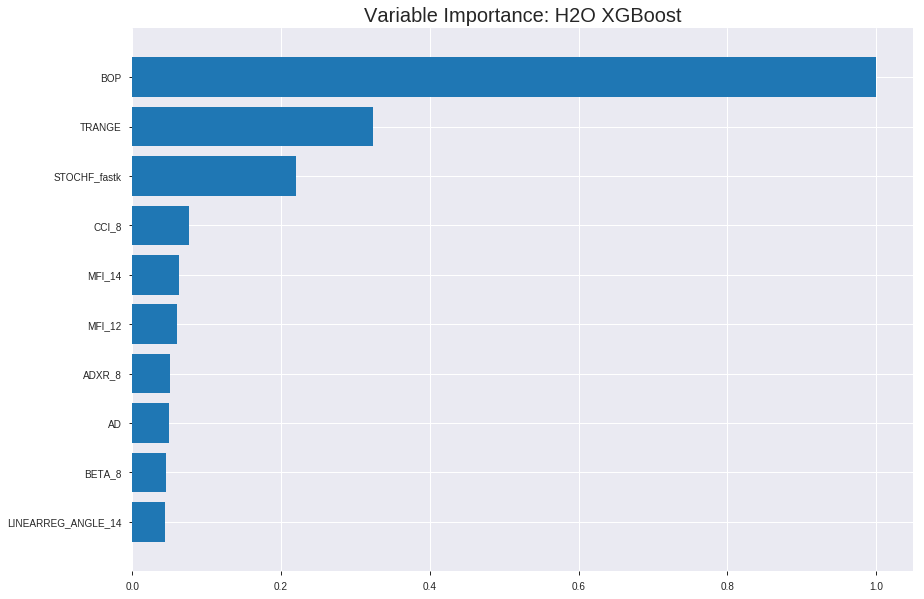

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_154725_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17613470828355876
RMSE: 0.4196840576952605
LogLoss: 0.5313095756192631
Mean Per-Class Error: 0.25030981635618965
AUC: 0.8323398071079402
pr_auc: 0.8370133840322459
Gini: 0.6646796142158804
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4256583034992218: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      452  389   0.4625   (389.0/841.0)
1      91   809   0.1011   (91.0/900.0)
Total  543  1198  0.2757   (480.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425658     0.771211  241
max f2                       0.289546     0.870042  308
max f0point5                 0.629144     0.77414   126
max accuracy                 0.538128     0.750144  184
max precision                0.841275     1         0
max recall                   0.105404     1         391
max specificity              0.841275     1         0
max absolute_mcc             0.585293     0.499935  156
max min_per_class_accuracy   0.567844     0.745556  167
max mean_per_class_accuracy  0.585293     0.74969   156

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.805176           1.93444    1.93444            1                0.821391  1                           0.821391            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.794883           1.70686    1.8239             0.882353         0.800672  0.942857                    0.811327            0.0166667       0.0366667                  70.6863   82.3905
    3        0.0304423                   0.784735           1.93444    1.86145            1                0.788638  0.962264                    0.803621            0.02            0.0566667                  93.4444   86.1447
    4        0.0402068                   0.778595           1.93444    1.87917            1                0.782229  0.971429                    0.798426            0.0188889       0.0755556                  93.4444   87.9175
    5        0.0505457                   0.768497           1.71951    1.84652            0.888889         0.773503  0.954545                    0.793328            0.0177778       0.0933333                  71.9506   84.6515
    6        0.100517                    0.744646           1.7788     1.81285            0.91954          0.756147  0.937143                    0.774844            0.0888889       0.182222                   77.8799   81.2851
    7        0.150488                    0.724892           1.8455     1.82369            0.954023         0.735188  0.942748                    0.761676            0.0922222       0.274444                   84.5504   82.3694
    8        0.20046                     0.703451           1.60092    1.76816            0.827586         0.712718  0.91404                     0.749471            0.08            0.354444                   60.092    76.816
    9        0.300402                    0.666978           1.47863    1.67183            0.764368         0.683825  0.864245                    0.727631            0.147778        0.502222                   47.8627   67.1833
    10       0.400345                    0.622131           1.26739    1.57087            0.655172         0.64438   0.812052                    0.706848            0.126667        0.628889                   26.7395   57.0869
    11       0.500287                    0.570355           1.0784     1.47249            0.557471         0.595791  0.761194                    0.684662            0.107778        0.736667                   7.83972   47.2488
    12       0.60023                     0.504133           0.956105   1.38651            0.494253         0.538682  0.716746                    0.660356            0.0955556       0.832222                   -4.38953  38.6506
    13       0.700172                    0.410809           0.733755   1.29333            0.37931          0.462963  0.668581                    0.63218             0.0733333       0.905556                   -26.6245  29.3332
    14       0.800115                    0.303126           0.57811    1.20399            0.298851         0.355128  0.622398                    0.597573            0.0577778       0.963333                   -42.189   20.3994
    15       0.900057                    0.190015           0.289055   1.1024             0.149425         0.249975  0.569879                    0.558976            0.0288889       0.992222                   -71.0945  10.2399
    16       1                           0.087246           0.0778225  1                  0.0402299        0.137561  0.516944                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20231917187098472
RMSE: 0.44979903498227375
LogLoss: 0.5911855559555446
Mean Per-Class Error: 0.30216994688150867
AUC: 0.7638568222548718
pr_auc: 0.755387704558083
Gini: 0.5277136445097437
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40051937103271484: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  115  0.4772   (115.0/241.0)
1      39   218  0.1518   (39.0/257.0)
Total  165  333  0.3092   (154.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400519     0.738983  257
max f2                       0.208702     0.854993  341
max f0point5                 0.577873     0.721003  139
max accuracy                 0.529691     0.696787  178
max precision                0.715826     0.928571  25
max recall                   0.0860962    1         399
max specificity              0.815074     0.995851  0
max absolute_mcc             0.595725     0.401458  128
max min_per_class_accuracy   0.513587     0.680934  188
max mean_per_class_accuracy  0.529691     0.69783   178

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 47.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.757507           1.16265   1.16265            0.6              0.781411  0.6                         0.781411            0.0116732       0.0116732                  16.2646   16.2646
    2        0.0200803                   0.745625           1.93774   1.55019            1                0.752119  0.8                         0.766765            0.0194553       0.0311284                  93.7743   55.0195
    3        0.0301205                   0.738283           1.93774   1.67938            1                0.742009  0.866667                    0.758513            0.0194553       0.0505837                  93.7743   67.9377
    4        0.0401606                   0.729816           1.93774   1.74397            1                0.732892  0.9                         0.752108            0.0194553       0.0700389                  93.7743   74.3969
    5        0.0502008                   0.71762            1.93774   1.78272            1                0.72431   0.92                        0.746548            0.0194553       0.0894942                  93.7743   78.2724
    6        0.100402                    0.692091           1.70521   1.74397            0.88             0.704629  0.9                         0.725589            0.0856031       0.175097                   70.5214   74.3969
    7        0.150602                    0.672398           1.47268   1.65354            0.76             0.682588  0.853333                    0.711255            0.07393         0.249027                   47.2685   65.3541
    8        0.200803                    0.646563           1.47268   1.60833            0.76             0.661396  0.83                        0.69879             0.07393         0.322957                   47.2685   60.8327
    9        0.301205                    0.60803            1.43393   1.55019            0.74             0.626875  0.8                         0.674818            0.143969        0.466926                   43.393    55.0195
    10       0.399598                    0.563421           1.14683   1.45087            0.591837         0.581432  0.748744                    0.651824            0.11284         0.579767                   14.6828   45.0873
    11       0.5                         0.515409           0.968872  1.35409            0.5              0.538328  0.698795                    0.629033            0.0972763       0.677043                   -3.11284  35.4086
    12       0.600402                    0.441764           1.00763   1.29615            0.52             0.477246  0.668896                    0.603651            0.101167        0.77821                    0.762646  29.6149
    13       0.698795                    0.372626           0.870007  1.23615            0.44898          0.409995  0.637931                    0.576383            0.0856031       0.863813                   -12.9993  23.6147
    14       0.799197                    0.278088           0.658833  1.16362            0.34             0.325683  0.600503                    0.544888            0.0661479       0.929961                   -34.1167  16.362
    15       0.899598                    0.186787           0.465058  1.08566            0.24             0.231815  0.560268                    0.509947            0.0466926       0.976654                   -53.4942  8.56552
    16       1                           0.0860962          0.232529  1                  0.12             0.132543  0.516064                    0.472055          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:47:34  3.401 sec   0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-28 15:47:34  3.514 sec   5                  0.480166         0.654026            0.764135        0.75495            1.741            0.314762                         0.483042           0.659634              0.745088          0.720381             1.55019            0.317269
    2019-08-28 15:47:34  3.567 sec   10                 0.46731          0.628787            0.778822        0.774406           1.82698          0.322229                         0.473987           0.641766              0.752006          0.732                1.16265            0.335341
    2019-08-28 15:47:34  3.629 sec   15                 0.457941         0.610166            0.786594        0.790544           1.82698          0.322803                         0.467472           0.628634              0.752644          0.728459             0.775097           0.317269
    2019-08-28 15:47:34  3.689 sec   20                 0.450643         0.595526            0.794862        0.802253           1.93444          0.323952                         0.461476           0.616554              0.759021          0.749676             1.16265            0.323293
    2019-08-28 15:47:34  3.750 sec   25                 0.444656         0.583157            0.801276        0.806506           1.93444          0.29753                          0.458081           0.609346              0.75932           0.751668             1.16265            0.327309
    2019-08-28 15:47:34  3.809 sec   30                 0.440168         0.573861            0.807481        0.812417           1.93444          0.280299                         0.455132           0.602997              0.761588          0.756142             1.16265            0.305221
    2019-08-28 15:47:34  3.879 sec   35                 0.436143         0.565511            0.812414        0.815749           1.93444          0.268811                         0.452541           0.597447              0.764543          0.761158             1.16265            0.309237
    2019-08-28 15:47:34  3.949 sec   40                 0.432537         0.557853            0.815581        0.819571           1.93444          0.263642                         0.452371           0.596662              0.757915          0.750654             1.16265            0.327309
    2019-08-28 15:47:34  4.018 sec   45                 0.429493         0.551497            0.818901        0.821705           1.93444          0.26077                          0.451252           0.594393              0.760999          0.753486             1.16265            0.305221
    2019-08-28 15:47:35  4.087 sec   50                 0.426922         0.546078            0.822846        0.826993           1.93444          0.253303                         0.450677           0.593131              0.764761          0.758559             1.16265            0.303213
    2019-08-28 15:47:35  4.163 sec   55                 0.424479         0.541003            0.825117        0.829817           1.93444          0.257323                         0.449956           0.591726              0.766343          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           1851.572998046875      1.0                    0.35418426353910065
TRANGE        598.9520263671875      0.3234828046201742     0.1145725189219592
STOCHF_fastk  408.7286071777344      0.22074668814509624    0.07818500316936643
CCI_8         140.3493194580078      0.07580004655828032    0.02684718366647406
MFI_14        116.37135314941406     0.06284999471917552    0.022260479093047545
---           ---                    ---                    ---
MOM_24        14.11690902709961      0.007624278946598799   0.002700399623717766
STOCH_slowd   13.012868881225586     0.007028007480640603   0.002489209653677982
MAVP_20_2     8.46434497833252       0.004571434659752061   0.001619130218281403
aroondown_12  7.5958333015441895     0.004102367721692111   0.0014529940902740985
aroondown_8   7.1560959815979        0.0038648738068369336  0.0013688774829461


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7188755020080321)

('F1', 0.7102040816326531)

('auc', 0.7561576354679803)

('logloss', 0.5912213484244317)

('mean_per_class_error', 0.2802372310085559)

('rmse', 0.4506168487375378)

('mse', 0.20305554436614906)

xgboost prediction progress: |████████████████████████████████████████████| 100%


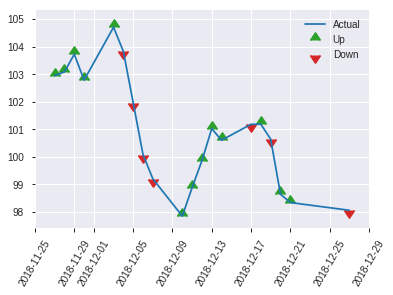


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20305554436614906
RMSE: 0.4506168487375378
LogLoss: 0.5912213484244317
Mean Per-Class Error: 0.2802372310085559
AUC: 0.7561576354679803
pr_auc: 0.7228026889506953
Gini: 0.5123152709359606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47788625955581665: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      91   42   0.3158   (42.0/133.0)
1      29   87   0.25     (29.0/116.0)
Total  120  129  0.2851   (71.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477886     0.710204  128
max f2                       0.136164     0.833333  225
max f0point5                 0.486757     0.694444  123
max accuracy                 0.486757     0.718876  123
max precision                0.785468     1         0
max recall                   0.105347     1         240
max specificity              0.785468     1         0
max absolute_mcc             0.486757     0.438504  123
max min_per_class_accuracy   0.497164     0.706897  119
max mean_per_class_accuracy  0.486757     0.719763  123

Gains/Lift Table: Avg response rate: 46.59 %, avg score: 44.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.732626           2.14655   2.14655            1                0.755034  1                           0.755034            0.0258621       0.0258621                  114.655   114.655
    2        0.0200803                   0.722247           2.14655   2.14655            1                0.729178  1                           0.744691            0.0172414       0.0431034                  114.655   114.655
    3        0.0321285                   0.715651           2.14655   2.14655            1                0.719722  1                           0.735328            0.0258621       0.0689655                  114.655   114.655
    4        0.0401606                   0.71362            2.14655   2.14655            1                0.714595  1                           0.731181            0.0172414       0.0862069                  114.655   114.655
    5        0.0522088                   0.7103             1.43103   1.98143            0.666667         0.712067  0.923077                    0.72677             0.0172414       0.103448                   43.1034   98.1432
    6        0.100402                    0.656881           1.78879   1.88897            0.833333         0.678606  0.88                        0.703651            0.0862069       0.189655                   78.8793   88.8966
    7        0.15261                     0.634326           1.32095   1.69465            0.615385         0.643829  0.789474                    0.683186            0.0689655       0.258621                   32.0955   69.4646
    8        0.200803                    0.609223           1.60991   1.67431            0.75             0.625177  0.78                        0.669264            0.0775862       0.336207                   60.9914   67.431
    9        0.301205                    0.573852           1.20207   1.5169             0.56             0.592629  0.706667                    0.643719            0.12069         0.456897                   20.2069   51.6897
    10       0.401606                    0.528745           1.28793   1.45966            0.6              0.554601  0.68                        0.621439            0.12931         0.586207                   28.7931   45.9655
    11       0.502008                    0.485319           1.45966   1.45966            0.68             0.505028  0.68                        0.598157            0.146552        0.732759                   45.9655   45.9655
    12       0.598394                    0.438966           0.626078  1.32539            0.291667         0.463912  0.61745                     0.576534            0.0603448       0.793103                   -37.3922  32.5388
    13       0.698795                    0.361003           0.515172  1.20898            0.24             0.399655  0.563218                    0.55112             0.0517241       0.844828                   -48.4828  20.8977
    14       0.799197                    0.227081           0.858621  1.16496            0.4              0.298753  0.542714                    0.519416            0.0862069       0.931034                   -14.1379  16.4963
    15       0.899598                    0.139182           0.42931   1.08286            0.2              0.191495  0.504464                    0.482817            0.0431034       0.974138                   -57.069   8.28587
    16       1                           0.0876341          0.257586  1                  0.12             0.112991  0.465863                    0.445686          

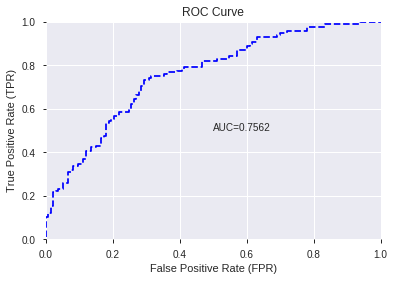

This function is available for GLM models only


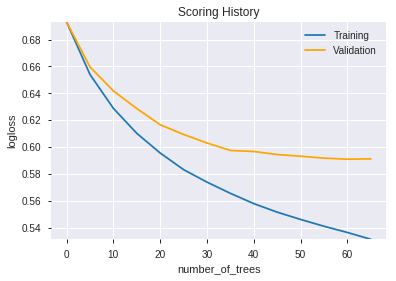

--2019-08-28 15:47:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.115.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.115.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

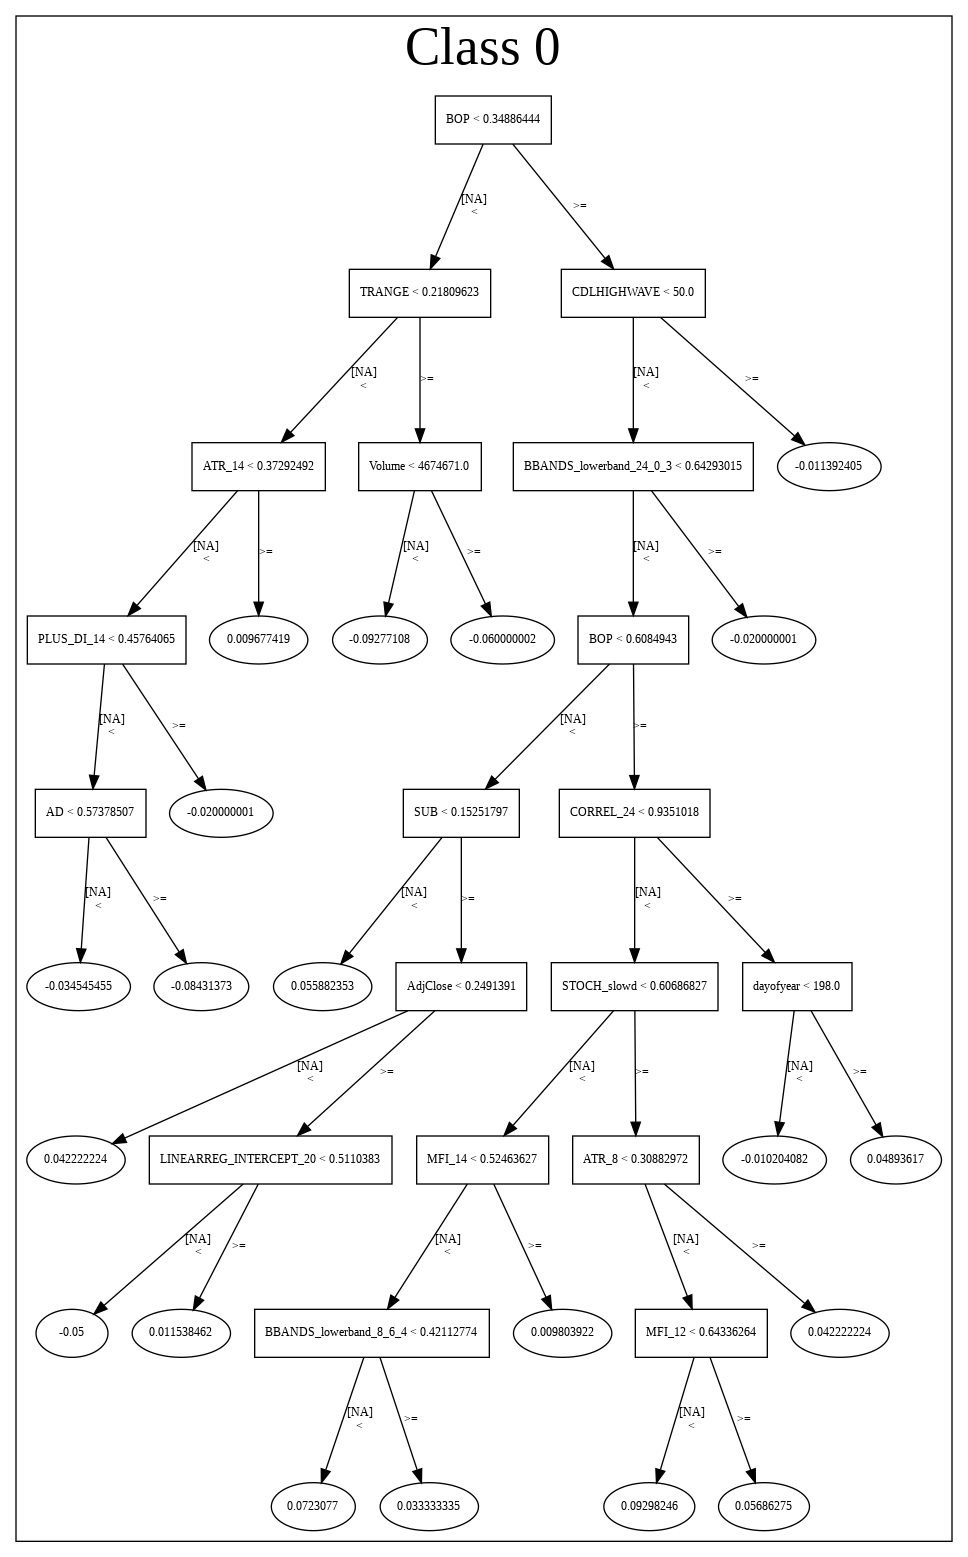

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_154725_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_154725_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9cf3',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_8',
 'MFI_14',
 'MFI_12',
 'ADXR_8',
 'AD',
 'BETA_8',
 'LINEARREG_ANGLE_14',
 'PLUS_DI_30',
 'ULTOSC',
 'ADOSC',
 'MINUS_DM_14',
 'NATR_12',
 'MACDFIX_signal_20',
 'DX_8',
 'MOM_30',
 'OBV',
 'ROC_8',
 'MFI_8',
 'BBANDS_lowerband_20_2_5',
 'PLUS_DI_12',
 'CORREL_8',
 'DX_12',
 'STOCHRSI_fastk',
 'ADX_20',
 'STOCHRSI_fastd',
 'ATR_8',
 'HT_PHASOR_inphase',
 'BBANDS_middleband_14_5_3',
 'VAR_12',
 'CDLSPINNINGTOP',
 'MACDFIX_hist_12',
 'WILLR_14',
 'aroondown_14',
 'ROC_20',
 'STOCHF_fastd',
 'ROC_24',
 'BBANDS_lowerband_30_1_5',
 'MACDEXT',
 'BBANDS_upperband_30_1_5',
 'ROCP_30',
 'ROCR100_12',
 'AROONOSC_24',
 'BBANDS_upperband_20_6_5',
 'WILLR_8',
 'MOM_24',
 'STOCH_slowd',
 'MAVP_20_2',
 'aroondown_12',
 'aroondown_8']

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.699
GLM             0.715
XGBoost         0.719
dtype: float64

DeepLearning    GLM  XGBoost
All          0.614  0.570    0.707
DLF          0.699  0.695    0.707
Fwe          0.699  0.687    0.703
RFE          0.691  0.715    0.719
XGBF         0.691  0.695    0.707





F1


DeepLearning    0.709
GLM             0.717
XGBoost         0.712
dtype: float64

DeepLearning    GLM  XGBoost
All          0.636  0.636    0.712
DLF          0.705  0.713    0.701
Fwe          0.691  0.705    0.711
RFE          0.709  0.717    0.710
XGBF         0.701  0.713    0.701





auc


DeepLearning    0.753
GLM             0.762
XGBoost         0.756
dtype: float64

DeepLearning    GLM  XGBoost
All          0.557  0.518    0.754
DLF          0.739  0.747    0.753
Fwe          0.753  0.750    0.740
RFE          0.739  0.762    0.756
XGBF         0.745  0.747    0.753





logloss


DeepLearning    6.023
GLM             7.208
XGBoost         0.596
dtype: float64

DeepLearning    GLM  XGBoost
All          6.023  7.208    0.593
DLF          0.623  0.594    0.589
Fwe          0.622  0.588    0.596
RFE          0.599  0.584    0.591
XGBF         0.631  0.594    0.589





mean_per_class_error


DeepLearning    0.407
GLM             0.442
XGBoost         0.305
dtype: float64

DeepLearning    GLM  XGBoost
All          0.407  0.442    0.295
DLF          0.297  0.301    0.305
Fwe          0.307  0.306    0.292
RFE          0.302  0.282    0.280
XGBF         0.321  0.301    0.305





rmse


DeepLearning    0.580
GLM             0.604
XGBoost         0.453
dtype: float64

DeepLearning    GLM  XGBoost
All          0.580  0.604    0.452
DLF          0.464  0.451    0.450
Fwe          0.467  0.450    0.453
RFE          0.454  0.447    0.451
XGBF         0.463  0.451    0.450





mse


DeepLearning    0.336
GLM             0.365
XGBoost         0.205
dtype: float64

DeepLearning    GLM  XGBoost
All          0.336  0.365    0.204
DLF          0.215  0.204    0.202
Fwe          0.218  0.202    0.205
RFE          0.206  0.200    0.203
XGBF         0.215  0.204    0.202

{'F1':       DeepLearning    GLM  XGBoost
 All          0.636    NaN      NaN
 DLF          0.705    NaN      NaN
 DLF            NaN  0.713      NaN
 DLF            NaN    NaN    0.701
 All            NaN  0.636      NaN
 All            NaN    NaN    0.712
 XGBF         0.701    NaN      NaN
 XGBF           NaN  0.713      NaN
 XGBF           NaN    NaN    0.701
 Fwe          0.691    NaN      NaN
 Fwe            NaN  0.705      NaN
 Fwe            NaN    NaN    0.711
 RFE          0.709    NaN      NaN
 RFE            NaN  0.717      NaN
 RFE            NaN    NaN    0.710,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.614    NaN      NaN
 DLF          0.699    NaN      NaN
 DLF            NaN  0.695      NaN
 DLF            NaN    NaN    0.707
 All            NaN  0.570      NaN
 All            NaN    NaN    0.707
 XGBF         0.691    NaN      NaN
 XGBF           NaN  0.695      NaN
 XGBF           NaN    NaN    0.707
 Fwe          0.699    NaN      NaN
 Fwe     